# Results for Multi-modal Approaches

Evaluation metrics used:

- ROC/AUC
- Accuracy 
- Precision
- Recall
- F1-score

In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf 
import tensorflow_addons as tfa

from pathlib import Path
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, accuracy_score
from tensorflow.keras.layers import Input, LSTM, Dense, Flatten, TimeDistributed, Conv1D, BatchNormalization, MaxPooling1D, ConvLSTM1D, Bidirectional, Concatenate
from tensorflow.keras import Model
from tensorflow.keras.initializers import Constant
from keras.layers.advanced_activations import PReLU

## Methods for loading datasets and creating model architectures

In [3]:
def load_file(file):
    df = pd.read_csv(file, header=0)
    labels = df['pain']
    df = df.drop(columns=['pain'])
    df.drop(df.columns[-1], axis=1, inplace=True)
    return df, labels

def load_dataset(input_filepath, modality):
    feature_names = []
    classes = []
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if feature_names == []:
                feature_names = x.columns.values.tolist()
            if labels[0] not in classes:
                classes.append(labels[0])
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            x = x.to_numpy()
            X.append(x)
            y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test, feature_names, classes

def load_earlyfusion_dataset(input_filepath):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    body_train_filepath = data_dir / input_filepath / 'train' / 'skeleton'
    body_test_filepath = data_dir / input_filepath / 'test' / 'skeleton'
    face_train_filepath = data_dir / input_filepath / 'train' / 'AUs'
    face_test_filepath = data_dir / input_filepath / 'test' / 'AUs'
    # 1. Load train data
    X = list()
    y = list()
    for file in body_train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            has_equivalent_face_file = False
            for second_file in face_train_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    body_x = body_x.to_numpy()
                    face_x = face_x.to_numpy()
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in body_test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            body_x, body_labels = load_file(file)
            body_x = body_x.to_numpy()
            has_equivalent_face_file = False
            for second_file in face_test_filepath.iterdir():
                if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                    # Concatenate features
                    face_x, face_labels = load_file(second_file)
                    face_x = face_x.to_numpy()
                    full_X = np.concatenate((body_x, face_x), axis=1)
                    X.append(full_X)
                    y.append(body_labels[0])
                    has_equivalent_face_file = True
                    break
            if not has_equivalent_face_file:
                continue
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

def load_latefusion_dataset(input_filepath, modality):
    root_dir = Path(os.path.abspath('')).parent
    data_dir = root_dir / 'data'
    train_filepath = data_dir / input_filepath / 'train' / modality
    test_filepath = data_dir / input_filepath / 'test' / modality
    # 1. Load train data
    X = list()
    y = list()
    for file in train_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'train' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_train = X.reshape((len(X), 1, n_length, n_features))
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y)
    # 2. Load test data
    X = list()
    y = list()
    for file in test_filepath.iterdir():
        if file.is_file() and file.name.endswith('.csv'):
            x, labels = load_file(file)
            if modality == 'skeleton':
                has_equivalent_face_file = False 
                for second_file in (data_dir / input_filepath / 'test' / 'AUs').iterdir():
                    if second_file.is_file() and second_file.name.endswith('.csv') and second_file.name == file.name:
                        has_equivalent_face_file = True
                        break
                if not has_equivalent_face_file:
                    continue
                else: 
                    x = x.to_numpy()
                    X.append(x)
                    y.append(labels[0])
            else:
                x = x.to_numpy()
                X.append(x)
                y.append(labels[0])
    n_length = X[0].shape[0]
    n_features = X[0].shape[1]
    X = np.array(X)
    X_test = X.reshape((len(X), 1, n_length, n_features))
    y_test = lb.transform(y)
    return X_train, X_test, y_train, y_test

In [4]:
class KerasMember():
    def __init__(self, name=None, keras_model=None, train_batches=None,
                 val_batches=None, submission_probs=None, keras_modelpath=None,
                 keras_kwargs={}):
        assert(name is not None)
        self.name = name
        self.model = keras_model
        self.submission_probs = submission_probs
        # Initialize Params
        self.val_probs = None
        self.train_probs = None
        self.val_classes = None
        self.train_classes = None
        if (keras_model is None) and (keras_modelpath is not None):
            self.load_kerasmodel(self.keras_modelpath, self.keras_kwargs)
        if train_batches is not None:
            self._calculate_train_predictions(train_batches)
        if val_batches is not None:
            self._calculate_val_predictions(val_batches)

    def _test_datatuple(self, datatuple):
        assert(len(datatuple) == 2)
        assert(datatuple[0].shape[0] == datatuple[1].shape[0])

    def _calculate_predictions(self, batches):
        if hasattr(batches, 'shuffle'):
            batches.reset()
            batches.shuffle = False
        if type(batches) is tuple:
            self._test_datatuple(batches)
            return self.model.predict(batches[0])
        return self.model.predict_generator(
            batches, steps=(batches.n // batches.batch_size) + 1, verbose=1)

    def _calculate_val_predictions(self, val_batches):
        if type(val_batches) is tuple:
            self.val_classes = val_batches[1]
        elif hasattr(val_batches, 'classes'):
            self.val_classes = np.array(val_batches.classes)
        elif hasattr(val_batches, 'y'):
            self.val_classes = np.array(val_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.val_probs = self._calculate_predictions(val_batches)
        return self.val_probs

    def _calculate_train_predictions(self, train_batches):
        if type(train_batches) is tuple:
            self.train_classes = train_batches[1]
        elif hasattr(train_batches, 'classes'):
            self.train_classes = np.array(train_batches.classes)
        elif hasattr(train_batches, 'y'):
            self.train_classes = np.array(train_batches.y)
        else:
            raise ValueError("No known class in data batch")
        self.train_probs = self._calculate_predictions(train_batches)
        return self.train_probs


In [5]:
def train(model, X_train, y_train, X_val, y_val, epochs, batch_size, class_weight):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10)
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, callbacks=[early_stopping],
        batch_size=batch_size, verbose=2, class_weight=class_weight)
    return history

def train_fusioned(model, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs, batch_size, class_weight):
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', patience=10)
    history = model.fit([body_X_train, face_X_train], y_train, validation_data=([body_X_val, face_X_val], y_val), 
                        epochs=epochs, batch_size=batch_size, callbacks=[early_stopping], class_weight=class_weight, verbose=2)
    return history

### Bidirectional LSTM Model

Bidrectional LSTM runs the input in two ways (past to future and future to past) making it possible to preserve information both backwards and forwards. I included this layer type anticipating it could be suited for making the model understand context to assess any experience of pain. 

Additionally, bidrectional LSTM is used by [Bargshady et al.](https://pubmed.ncbi.nlm.nih.gov/34756219/) in an Ensemble combination of CNN+BiLSTM models for facial expressions modality. Their settings: 

- filters: 256
- dense: 4096

In [6]:
def build_biLSTM(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input = Input(shape=(1, n_length, n_features))
    bilstm_1 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(input)
    bilstm_2 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_1)
    bilstm_3 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_2)
    flatten = Flatten()(bilstm_3)
    dense = Dense(neurons, activation=activation)(flatten)
    dense = Dense(neurons, activation=activation)(flatten)
    output = Dense(units=n_outputs, activation='softmax')(dense)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_biLSTM(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input_1 = Input(shape=(1, n_length, body_features))
    bilstm_1 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(input_1)
    bilstm_11 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_1)
    bilstm_111 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(bilstm_11)
    flatten_1 = Flatten()(bilstm_111)
    dense_1 = Dense(neurons, activation=activation)(flatten_1)
    dense_11 = Dense(neurons, activation=activation)(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    bilstm_2 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer))(input_2)
    bilstm_22 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer))(bilstm_2)
    bilstm_222 = Bidirectional(ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer))(bilstm_22)
    flatten_2 = Flatten()(bilstm_222)
    dense_2 = Dense(neurons, activation=activation)(flatten_2)
    dense_22 = Dense(neurons, activation=activation)(dense_2)

    concat = Concatenate()([dense_11, dense_22])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### CNN+LSTM Model

This combination was developed for visual time series prediction problems and is popular in both activity recognition and pain assessment areas.

Several previous work has used CNN+LSTM models, for example:

- [Yang et al.](https://arxiv.org/abs/2105.08822) to encode appearance changes and physiological cues from videos. 

- [Salekin et al.](https://arxiv.org/abs/2012.02175). Combines three modalities with (late) decision fusion. CNN filters start at 64 and gradually increses by a factor of 2 until 512. Used a small kernel size of 3, and follow with a pooling layer. Dense: 512. LSTM: 16 with activation tanh and recurrent activation hard sigmoid (because of binary classification). 

- [Haque et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/8373837) extracts RGB, thermal, depth features from videos and test two fusion strategies (early fusion received highest performance). LSTM hidden states vary between 64 and 256.

- [Rodriguez et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7849133). Trying to make an end-to-end framework using VGGFace architecture + LSTM.

In [7]:
def build_CNN(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input = Input(shape=(1, n_length, n_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(input)
    conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2)
    conv1d_3 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(maxpool_1)
    conv1d_4 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_3)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_4)
    flatten = TimeDistributed(Flatten())(maxpool_2)
    lstm_1 = LSTM(neurons, return_sequences=True)(flatten)
    lstm_2 = LSTM(neurons)(lstm_1)
    dense_1 = Dense(neurons, activation=activation)(lstm_2)
    dense_2 = Dense(neurons, activation=activation)(dense_1)
    output = Dense(units=n_outputs, activation='softmax')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_CNN(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input_1 = Input(shape=(1, n_length, body_features))
    conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(input_1)
    conv1d_11 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_1)
    maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_11)
    conv1d_111 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(maxpool_1)
    conv1d_1111 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_111)
    maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_1111)
    flatten_1 = TimeDistributed(Flatten())(maxpool_11)
    lstm_1 = LSTM(neurons, return_sequences=True)(flatten_1)
    lstm_11 = LSTM(neurons)(lstm_1)
    dense_1 = Dense(neurons, activation=activation)(lstm_11)
    dense_11 = Dense(neurons, activation=activation)(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(input_2)
    conv1d_22 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_2)
    maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_22)
    conv1d_222 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(maxpool_2)
    conv1d_2222 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=activation, kernel_initializer=kernel_initializer, dropout=dropout))(conv1d_222)
    maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(conv1d_2222)
    flatten_2 = TimeDistributed(Flatten())(maxpool_22)
    lstm_2 = LSTM(neurons, return_sequences=True)(flatten_2)
    lstm_22 = LSTM(neurons)(lstm_2)
    dense_2 = Dense(neurons, activation=activation)(lstm_22)
    dense_22 = Dense(neurons, activation=activation)(dense_2)

    concat = Concatenate()([dense_11, dense_22])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### Convolutional LSTM Model

A CNN-LSTM (model above) is an integration of a CNN with an LSTM, but ConvLSTM is a kind of LSTM which replaces the matrix multiplication with convolution operation at each gate in the LSTM cell.

I have not encountered this layer type when preparing the training protocol (from previous work), but I find it interesting to see if it could give different results.

In [8]:
def build_convLSTM(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input = Input(shape=(1, n_length, n_features))
    convlstm_1 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout)(input)
    convlstm_2 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout)(convlstm_1)
    flatten = Flatten()(convlstm_2)
    dense_1 = Dense(neurons, activation=activation)(flatten)
    dense_2 = Dense(neurons, activation=activation)(dense_1)
    output = Dense(units=n_outputs, activation='softmax')(dense_2)
    model = Model(inputs=input, outputs=output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

def build_fusioned_convLSTM(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
    input_1 = Input(shape=(1, n_length, body_features))
    convlstm_1 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout)(input_1)
    convlstm_11 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout)(convlstm_1)
    flatten_1 = Flatten()(convlstm_11)
    dense_1 = Dense(neurons, activation=activation)(flatten_1)
    dense_11 = Dense(neurons, activation=activation)(dense_1)

    input_2 = Input(shape=(1, n_length, face_features))
    convlstm_2 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, return_sequences=True, kernel_initializer=kernel_initializer, dropout=dropout)(input_2)
    convlstm_22 = ConvLSTM1D(filters=neurons, kernel_size=(kernel_size), activation=activation, kernel_initializer=kernel_initializer, dropout=dropout)(convlstm_2)
    flatten_2 = Flatten()(convlstm_22)
    dense_2 = Dense(neurons, activation=activation)(flatten_2)
    dense_22 = Dense(neurons, activation=activation)(dense_2)

    concat = Concatenate()([dense_11, dense_22])
    output = Dense(units=n_outputs, activation='softmax')(concat)
    model = Model(inputs=[input_1, input_2], outputs=[output])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
    return model

### RCNN (Recurrent CNN) Model

A network that has both convolutional and recurrent convolutional layers, or adding recurrent connections within every convolutional layer of a feed-forward CNN.

Additionally, RCNN is used by [Zhou et al.](https://ieeexplore-ieee-org.proxy.lnu.se/document/7789681) with video input for pain intensity prediction using PSPI.

In [9]:
def build_RCNN(n_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
   input = Input(shape=(1, n_length, n_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(input)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(maxpool_1)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   flatten = Flatten()(maxpool_2)
   dense_1 = Dense(neurons, activation=activation)(flatten)
   dense_2 = Dense(neurons, activation=activation)(dense_1)
   output = Dense(units=n_outputs, activation='softmax')(dense_2)
   model = Model(inputs=input, outputs=output)
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

def build_fusioned_RCNN(body_features, face_features, n_length, n_outputs, neurons=100, kernel_size=3, activation='relu', kernel_initializer='glorot_uniform', dropout=0.0):
   input_1 = Input(shape=(1, n_length, body_features))
   conv1d_1 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(input_1)
   bn_1 = TimeDistributed(BatchNormalization())(conv1d_1)
   maxpool_1 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_1)
   conv1d_11 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(maxpool_1)
   bn_11 = TimeDistributed(BatchNormalization())(conv1d_11)
   maxpool_11 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_11)
   flatten_1 = Flatten()(maxpool_11)
   dense_1 = Dense(neurons, activation=activation)(flatten_1)
   dense_11 = Dense(neurons, activation=activation)(dense_1)

   input_2 = Input(shape=(1, n_length, face_features))
   conv1d_2 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(input_2)
   bn_2 = TimeDistributed(BatchNormalization())(conv1d_2)
   maxpool_2 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_2)
   conv1d_22 = TimeDistributed(Conv1D(filters=neurons, kernel_size=kernel_size, activation=PReLU(alpha_initializer=Constant(value=0.25)), kernel_initializer='glorot_uniform', dropout=0.0))(maxpool_2)
   bn_22 = TimeDistributed(BatchNormalization())(conv1d_22)
   maxpool_22 = TimeDistributed(MaxPooling1D(pool_size=2, data_format='channels_first'))(bn_22)
   flatten_2 = Flatten()(maxpool_22)
   dense_2 = Dense(neurons, activation=activation)(flatten_2)
   dense_22 = Dense(neurons, activation=activation)(dense_2)

   concat = Concatenate()([dense_11, dense_22])
   output = Dense(units=n_outputs, activation='softmax')(concat)
   model = Model(inputs=[input_1, input_2], outputs=[output])
   model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy', tf.keras.metrics.AUC(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall(), tfa.metrics.F1Score(num_classes=n_outputs, average='macro')])
   return model

In [10]:
class StackEnsemble():
    def __init__(self, model=None):
        self.model = model
        if model is None:
            self.model = RandomForestClassifier(n_estimators=100, max_depth=4, n_jobs=20)
        # Initialize Parameters:
        self.members = []
        self._nmembers = 0
        self.predictions = None
        self._y_squeezed = False  # Flags if labels dimension must be squeezed

    def __repr__(self):
        reps = [member.name for member in self.members]
        return "<StackEnsemble: [" + ", ".join(reps) + "]>"

    def __str__(self):
        reps = [member.name for member in self.members]
        return "StackEnsemble: with" + \
            str(self._nmembers) + " Base-Learners [" + ", ".join(reps) + "]"

    def add_members(self, members):
        for member in members:
            self.add_member(member)
        self._test()

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1
        if member.val_probs is None:
            try:
                member.val_probs = member._calculate_val_predictions()
            except Exception as e:
                warnings.warn(str(e))
        if member.train_probs is None:
            try:
                member.train_probs = member._calculate_train_predictions()
            except Exception as e:
                warnings.warn(str(e))

    def fit(self, X=None, y=None, kwargs={}):
        assert(len(self.members) > 1)
        # Assumption: all members have same train_batches.classes
        if X is None or y is None:
            return self._fit_train()
        if X.ndim >= 3:
            X = X.reshape(X.shape[0], np.prod(X.shape[1::]))
        try:
            self._y_squeezed = False
            return self.model.fit(X, y, **kwargs)
        except ValueError:  # Normally bad input shape for non-multi-output models
            self._y_squeezed = True
            y_flat = np.argmax(y, axis=1)
            return self.model.fit(X, y_flat, **kwargs)

    def predict(self, X, predict_proba=False, kwargs={}):
        if X is None:
            X = self._get_pred_X()
        if X.ndim == 3:
            X = X.reshape(X.shape[0], X.shape[1] * X.shape[2])
        if (predict_proba or self._y_squeezed) and hasattr(self.model, 'predict_proba'):
            self.predictions = self.model.predict_proba(X, **kwargs)
        elif hasattr(self.model, 'predict'):
            self.predictions = self.model.predict(X, **kwargs)
        else:
            raise ValueError("Model has no predict function")
        return np.array(self.predictions)

    def describe(self, probabilities_val=None, metric=None, maximize=True):
        best_score = float("-inf") if maximize else float("inf")
        if metric is None:
            metric = roc_auc_score
        if probabilities_val is None:
            probabilities_val = self._predict_val()
        # Assumption: all members have same val_classes
        val_classes = self.members[0].val_classes
        for i in range(self._nmembers):
            member = self.members[i]
            auc_score = _calculate_metric(
                member.val_classes, member.val_probs)
            acc_score = _calculate_metric(
                member.val_classes, member.val_probs, accuracy_score)
            prf1 = _calculate_metric(
                member.val_classes, member.val_probs, precision_recall_fscore_support)
            p = prf1[0]
            r = prf1[1]
            f1 = prf1[2]
            max_flag = maximize and auc_score > best_score
            min_flag = not(maximize) and auc_score < best_score
            if max_flag or min_flag:
                best_score = auc_score
            text = member.name + " - Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
                auc_score, acc_score * 100, p, r, f1)
        ensemble_score = _calculate_metric(
            val_classes, probabilities_val)
        ensemble_accuracy = _calculate_metric(
                val_classes, probabilities_val, accuracy_score)
        ensemble_prf1 = _calculate_metric(
                val_classes, probabilities_val, precision_recall_fscore_support)
        ensemble_p = ensemble_prf1[0]
        ensemble_r = ensemble_prf1[1]
        ensemble_f1 = ensemble_prf1[2]
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            ensemble_accuracy * 100, ensemble_score, ensemble_p, ensemble_r, ensemble_f1))
        return ensemble_score

    def _get_X(self, attrname):
        X = []
        probs = getattr(self.members[0], attrname)
        # Assumption: all members have same train_probs length
        for i in range(len(probs)):
            preds = []
            for member in self.members:
                preds.append(getattr(member, attrname)[i])
            X.append(preds)
        return np.array(X)

    def _get_train_X(self):
        return self._get_X("train_probs")

    def _get_val_X(self):
        return self._get_X("val_probs")

    def _get_pred_X(self):
        return self._get_X("submission_probs")

    def _fit_train(self):
        return self.fit(self._get_train_X(), self.members[0].train_classes)

    def _fit_submission(self):
        X1 = self._get_train_X()
        X2 = self._get_val_X()
        y1 = self.members[0].train_classes
        y2 = self.members[0].val_classes
        X = np.concatenate((X1, X2))
        y = np.concatenate((y1, y2))
        return self.fit(X, y)

    def _predict_val(self):
        return self.predict(self._get_val_X())


def _calculate_metric(y_true, y_pred, metric=None):
    if metric is None:
        metric = roc_auc_score
    y_t = y_true
    y_p = y_pred
    if metric == roc_auc_score:
        return metric(y_t, y_p, multi_class='ovo')
    if y_true.ndim > 1:
        y_t = np.argmax(y_true, axis=1)
    if y_pred.ndim > 1:
        y_p = np.argmax(y_pred, axis=1)
    if metric is precision_recall_fscore_support:
        return precision_recall_fscore_support(y_t, y_p, average='macro')
    return metric(y_t, y_p)

### Dirichlet Markov Ensemble with soft voting

The Dirichlet ensemble weights the ensemble members based on validation set performance. The weight optimization search is performed with randomized search based on the dirichlet distribution. 
    
Soft voting involves summing the predicted probability scores for each class label and predicting the class label with the largest probability.

In [11]:
class DirichletEnsemble():
    def __init__(self, N=10000, metric=None, maximize=True):
        self.n = N
        self.metric = metric
        if metric is None:
            self.metric = roc_auc_score
        self.maximize = maximize
        # Initialize Parameters:
        self.members = []
        self.bestweights = []
        self.probabilities = None
        self._nmembers = 0
        self.bestscore = float("-inf") if maximize else float("inf")
        self.accuracy = None
        self.precision = None
        self.recall = None
        self.f1 = None
        self.fitted = False

    def add_members(self, members):
        for member in members:
            self.add_member(member)

    def add_member(self, member):
        self.members.append(member)
        self._nmembers += 1

    def fit(self, verbose=False):
        assert(len(self.members) > 1)
        val_classes = self.members[0].val_classes
        best_ensemble_score = float("-inf") if self.maximize else float("inf")
        best_ensemble_accuracy = 0
        best_ensemble_p = 0
        best_ensemble_r = 0
        best_ensemble_f1 = 0
        rsbest = None
        for i in range(self.n):
            rs = np.random.dirichlet(np.ones(self._nmembers), size=1)[0]
            preds = np.sum(np.array([self.members[i].val_probs * rs[i]
                                     for i in range(self._nmembers)]), axis=0)
            ensemble_score = _calculate_metric(val_classes, preds)
            ensemble_accuracy = _calculate_metric(val_classes, preds, accuracy_score)
            ensemble_prf1 = _calculate_metric(val_classes, preds, precision_recall_fscore_support)
            ensemble_p = ensemble_prf1[0]
            ensemble_r = ensemble_prf1[1]
            ensemble_f1 = ensemble_prf1[2]
            max_flag = self.maximize and ensemble_score > best_ensemble_score
            min_flag = not(
                self.maximize) and ensemble_score < best_ensemble_score
            if max_flag or min_flag:
                if verbose:
                    print(ensemble_score, i, rs) 
                best_ensemble_score = ensemble_score
                rsbest = rs
            if ensemble_accuracy > best_ensemble_accuracy:
                if verbose:
                    print(ensemble_accuracy, i, rs) 
                best_ensemble_accuracy = ensemble_accuracy
            if ensemble_p > best_ensemble_p:
                if verbose:
                    print(ensemble_p, i, rs) 
                best_ensemble_p = ensemble_p
            if ensemble_r > best_ensemble_r:
                if verbose:
                    print(ensemble_r, i, rs) 
                best_ensemble_r = ensemble_r
            if ensemble_f1 > best_ensemble_f1:
                if verbose:
                    print(ensemble_f1, i, rs) 
                best_ensemble_f1 = ensemble_f1
        self.bestweights = rsbest
        self.bestscore = best_ensemble_score
        self.accuracy = best_ensemble_accuracy
        self.precision = best_ensemble_p
        self.recall = best_ensemble_r
        self.f1 = best_ensemble_f1

    def predict(self):
        self.probabilities = np.sum(np.array([self.bestweights[i] *
                                              self.members[i].submission_probs
                                              for i in range(self._nmembers)]),
                                    axis=0)
        return self.probabilities
        
    def describe(self):
        for i in range(self._nmembers):
            member = self.members[i]
            text = member.name + " (weight: {:1.4f})".format(self.bestweights[i])
            print(text)
        print("Accuracy: {:1.2f}% - ROC/AUC: {:1.2f} - Precision: {:1.2f} - Recall: {:1.2f} - F1 score: {:1.2f}".format(
            self.accuracy * 100, self.bestscore, self.precision, self.recall, self.f1))
        return

### KFold CV

In [12]:
kf = KFold(n_splits=3, shuffle=True, random_state=42)
epochs, batch_size = 15, 32

### Grid Search CV

In [13]:
batch_sizes = [32, 64, 128, 256, 512]
activation = ['relu', 'tanh']
neurons = [50, 100, 250, 500]
kernel_size = [3, 5]
kernel_initializer = ['glorot_uniform', 'glorot_normal', 'he_uniform', 'he_normal', 'random_uniform', 'random_normal']
dropout = [0.0, 0.2, 0.5]

## 1. Uni-modal approaches

Training the different model architectures on single modalities (skeleton vs action units). 

### About the data

In [14]:
full_body_X_train, full_body_X_test, full_body_y_train, full_body_y_test, body_feature_names, classes = load_dataset('processed', 'skeleton')
full_body_X = full_body_X_train.copy()
full_body_y = full_body_y_train.copy()

print(full_body_X_train.shape, full_body_y_train.shape)
print(full_body_X_test.shape, full_body_y_test.shape)

n_length, body_features, body_outputs = full_body_X_train.shape[2], full_body_X_train.shape[-1], full_body_y_test.shape[1]

(525, 1, 350, 38) (525, 4)
(90, 1, 350, 38) (90, 4)


In [15]:
body_feature_names

['head_x',
 'head_y',
 'head_score',
 'left_shoulder_x',
 'left_shoulder_y',
 'left_shoulder_score',
 'left_elbow_x',
 'left_elbow_y',
 'left_elbow_score',
 'right_shoulder_x',
 'right_shoulder_y',
 'right_shoulder_score',
 'right_elbow_x',
 'right_elbow_y',
 'right_elbow_score',
 'left_hand_x',
 'left_hand_y',
 'left_hand_score',
 'right_hand_x',
 'right_hand_y',
 'right_hand_score',
 'left_hip_x',
 'left_hip_y',
 'left_hip_score',
 'right_hip_x',
 'right_hip_y',
 'right_hip_score',
 'left_knee_x',
 'left_knee_y',
 'left_knee_score',
 'right_knee_x',
 'right_knee_y',
 'right_knee_score',
 'left_foot_x',
 'left_foot_y',
 'left_foot_score',
 'right_foot_x',
 'right_foot_y']

The train dataset is imbalanced

In [16]:
umild, lmoderate, lmild, umoderate = np.sum(full_body_y, axis=0)
total = umild + lmoderate + lmild + umoderate

print(classes[0], ':', umild, '({:.1f}% of total)'.format(umild / total * 100))
print(classes[2], ':', lmild, '({:.1f}% of total)'.format(lmild / total * 100))
print(classes[1], ':', lmoderate, '({:.1f}% of total)'.format(lmoderate / total * 100))
print(classes[3], ':', umoderate, '({:.1f}% of total)'.format(umoderate / total * 100))

LowerBody Mild : 277 (52.8% of total)
LowerBody Moderate : 197 (37.5% of total)
UpperBody Mild : 49 (9.3% of total)
UpperBody Moderate : 2 (0.4% of total)


In [17]:
weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 0: 0.95
Weight for class 1: 5.36
Weight for class 2: 1.33
Weight for class 3: 131.25


In [18]:
face_X_train, face_X_test, face_y_train, face_y_test, face_feature_names, c = load_dataset('processed', 'AUs')
face_X = face_X_train.copy()
face_y = face_y_train.copy()

print(face_X_train.shape, face_y_train.shape)
print(face_X_test.shape, face_y_test.shape)

n_length, face_features, face_outputs = face_X_train.shape[2], face_X_train.shape[-1], face_y_train.shape[1]

(509, 1, 350, 10) (509, 4)
(88, 1, 350, 10) (88, 4)


In [19]:
face_feature_names

['confidence',
 'AU04_r',
 'AU06_r',
 'AU07_r',
 'AU09_r',
 'AU10_r',
 'AU04_c',
 'AU06_c',
 'AU07_c',
 'AU09_c']

### 1.1 Body modality (skeleton) models

#### Train BiLSTM

In [58]:
body_best_biconv_acc = 0.0
body_best_biconv_auc = 0.0
body_biconv_loss = float("inf")
body_best_biconv_model = None
body_biconv_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

In [60]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_biLSTM = build_biLSTM(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_biLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_biconv_acc) and (history['val_roc_auc'] > body_best_biconv_auc):
                                body_best_biconv_acc = history['val_accuracy']
                                body_best_biconv_auc = history['val_roc_auc']
                                body_biconv_loss = history['loss']
                                body_best_biconv_model = body_biLSTM
                                body_biconv_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

Batch size 32 Activation relu Neurons 50 Kernel size 3 Kernel initializer glorot_uniform Dropout 0.0
Epoch 1/15
11/11 - 76s - loss: 13.0316 - accuracy: 0.3771 - auc_175: 0.6225 - precision_175: 0.3979 - recall_175: 0.3229 - f1_score: 0.2340 - val_loss: 1.9616 - val_accuracy: 0.2743 - val_auc_175: 0.6095 - val_precision_175: 0.2381 - val_recall_175: 0.1143 - val_f1_score: 0.1946 - 76s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 4.1876 - accuracy: 0.3286 - auc_175: 0.6418 - precision_175: 0.3607 - recall_175: 0.1257 - f1_score: 0.2040 - val_loss: 1.1714 - val_accuracy: 0.3429 - val_auc_175: 0.6934 - val_precision_175: 0.3333 - val_recall_175: 0.0914 - val_f1_score: 0.1905 - 3s/epoch - 286ms/step
Epoch 3/15
11/11 - 3s - loss: 4.7287 - accuracy: 0.4029 - auc_175: 0.7357 - precision_175: 0.4779 - recall_175: 0.1543 - f1_score: 0.2427 - val_loss: 1.1488 - val_accuracy: 0.4400 - val_auc_175: 0.6512 - val_precision_175: 1.0000 - val_recall_175: 0.0057 - val_f1_score: 0.1528 - 3s/epoch - 281m

KeyboardInterrupt: 

#### Train CNN+LSTM

In [ ]:
body_best_cnn_acc = 0.0
body_best_cnn_auc = 0.0
body_cnn_loss = float("inf")
body_best_cnn_model = None
body_cnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 26s - loss: 2.5531 - accuracy: 0.5629 - auc_66: 0.8145 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.1801 - val_loss: 1.2579 - val_accuracy: 0.4514 - val_auc_66: 0.7729 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.1555 - 26s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 2.5094 - accuracy: 0.5657 - auc_66: 0.8252 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.1807 - val_loss: 1.2769 - val_accuracy: 0.4514 - val_auc_66: 0.7733 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.1555 - 373ms/epoch - 34ms/step
Epoch 3/15
11/11 - 0s - loss: 2.5038 - accuracy: 0.5657 - auc_66: 0.8257 - precision_66: 0.0000e+00 - recall_66: 0.0000e+00 - f1_score: 0.1807 - val_loss: 1.2933 - val_accuracy: 0.4514 - val_auc_66: 0.7733 - val_precision_66: 0.0000e+00 - val_recall_66: 0.0000e+00 - val_f1_score: 0.1555 - 381ms/epoch - 35ms/step
Epoch 4/15
11/11 - 0s - loss: 2.5070 - accuracy: 0.5657 - auc

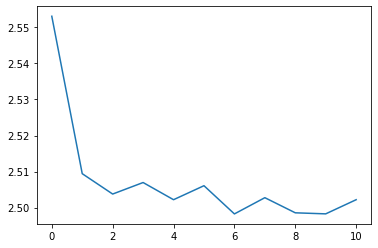

Epoch 1/15
11/11 - 15s - loss: 2.6321 - accuracy: 0.4371 - auc_67: 0.7290 - precision_67: 0.0000e+00 - recall_67: 0.0000e+00 - f1_score: 0.1902 - val_loss: 1.3454 - val_accuracy: 0.5314 - val_auc_67: 0.8095 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1735 - 15s/epoch - 1s/step
Epoch 2/15
11/11 - 0s - loss: 2.6164 - accuracy: 0.5257 - auc_67: 0.8033 - precision_67: 0.0000e+00 - recall_67: 0.0000e+00 - f1_score: 0.1723 - val_loss: 1.3492 - val_accuracy: 0.5314 - val_auc_67: 0.8095 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1735 - 389ms/epoch - 35ms/step
Epoch 3/15
11/11 - 0s - loss: 2.6085 - accuracy: 0.4171 - auc_67: 0.7777 - precision_67: 0.0000e+00 - recall_67: 0.0000e+00 - f1_score: 0.2061 - val_loss: 1.3362 - val_accuracy: 0.5314 - val_auc_67: 0.7829 - val_precision_67: 0.0000e+00 - val_recall_67: 0.0000e+00 - val_f1_score: 0.1735 - 379ms/epoch - 34ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6229 - accuracy: 0.5257 - auc

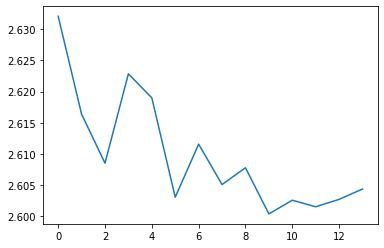

Epoch 1/15
11/11 - 17s - loss: 3.2582 - accuracy: 0.3829 - auc_68: 0.5860 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.1399 - val_loss: 1.3908 - val_accuracy: 0.3314 - val_auc_68: 0.5771 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.1245 - 17s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 3.2206 - accuracy: 0.3314 - auc_68: 0.4656 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.1774 - val_loss: 1.4248 - val_accuracy: 0.0686 - val_auc_68: 0.2874 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.0321 - 384ms/epoch - 35ms/step
Epoch 3/15
11/11 - 0s - loss: 3.2107 - accuracy: 0.1057 - auc_68: 0.2826 - precision_68: 0.0000e+00 - recall_68: 0.0000e+00 - f1_score: 0.0478 - val_loss: 1.4283 - val_accuracy: 0.0686 - val_auc_68: 0.2343 - val_precision_68: 0.0000e+00 - val_recall_68: 0.0000e+00 - val_f1_score: 0.0321 - 396ms/epoch - 36ms/step
Epoch 4/15
11/11 - 0s - loss: 3.1792 - accuracy: 0.0429 - auc

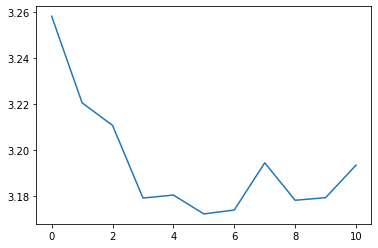

In [27]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_CNN = build_CNN(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_CNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_cnn_acc) and (history['val_roc_auc'] > body_best_cnn_auc):
                                body_best_cnn_acc = history['val_accuracy']
                                body_best_cnn_auc = history['val_roc_auc']
                                body_cnn_loss = history['loss']
                                body_best_cnn_model = body_CNN
                                body_cnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

#### Train ConvLSTM

In [ ]:
body_best_lstm_acc = 0.0
body_best_lstm_auc = 0.0
body_lstm_loss = float("inf")
body_best_lstm_model = None
body_lstm_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 23s - loss: 22.7262 - accuracy: 0.3714 - auc_69: 0.6618 - precision_69: 0.3709 - recall_69: 0.3571 - f1_score: 0.2304 - val_loss: 1.3858 - val_accuracy: 0.4343 - val_auc_69: 0.7305 - val_precision_69: 0.4435 - val_recall_69: 0.3143 - val_f1_score: 0.2081 - 23s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 4.1000 - accuracy: 0.4286 - auc_69: 0.7142 - precision_69: 0.5493 - recall_69: 0.2229 - f1_score: 0.2724 - val_loss: 1.1888 - val_accuracy: 0.4743 - val_auc_69: 0.7464 - val_precision_69: 0.4930 - val_recall_69: 0.2000 - val_f1_score: 0.2311 - 1s/epoch - 95ms/step
Epoch 3/15
11/11 - 1s - loss: 4.4581 - accuracy: 0.4457 - auc_69: 0.7543 - precision_69: 0.5631 - recall_69: 0.1657 - f1_score: 0.2665 - val_loss: 1.3006 - val_accuracy: 0.2514 - val_auc_69: 0.5747 - val_precision_69: 0.4783 - val_recall_69: 0.0629 - val_f1_score: 0.1816 - 1s/epoch - 96ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4849 - accuracy: 0.3457 - auc_69: 0.7077 - precision_69: 0.5408 - recall_69: 0.151

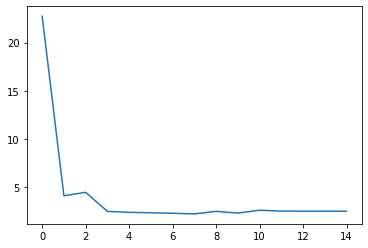

Epoch 1/15
11/11 - 25s - loss: 7.5232 - accuracy: 0.3114 - auc_70: 0.5950 - precision_70: 0.3304 - recall_70: 0.2114 - f1_score: 0.2076 - val_loss: 1.3661 - val_accuracy: 0.1086 - val_auc_70: 0.5941 - val_precision_70: 0.6667 - val_recall_70: 0.0114 - val_f1_score: 0.0583 - 25s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.6381 - accuracy: 0.1086 - auc_70: 0.5094 - precision_70: 0.5000 - recall_70: 0.0114 - f1_score: 0.0599 - val_loss: 1.3714 - val_accuracy: 0.1143 - val_auc_70: 0.4127 - val_precision_70: 1.0000 - val_recall_70: 0.0114 - val_f1_score: 0.0661 - 1s/epoch - 98ms/step
Epoch 3/15
11/11 - 1s - loss: 2.6221 - accuracy: 0.1171 - auc_70: 0.6243 - precision_70: 0.8571 - recall_70: 0.0171 - f1_score: 0.0684 - val_loss: 1.3871 - val_accuracy: 0.1086 - val_auc_70: 0.6475 - val_precision_70: 0.7500 - val_recall_70: 0.0171 - val_f1_score: 0.0609 - 1s/epoch - 98ms/step
Epoch 4/15
11/11 - 1s - loss: 2.6476 - accuracy: 0.1314 - auc_70: 0.6593 - precision_70: 0.4667 - recall_70: 0.0200

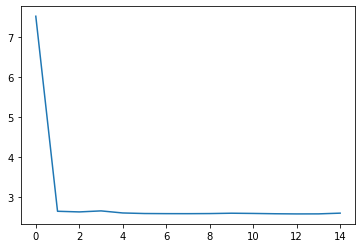

Epoch 1/15
11/11 - 25s - loss: 48.4829 - accuracy: 0.3000 - auc_71: 0.5250 - precision_71: 0.2991 - recall_71: 0.2914 - f1_score: 0.2352 - val_loss: 1.8919 - val_accuracy: 0.3771 - val_auc_71: 0.6863 - val_precision_71: 0.3882 - val_recall_71: 0.3371 - val_f1_score: 0.1980 - 25s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 6.4453 - accuracy: 0.2771 - auc_71: 0.5738 - precision_71: 0.2795 - recall_71: 0.2371 - f1_score: 0.2113 - val_loss: 0.9522 - val_accuracy: 0.6000 - val_auc_71: 0.8400 - val_precision_71: 0.6026 - val_recall_71: 0.5371 - val_f1_score: 0.2713 - 1s/epoch - 103ms/step
Epoch 3/15
11/11 - 1s - loss: 6.3836 - accuracy: 0.3000 - auc_71: 0.6461 - precision_71: 0.3151 - recall_71: 0.2629 - f1_score: 0.2081 - val_loss: 1.7372 - val_accuracy: 0.1314 - val_auc_71: 0.5375 - val_precision_71: 0.1298 - val_recall_71: 0.0971 - val_f1_score: 0.0860 - 1s/epoch - 103ms/step
Epoch 4/15
11/11 - 1s - loss: 3.9033 - accuracy: 0.2600 - auc_71: 0.5683 - precision_71: 0.4272 - recall_71: 0.1

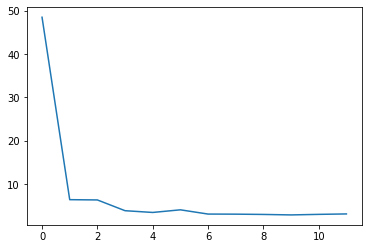

In [28]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_convLSTM = build_convLSTM(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_lstm_acc) and (history['val_roc_auc'] > body_best_lstm_auc):
                                body_best_lstm_acc = history['val_accuracy']
                                body_best_lstm_auc = history['val_roc_auc']
                                body_lstm_loss = history['loss']
                                body_best_lstm_model = body_convLSTM
                                body_lstm_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

#### Train RCNN

In [ ]:
body_best_rcnn_acc = 0.0
body_best_rcnn_auc = 0.0
body_rcnn_loss = float("inf")
body_best_rcnn_model = None
body_rcnn_values = { 'batch_size': 0, 'activation': '', 'neurons': 0, 'kernel_size': 0, 'kernel_initializer': '', 'dropout': float("inf") }

Epoch 1/15
11/11 - 8s - loss: 67.7453 - accuracy: 0.3600 - auc_72: 0.5954 - precision_72: 0.3594 - recall_72: 0.3543 - f1_score: 0.2404 - val_loss: 108.9195 - val_accuracy: 0.1200 - val_auc_72: 0.4133 - val_precision_72: 0.1200 - val_recall_72: 0.1200 - val_f1_score: 0.0536 - 8s/epoch - 704ms/step
Epoch 2/15
11/11 - 0s - loss: 62.5873 - accuracy: 0.4257 - auc_72: 0.6584 - precision_72: 0.4265 - recall_72: 0.4229 - f1_score: 0.2860 - val_loss: 56.9569 - val_accuracy: 0.4514 - val_auc_72: 0.6343 - val_precision_72: 0.4514 - val_recall_72: 0.4514 - val_f1_score: 0.1555 - 333ms/epoch - 30ms/step
Epoch 3/15
11/11 - 0s - loss: 11.3489 - accuracy: 0.3829 - auc_72: 0.6254 - precision_72: 0.3833 - recall_72: 0.3800 - f1_score: 0.2819 - val_loss: 20.5780 - val_accuracy: 0.3714 - val_auc_72: 0.5818 - val_precision_72: 0.3714 - val_recall_72: 0.3714 - val_f1_score: 0.1835 - 364ms/epoch - 33ms/step
Epoch 4/15
11/11 - 0s - loss: 11.1064 - accuracy: 0.3714 - auc_72: 0.6220 - precision_72: 0.3725 - re

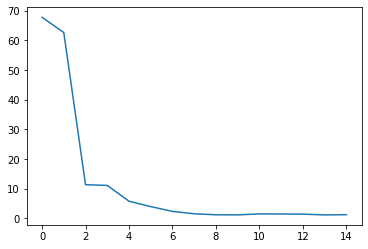

Epoch 1/15
11/11 - 7s - loss: 65.3842 - accuracy: 0.3514 - auc_73: 0.5779 - precision_73: 0.3557 - recall_73: 0.3486 - f1_score: 0.2346 - val_loss: 126.8788 - val_accuracy: 0.5314 - val_auc_73: 0.6876 - val_precision_73: 0.5314 - val_recall_73: 0.5314 - val_f1_score: 0.1735 - 7s/epoch - 654ms/step
Epoch 2/15
11/11 - 0s - loss: 13.8606 - accuracy: 0.3743 - auc_73: 0.6103 - precision_73: 0.3775 - recall_73: 0.3743 - f1_score: 0.2904 - val_loss: 28.3765 - val_accuracy: 0.4743 - val_auc_73: 0.6597 - val_precision_73: 0.4743 - val_recall_73: 0.4743 - val_f1_score: 0.1621 - 359ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 36.8655 - accuracy: 0.3429 - auc_73: 0.6080 - precision_73: 0.3420 - recall_73: 0.3371 - f1_score: 0.2356 - val_loss: 38.1507 - val_accuracy: 0.4400 - val_auc_73: 0.6263 - val_precision_73: 0.4400 - val_recall_73: 0.4400 - val_f1_score: 0.1540 - 362ms/epoch - 33ms/step
Epoch 4/15
11/11 - 0s - loss: 7.9378 - accuracy: 0.4286 - auc_73: 0.6856 - precision_73: 0.4290 - rec

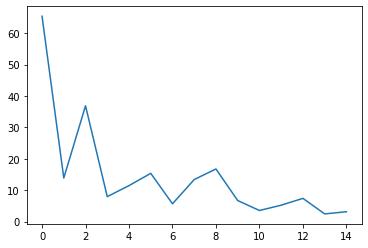

Epoch 1/15
11/11 - 13s - loss: 85.1799 - accuracy: 0.4029 - auc_74: 0.6146 - precision_74: 0.4076 - recall_74: 0.3971 - f1_score: 0.2860 - val_loss: 1113.6249 - val_accuracy: 0.0000e+00 - val_auc_74: 0.3333 - val_precision_74: 0.0000e+00 - val_recall_74: 0.0000e+00 - val_f1_score: 0.0000e+00 - 13s/epoch - 1s/step
Epoch 2/15
11/11 - 0s - loss: 32.2794 - accuracy: 0.3543 - auc_74: 0.5847 - precision_74: 0.3524 - recall_74: 0.3514 - f1_score: 0.2688 - val_loss: 289.8771 - val_accuracy: 0.3314 - val_auc_74: 0.5543 - val_precision_74: 0.3314 - val_recall_74: 0.3314 - val_f1_score: 0.1245 - 316ms/epoch - 29ms/step
Epoch 3/15
11/11 - 0s - loss: 41.5136 - accuracy: 0.3514 - auc_74: 0.5791 - precision_74: 0.3534 - recall_74: 0.3514 - f1_score: 0.2647 - val_loss: 214.8295 - val_accuracy: 0.6000 - val_auc_74: 0.7333 - val_precision_74: 0.6000 - val_recall_74: 0.6000 - val_f1_score: 0.1875 - 315ms/epoch - 29ms/step
Epoch 4/15
11/11 - 0s - loss: 24.9294 - accuracy: 0.4200 - auc_74: 0.6299 - precisi

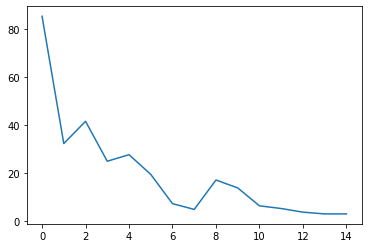

In [29]:
for b in batch_sizes:
    for act in activation:
        for n in neurons:
            for s in kernel_size:
                for init in kernel_initializer:
                    for d in dropout:
                        print('Batch size', b, 'Activation', act, 'Neurons', n, 'Kernel size', s, 'Kernel initializer', init, 'Dropout', d)
                        for train_index, val_index in kf.split(full_body_X):
                            X_train, X_val = full_body_X[train_index], full_body_X[val_index]
                            y_train, y_val = full_body_y[train_index], full_body_y[val_index]
                            body_RCNN = build_RCNN(body_features, n_length, body_outputs, neurons=n, kernel_size=s, activation=act, kernel_initializer=init, dropout=d)
                            history = train(body_RCNN, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=b, class_weight=class_weight)
                            if (history['val_accuracy'] > body_best_rcnn_acc) and (history['val_roc_auc'] > body_best_rcnn_auc):
                                body_best_rcnn_acc = history['val_accuracy']
                                body_best_rcnn_auc = history['val_roc_auc']
                                body_rcnn_loss = history['loss']
                                body_best_rcnn_model = body_RCNN
                                body_rcnn_values = { 'batch_size': b, 'activation': act, 'neurons': n, 'kernel_size': s, 'kernel_initializer': init, 'dropout': d }

### 1.2 Face modality (Action units)

In [30]:
umild, lmoderate, lmild, umoderate = np.sum(face_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

#### Train BiLSTM

In [ ]:
# TODO: 

Kernel size: 3
Epoch 1/15
11/11 - 72s - loss: 3.1986 - accuracy: 0.5015 - auc_75: 0.7039 - precision_75: 0.8750 - recall_75: 0.0206 - f1_score: 0.2050 - val_loss: 1.1691 - val_accuracy: 0.4706 - val_auc_75: 0.7746 - val_precision_75: 0.6429 - val_recall_75: 0.0529 - val_f1_score: 0.1600 - 72s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.0017 - accuracy: 0.5015 - auc_75: 0.7250 - precision_75: 0.7000 - recall_75: 0.0413 - f1_score: 0.2921 - val_loss: 1.2841 - val_accuracy: 0.3412 - val_auc_75: 0.6427 - val_precision_75: 0.5085 - val_recall_75: 0.1765 - val_f1_score: 0.1862 - 3s/epoch - 230ms/step
Epoch 3/15
11/11 - 2s - loss: 2.8833 - accuracy: 0.3451 - auc_75: 0.6862 - precision_75: 0.7857 - recall_75: 0.0649 - f1_score: 0.2024 - val_loss: 1.2214 - val_accuracy: 0.2294 - val_auc_75: 0.6595 - val_precision_75: 0.0000e+00 - val_recall_75: 0.0000e+00 - val_f1_score: 0.1791 - 2s/epoch - 227ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8582 - accuracy: 0.3156 - auc_75: 0.6568 - precision_75: 0

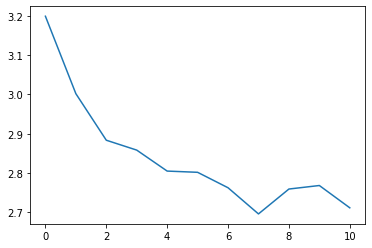

Epoch 1/15
11/11 - 66s - loss: 3.7414 - accuracy: 0.3923 - auc_76: 0.6615 - precision_76: 0.3333 - recall_76: 0.0059 - f1_score: 0.2482 - val_loss: 1.2109 - val_accuracy: 0.0941 - val_auc_76: 0.5879 - val_precision_76: 0.0000e+00 - val_recall_76: 0.0000e+00 - val_f1_score: 0.0430 - 66s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5951 - accuracy: 0.1593 - auc_76: 0.5979 - precision_76: 0.0000e+00 - recall_76: 0.0000e+00 - f1_score: 0.1116 - val_loss: 1.2819 - val_accuracy: 0.4824 - val_auc_76: 0.7657 - val_precision_76: 0.0000e+00 - val_recall_76: 0.0000e+00 - val_f1_score: 0.2531 - 3s/epoch - 259ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5464 - accuracy: 0.4956 - auc_76: 0.7882 - precision_76: 0.0000e+00 - recall_76: 0.0000e+00 - f1_score: 0.2586 - val_loss: 1.2388 - val_accuracy: 0.5059 - val_auc_76: 0.7901 - val_precision_76: 0.6667 - val_recall_76: 0.0235 - val_f1_score: 0.2590 - 3s/epoch - 256ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4939 - accuracy: 0.4867 - auc_76: 0.7881 - precis

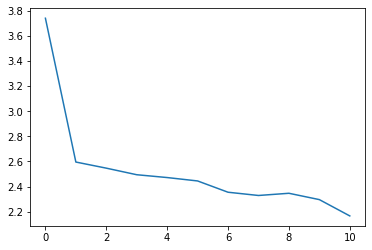

Epoch 1/15
11/11 - 72s - loss: 2.6104 - accuracy: 0.4765 - auc_77: 0.6800 - precision_77: 0.5000 - recall_77: 0.0176 - f1_score: 0.2116 - val_loss: 1.1564 - val_accuracy: 0.5503 - val_auc_77: 0.8206 - val_precision_77: 0.6154 - val_recall_77: 0.0473 - val_f1_score: 0.1775 - 72s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.5984 - accuracy: 0.4912 - auc_77: 0.7611 - precision_77: 0.5000 - recall_77: 0.0059 - f1_score: 0.2079 - val_loss: 1.2240 - val_accuracy: 0.5385 - val_auc_77: 0.7407 - val_precision_77: 0.0000e+00 - val_recall_77: 0.0000e+00 - val_f1_score: 0.2292 - 3s/epoch - 228ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8095 - accuracy: 0.4235 - auc_77: 0.7553 - precision_77: 0.4762 - recall_77: 0.0294 - f1_score: 0.1955 - val_loss: 1.1653 - val_accuracy: 0.2781 - val_auc_77: 0.6721 - val_precision_77: 0.2000 - val_recall_77: 0.0059 - val_f1_score: 0.1286 - 3s/epoch - 258ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4274 - accuracy: 0.2647 - auc_77: 0.6230 - precision_77: 0.0000e+00 - rec

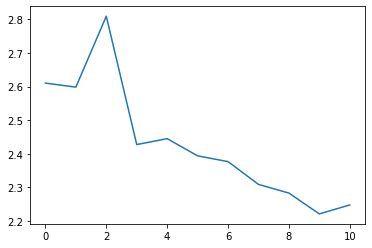

Kernel size: 5
Epoch 1/15
11/11 - 68s - loss: 3.3788 - accuracy: 0.3186 - auc_78: 0.6360 - precision_78: 0.3636 - recall_78: 0.0236 - f1_score: 0.2127 - val_loss: 1.2613 - val_accuracy: 0.1000 - val_auc_78: 0.5586 - val_precision_78: 0.0000e+00 - val_recall_78: 0.0000e+00 - val_f1_score: 0.0455 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.1641 - accuracy: 0.2507 - auc_78: 0.6215 - precision_78: 0.0000e+00 - recall_78: 0.0000e+00 - f1_score: 0.1441 - val_loss: 1.3579 - val_accuracy: 0.4294 - val_auc_78: 0.6362 - val_precision_78: 0.0000e+00 - val_recall_78: 0.0000e+00 - val_f1_score: 0.1508 - 3s/epoch - 258ms/step
Epoch 3/15
11/11 - 3s - loss: 3.0253 - accuracy: 0.3009 - auc_78: 0.6583 - precision_78: 0.0769 - recall_78: 0.0029 - f1_score: 0.1941 - val_loss: 1.2763 - val_accuracy: 0.2294 - val_auc_78: 0.6450 - val_precision_78: 0.0000e+00 - val_recall_78: 0.0000e+00 - val_f1_score: 0.1574 - 3s/epoch - 251ms/step
Epoch 4/15
11/11 - 3s - loss: 2.9240 - accuracy: 0.1298 - auc_78: 

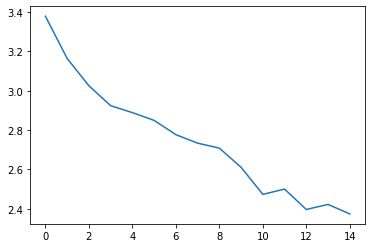

Epoch 1/15
11/11 - 78s - loss: 2.5345 - accuracy: 0.4484 - auc_79: 0.7255 - precision_79: 0.4000 - recall_79: 0.0177 - f1_score: 0.1943 - val_loss: 1.1112 - val_accuracy: 0.3353 - val_auc_79: 0.7701 - val_precision_79: 0.1538 - val_recall_79: 0.0235 - val_f1_score: 0.1333 - 78s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.7789 - accuracy: 0.4307 - auc_79: 0.7737 - precision_79: 0.4286 - recall_79: 0.0265 - f1_score: 0.1919 - val_loss: 1.2340 - val_accuracy: 0.0941 - val_auc_79: 0.5761 - val_precision_79: 0.0000e+00 - val_recall_79: 0.0000e+00 - val_f1_score: 0.0430 - 3s/epoch - 248ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5862 - accuracy: 0.0944 - auc_79: 0.5723 - precision_79: 0.0000e+00 - recall_79: 0.0000e+00 - f1_score: 0.0431 - val_loss: 1.3163 - val_accuracy: 0.0941 - val_auc_79: 0.5518 - val_precision_79: 0.0000e+00 - val_recall_79: 0.0000e+00 - val_f1_score: 0.0430 - 3s/epoch - 248ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5246 - accuracy: 0.1681 - auc_79: 0.6163 - precision_79: 

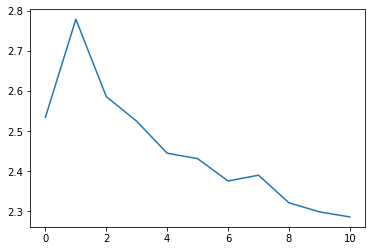

Epoch 1/15
11/11 - 68s - loss: 2.6443 - accuracy: 0.3588 - auc_80: 0.6565 - precision_80: 0.3333 - recall_80: 0.0088 - f1_score: 0.2227 - val_loss: 1.3305 - val_accuracy: 0.0888 - val_auc_80: 0.5229 - val_precision_80: 0.0000e+00 - val_recall_80: 0.0000e+00 - val_f1_score: 0.0408 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.4992 - accuracy: 0.2118 - auc_80: 0.6232 - precision_80: 0.2692 - recall_80: 0.0206 - f1_score: 0.1347 - val_loss: 1.0841 - val_accuracy: 0.5503 - val_auc_80: 0.7976 - val_precision_80: 0.6667 - val_recall_80: 0.2604 - val_f1_score: 0.1775 - 3s/epoch - 259ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5316 - accuracy: 0.4471 - auc_80: 0.7573 - precision_80: 0.3846 - recall_80: 0.0441 - f1_score: 0.2280 - val_loss: 1.2601 - val_accuracy: 0.2781 - val_auc_80: 0.6722 - val_precision_80: 0.0000e+00 - val_recall_80: 0.0000e+00 - val_f1_score: 0.2023 - 3s/epoch - 248ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4665 - accuracy: 0.3324 - auc_80: 0.6774 - precision_80: 0.0000e+

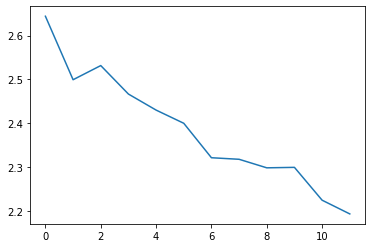

In [31]:
for size in kernel_size:
    print('Kernel size:', size)
    for train_index, val_index in kf.split(face_X):
        X_train, X_val = face_X[train_index], face_X[val_index]
        y_train, y_val = face_y[train_index], face_y[val_index]
        body_biConvLSTM = build_biLSTM(face_features, n_length, face_outputs, kernel_size=size)
        history = train(body_biConvLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
        plt.plot(history.history['loss'])
        plt.show()

Epoch 1/15
11/11 - 69s - loss: 3.9311 - accuracy: 0.4189 - auc_81: 0.7199 - precision_81: 0.6774 - recall_81: 0.0619 - f1_score: 0.2067 - val_loss: 1.2327 - val_accuracy: 0.4294 - val_auc_81: 0.7725 - val_precision_81: 0.0000e+00 - val_recall_81: 0.0000e+00 - val_f1_score: 0.1502 - 69s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.1584 - accuracy: 0.1799 - auc_81: 0.6385 - precision_81: 0.0000e+00 - recall_81: 0.0000e+00 - f1_score: 0.1338 - val_loss: 1.3839 - val_accuracy: 0.1118 - val_auc_81: 0.5096 - val_precision_81: 0.0000e+00 - val_recall_81: 0.0000e+00 - val_f1_score: 0.0594 - 3s/epoch - 260ms/step
Epoch 3/15
11/11 - 3s - loss: 3.0732 - accuracy: 0.2714 - auc_81: 0.6225 - precision_81: 0.0000e+00 - recall_81: 0.0000e+00 - f1_score: 0.1576 - val_loss: 1.3416 - val_accuracy: 0.3059 - val_auc_81: 0.6591 - val_precision_81: 0.0000e+00 - val_recall_81: 0.0000e+00 - val_f1_score: 0.1718 - 3s/epoch - 253ms/step
Epoch 4/15
11/11 - 3s - loss: 2.9862 - accuracy: 0.3894 - auc_81: 0.7354 

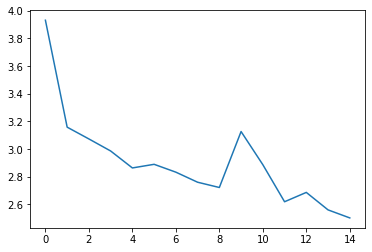

Epoch 1/15
11/11 - 61s - loss: 2.8604 - accuracy: 0.2212 - auc_82: 0.6248 - precision_82: 0.0000e+00 - recall_82: 0.0000e+00 - f1_score: 0.1646 - val_loss: 1.2088 - val_accuracy: 0.3412 - val_auc_82: 0.7598 - val_precision_82: 0.0000e+00 - val_recall_82: 0.0000e+00 - val_f1_score: 0.1272 - 61s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5380 - accuracy: 0.4277 - auc_82: 0.7754 - precision_82: 0.5000 - recall_82: 0.0118 - f1_score: 0.1992 - val_loss: 1.2499 - val_accuracy: 0.5000 - val_auc_82: 0.7781 - val_precision_82: 1.0000 - val_recall_82: 0.0059 - val_f1_score: 0.2596 - 3s/epoch - 242ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4908 - accuracy: 0.2212 - auc_82: 0.6448 - precision_82: 0.3750 - recall_82: 0.0088 - f1_score: 0.1615 - val_loss: 1.1814 - val_accuracy: 0.4765 - val_auc_82: 0.7668 - val_precision_82: 0.7353 - val_recall_82: 0.1471 - val_f1_score: 0.2712 - 3s/epoch - 236ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4377 - accuracy: 0.4041 - auc_82: 0.7305 - precision_82: 0.5345 -

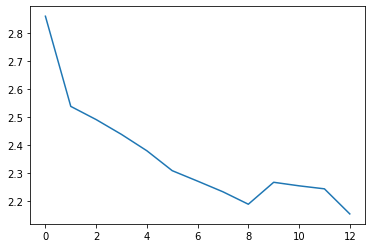

Epoch 1/15
11/11 - 68s - loss: 2.5304 - accuracy: 0.4941 - auc_83: 0.6865 - precision_83: 0.6250 - recall_83: 0.0294 - f1_score: 0.1817 - val_loss: 1.0612 - val_accuracy: 0.5503 - val_auc_83: 0.8078 - val_precision_83: 0.6667 - val_recall_83: 0.0237 - val_f1_score: 0.1775 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.4395 - accuracy: 0.2382 - auc_83: 0.6012 - precision_83: 0.1136 - recall_83: 0.0147 - f1_score: 0.1785 - val_loss: 1.1677 - val_accuracy: 0.0888 - val_auc_83: 0.5835 - val_precision_83: 0.0000e+00 - val_recall_83: 0.0000e+00 - val_f1_score: 0.0408 - 3s/epoch - 248ms/step
Epoch 3/15
11/11 - 3s - loss: 2.7438 - accuracy: 0.3765 - auc_83: 0.6825 - precision_83: 0.0000e+00 - recall_83: 0.0000e+00 - f1_score: 0.1834 - val_loss: 1.2492 - val_accuracy: 0.5503 - val_auc_83: 0.7777 - val_precision_83: 0.0000e+00 - val_recall_83: 0.0000e+00 - val_f1_score: 0.1775 - 3s/epoch - 253ms/step
Epoch 4/15
11/11 - 3s - loss: 2.6391 - accuracy: 0.5147 - auc_83: 0.7393 - precision_83: 

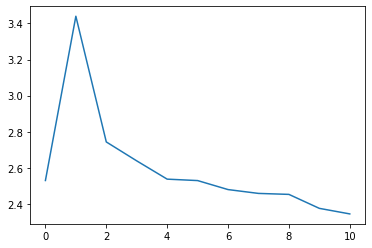

Epoch 1/15
11/11 - 76s - loss: 3.1890 - accuracy: 0.5339 - auc_84: 0.7137 - precision_84: 0.6071 - recall_84: 0.0501 - f1_score: 0.2219 - val_loss: 1.2256 - val_accuracy: 0.4706 - val_auc_84: 0.7322 - val_precision_84: 0.7500 - val_recall_84: 0.0176 - val_f1_score: 0.1600 - 76s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.9720 - accuracy: 0.4808 - auc_84: 0.7739 - precision_84: 0.8333 - recall_84: 0.0147 - f1_score: 0.1933 - val_loss: 1.2298 - val_accuracy: 0.2294 - val_auc_84: 0.6643 - val_precision_84: 0.0000e+00 - val_recall_84: 0.0000e+00 - val_f1_score: 0.1246 - 3s/epoch - 229ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8687 - accuracy: 0.2950 - auc_84: 0.6927 - precision_84: 0.5192 - recall_84: 0.0796 - f1_score: 0.1775 - val_loss: 1.3163 - val_accuracy: 0.0941 - val_auc_84: 0.5477 - val_precision_84: 0.0714 - val_recall_84: 0.0059 - val_f1_score: 0.0845 - 3s/epoch - 248ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8047 - accuracy: 0.2861 - auc_84: 0.6895 - precision_84: 0.5667 - recall_

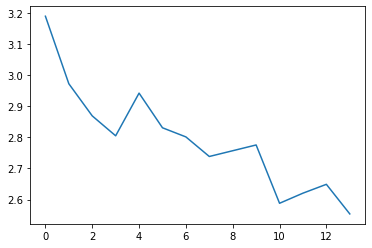

Epoch 1/15
11/11 - 73s - loss: 2.4602 - accuracy: 0.4454 - auc_85: 0.7356 - precision_85: 0.4444 - recall_85: 0.0118 - f1_score: 0.2451 - val_loss: 1.1688 - val_accuracy: 0.3412 - val_auc_85: 0.6747 - val_precision_85: 0.1429 - val_recall_85: 0.0353 - val_f1_score: 0.1272 - 73s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.6036 - accuracy: 0.3156 - auc_85: 0.7017 - precision_85: 0.4545 - recall_85: 0.0442 - f1_score: 0.2022 - val_loss: 1.1247 - val_accuracy: 0.3412 - val_auc_85: 0.7523 - val_precision_85: 0.0000e+00 - val_recall_85: 0.0000e+00 - val_f1_score: 0.1272 - 3s/epoch - 255ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5629 - accuracy: 0.2301 - auc_85: 0.6260 - precision_85: 0.0000e+00 - recall_85: 0.0000e+00 - f1_score: 0.1468 - val_loss: 1.2618 - val_accuracy: 0.1353 - val_auc_85: 0.5870 - val_precision_85: 0.0000e+00 - val_recall_85: 0.0000e+00 - val_f1_score: 0.0962 - 3s/epoch - 263ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5636 - accuracy: 0.3923 - auc_85: 0.7183 - precision_85: 

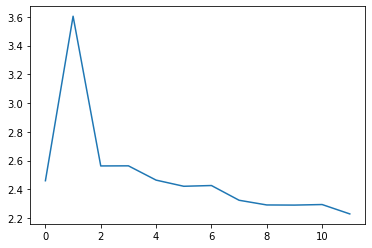

Epoch 1/15
11/11 - 65s - loss: 3.4986 - accuracy: 0.4059 - auc_86: 0.6724 - precision_86: 0.3333 - recall_86: 0.0059 - f1_score: 0.2295 - val_loss: 1.1658 - val_accuracy: 0.0888 - val_auc_86: 0.6188 - val_precision_86: 0.0000e+00 - val_recall_86: 0.0000e+00 - val_f1_score: 0.0410 - 65s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.9634 - accuracy: 0.0971 - auc_86: 0.6123 - precision_86: 0.0000e+00 - recall_86: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.3471 - val_accuracy: 0.0888 - val_auc_86: 0.5821 - val_precision_86: 0.0000e+00 - val_recall_86: 0.0000e+00 - val_f1_score: 0.0408 - 3s/epoch - 249ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5804 - accuracy: 0.0971 - auc_86: 0.5867 - precision_86: 0.0000e+00 - recall_86: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.2985 - val_accuracy: 0.0888 - val_auc_86: 0.6192 - val_precision_86: 0.0000e+00 - val_recall_86: 0.0000e+00 - val_f1_score: 0.0408 - 3s/epoch - 237ms/step
Epoch 4/15
11/11 - 3s - loss: 2.6476 - accuracy: 0.2088 - auc_86: 0.6378 

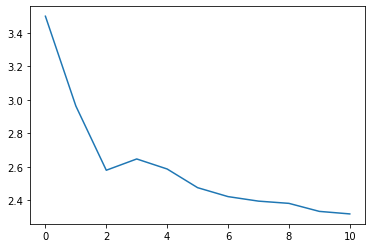

Epoch 1/15
11/11 - 80s - loss: 3.0300 - accuracy: 0.5133 - auc_87: 0.7233 - precision_87: 0.7586 - recall_87: 0.0649 - f1_score: 0.2043 - val_loss: 1.1999 - val_accuracy: 0.4647 - val_auc_87: 0.7202 - val_precision_87: 0.5556 - val_recall_87: 0.1176 - val_f1_score: 0.1586 - 80s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.9487 - accuracy: 0.3097 - auc_87: 0.6889 - precision_87: 0.5517 - recall_87: 0.0472 - f1_score: 0.1731 - val_loss: 1.2955 - val_accuracy: 0.0706 - val_auc_87: 0.5644 - val_precision_87: 0.0000e+00 - val_recall_87: 0.0000e+00 - val_f1_score: 0.0628 - 3s/epoch - 236ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8649 - accuracy: 0.3009 - auc_87: 0.6610 - precision_87: 0.8182 - recall_87: 0.0265 - f1_score: 0.1934 - val_loss: 1.2327 - val_accuracy: 0.2647 - val_auc_87: 0.6114 - val_precision_87: 0.4655 - val_recall_87: 0.1588 - val_f1_score: 0.1368 - 3s/epoch - 236ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8437 - accuracy: 0.3540 - auc_87: 0.7028 - precision_87: 0.6447 - recall_

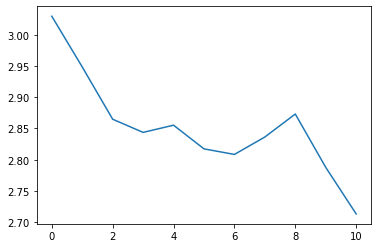

Epoch 1/15
11/11 - 73s - loss: 3.0050 - accuracy: 0.4041 - auc_88: 0.7059 - precision_88: 0.5294 - recall_88: 0.0265 - f1_score: 0.2093 - val_loss: 1.2484 - val_accuracy: 0.0941 - val_auc_88: 0.5093 - val_precision_88: 0.0000e+00 - val_recall_88: 0.0000e+00 - val_f1_score: 0.0430 - 73s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.5388 - accuracy: 0.3097 - auc_88: 0.5812 - precision_88: 0.0000e+00 - recall_88: 0.0000e+00 - f1_score: 0.1523 - val_loss: 1.2960 - val_accuracy: 0.3412 - val_auc_88: 0.5719 - val_precision_88: 0.0000e+00 - val_recall_88: 0.0000e+00 - val_f1_score: 0.1272 - 3s/epoch - 256ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4705 - accuracy: 0.4395 - auc_88: 0.6791 - precision_88: 0.3333 - recall_88: 0.0029 - f1_score: 0.2198 - val_loss: 1.1830 - val_accuracy: 0.4588 - val_auc_88: 0.7668 - val_precision_88: 0.3571 - val_recall_88: 0.0294 - val_f1_score: 0.2430 - 3s/epoch - 265ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5056 - accuracy: 0.3923 - auc_88: 0.6647 - precision_88: 

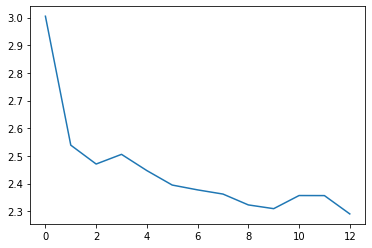

Epoch 1/15
11/11 - 82s - loss: 2.5523 - accuracy: 0.5118 - auc_89: 0.7728 - precision_89: 0.6000 - recall_89: 0.0353 - f1_score: 0.2715 - val_loss: 1.1814 - val_accuracy: 0.3550 - val_auc_89: 0.6478 - val_precision_89: 0.0000e+00 - val_recall_89: 0.0000e+00 - val_f1_score: 0.1310 - 82s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.1258 - accuracy: 0.2794 - auc_89: 0.5841 - precision_89: 0.0000e+00 - recall_89: 0.0000e+00 - f1_score: 0.1617 - val_loss: 1.2751 - val_accuracy: 0.0888 - val_auc_89: 0.5094 - val_precision_89: 0.0000e+00 - val_recall_89: 0.0000e+00 - val_f1_score: 0.0408 - 3s/epoch - 241ms/step
Epoch 3/15
11/11 - 3s - loss: 2.6366 - accuracy: 0.0971 - auc_89: 0.5345 - precision_89: 0.0000e+00 - recall_89: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.2856 - val_accuracy: 0.0888 - val_auc_89: 0.5585 - val_precision_89: 0.0000e+00 - val_recall_89: 0.0000e+00 - val_f1_score: 0.0408 - 3s/epoch - 255ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5539 - accuracy: 0.1000 - auc_89: 0.5752 

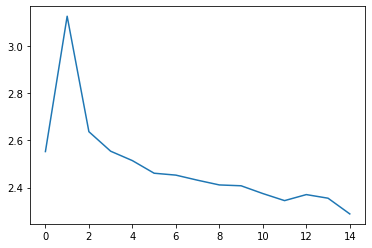

In [32]:
for d in dropout:
    for train_index, val_index in kf.split(face_X):
        X_train, X_val = face_X[train_index], face_X[val_index]
        y_train, y_val = face_y[train_index], face_y[val_index]
        body_biConvLSTM = build_biConvLSTM(face_features, n_length, face_outputs, dropout=d)
        history = train(body_biConvLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
        plt.plot(history.history['loss'])
        plt.show()

Kernel initializer: glorot_uniform
Epoch 1/15
11/11 - 69s - loss: 3.1269 - accuracy: 0.5162 - auc_90: 0.7739 - precision_90: 1.0000 - recall_90: 0.0088 - f1_score: 0.2338 - val_loss: 1.2690 - val_accuracy: 0.4706 - val_auc_90: 0.6608 - val_precision_90: 0.5333 - val_recall_90: 0.0471 - val_f1_score: 0.1600 - 69s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.0136 - accuracy: 0.4248 - auc_90: 0.7346 - precision_90: 0.5854 - recall_90: 0.0708 - f1_score: 0.2390 - val_loss: 1.2911 - val_accuracy: 0.2588 - val_auc_90: 0.5951 - val_precision_90: 0.0000e+00 - val_recall_90: 0.0000e+00 - val_f1_score: 0.1576 - 3s/epoch - 274ms/step
Epoch 3/15
11/11 - 3s - loss: 2.9200 - accuracy: 0.3215 - auc_90: 0.6297 - precision_90: 0.8125 - recall_90: 0.0383 - f1_score: 0.1876 - val_loss: 1.2291 - val_accuracy: 0.2353 - val_auc_90: 0.6579 - val_precision_90: 0.6190 - val_recall_90: 0.0765 - val_f1_score: 0.1327 - 3s/epoch - 267ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8753 - accuracy: 0.3658 - auc_90: 0.73

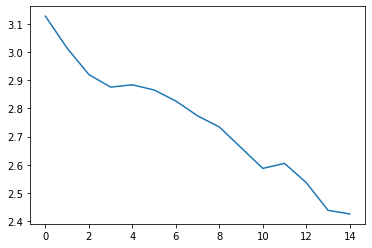

Epoch 1/15
11/11 - 70s - loss: 2.8380 - accuracy: 0.4897 - auc_91: 0.6855 - precision_91: 0.5200 - recall_91: 0.0383 - f1_score: 0.1920 - val_loss: 1.2698 - val_accuracy: 0.3412 - val_auc_91: 0.7719 - val_precision_91: 0.0000e+00 - val_recall_91: 0.0000e+00 - val_f1_score: 0.1272 - 70s/epoch - 6s/step
Epoch 2/15
11/11 - 2s - loss: 2.5394 - accuracy: 0.3982 - auc_91: 0.6536 - precision_91: 0.0000e+00 - recall_91: 0.0000e+00 - f1_score: 0.1699 - val_loss: 1.2764 - val_accuracy: 0.3412 - val_auc_91: 0.6441 - val_precision_91: 0.1000 - val_recall_91: 0.0059 - val_f1_score: 0.1504 - 2s/epoch - 226ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4647 - accuracy: 0.3569 - auc_91: 0.6824 - precision_91: 0.5000 - recall_91: 0.0383 - f1_score: 0.2476 - val_loss: 1.1974 - val_accuracy: 0.3412 - val_auc_91: 0.7124 - val_precision_91: 0.7600 - val_recall_91: 0.1118 - val_f1_score: 0.1930 - 3s/epoch - 237ms/step
Epoch 4/15
11/11 - 3s - loss: 2.3796 - accuracy: 0.2979 - auc_91: 0.6976 - precision_91: 0.4000 -

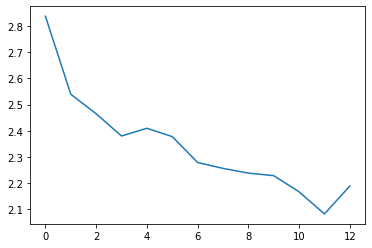

Epoch 1/15
11/11 - 74s - loss: 3.7399 - accuracy: 0.3118 - auc_92: 0.6468 - precision_92: 0.6562 - recall_92: 0.0618 - f1_score: 0.2267 - val_loss: 1.0441 - val_accuracy: 0.5503 - val_auc_92: 0.8254 - val_precision_92: 0.0000e+00 - val_recall_92: 0.0000e+00 - val_f1_score: 0.1775 - 74s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.9284 - accuracy: 0.4529 - auc_92: 0.7697 - precision_92: 0.0000e+00 - recall_92: 0.0000e+00 - f1_score: 0.2356 - val_loss: 1.3098 - val_accuracy: 0.3550 - val_auc_92: 0.7390 - val_precision_92: 0.0000e+00 - val_recall_92: 0.0000e+00 - val_f1_score: 0.1310 - 3s/epoch - 256ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5701 - accuracy: 0.4088 - auc_92: 0.7124 - precision_92: 0.0000e+00 - recall_92: 0.0000e+00 - f1_score: 0.1635 - val_loss: 1.2507 - val_accuracy: 0.5385 - val_auc_92: 0.7307 - val_precision_92: 0.0000e+00 - val_recall_92: 0.0000e+00 - val_f1_score: 0.2788 - 3s/epoch - 256ms/step
Epoch 4/15
11/11 - 3s - loss: 2.6170 - accuracy: 0.3706 - auc_92: 0.6845 

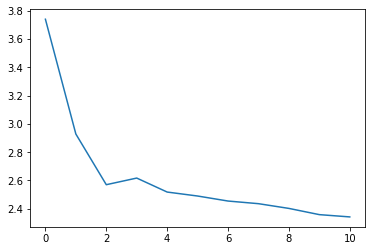

Kernel initializer: glorot_normal
Epoch 1/15
11/11 - 73s - loss: 3.5941 - accuracy: 0.5103 - auc_93: 0.7743 - precision_93: 0.6842 - recall_93: 0.0383 - f1_score: 0.2248 - val_loss: 1.2950 - val_accuracy: 0.4824 - val_auc_93: 0.7360 - val_precision_93: 0.0000e+00 - val_recall_93: 0.0000e+00 - val_f1_score: 0.2529 - 73s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.0512 - accuracy: 0.3009 - auc_93: 0.6637 - precision_93: 0.0000e+00 - recall_93: 0.0000e+00 - f1_score: 0.2143 - val_loss: 1.3689 - val_accuracy: 0.2647 - val_auc_93: 0.5786 - val_precision_93: 0.0000e+00 - val_recall_93: 0.0000e+00 - val_f1_score: 0.1559 - 3s/epoch - 241ms/step
Epoch 3/15
11/11 - 3s - loss: 3.0019 - accuracy: 0.4366 - auc_93: 0.6865 - precision_93: 0.7778 - recall_93: 0.0826 - f1_score: 0.2278 - val_loss: 1.2501 - val_accuracy: 0.4706 - val_auc_93: 0.6864 - val_precision_93: 0.5306 - val_recall_93: 0.1529 - val_f1_score: 0.1600 - 3s/epoch - 250ms/step
Epoch 4/15
11/11 - 3s - loss: 2.9087 - accuracy: 0.2330

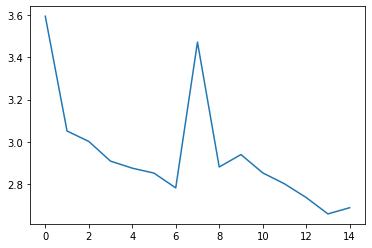

Epoch 1/15
11/11 - 65s - loss: 2.5310 - accuracy: 0.3864 - auc_94: 0.7461 - precision_94: 0.0000e+00 - recall_94: 0.0000e+00 - f1_score: 0.2246 - val_loss: 1.1318 - val_accuracy: 0.3353 - val_auc_94: 0.7637 - val_precision_94: 0.1429 - val_recall_94: 0.0118 - val_f1_score: 0.1256 - 65s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.8254 - accuracy: 0.3186 - auc_94: 0.6942 - precision_94: 0.1250 - recall_94: 0.0059 - f1_score: 0.1738 - val_loss: 1.1927 - val_accuracy: 0.3353 - val_auc_94: 0.7622 - val_precision_94: 0.1250 - val_recall_94: 0.0059 - val_f1_score: 0.1295 - 3s/epoch - 257ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4677 - accuracy: 0.4661 - auc_94: 0.7774 - precision_94: 0.6800 - recall_94: 0.0501 - f1_score: 0.2689 - val_loss: 1.1798 - val_accuracy: 0.3471 - val_auc_94: 0.7420 - val_precision_94: 0.7647 - val_recall_94: 0.0765 - val_f1_score: 0.2069 - 3s/epoch - 260ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4254 - accuracy: 0.3451 - auc_94: 0.7361 - precision_94: 0.5373 - recall_

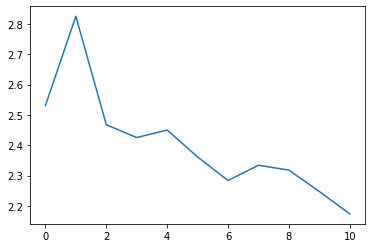

Epoch 1/15
11/11 - 67s - loss: 2.5712 - accuracy: 0.2500 - auc_95: 0.6192 - precision_95: 0.0000e+00 - recall_95: 0.0000e+00 - f1_score: 0.1515 - val_loss: 1.1554 - val_accuracy: 0.5503 - val_auc_95: 0.7193 - val_precision_95: 0.0000e+00 - val_recall_95: 0.0000e+00 - val_f1_score: 0.1775 - 67s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.5248 - accuracy: 0.2588 - auc_95: 0.6415 - precision_95: 0.0667 - recall_95: 0.0059 - f1_score: 0.1465 - val_loss: 1.0268 - val_accuracy: 0.5503 - val_auc_95: 0.8104 - val_precision_95: 0.0000e+00 - val_recall_95: 0.0000e+00 - val_f1_score: 0.1775 - 3s/epoch - 253ms/step
Epoch 3/15
11/11 - 3s - loss: 2.6942 - accuracy: 0.5147 - auc_95: 0.7905 - precision_95: 0.0000e+00 - recall_95: 0.0000e+00 - f1_score: 0.1699 - val_loss: 1.1925 - val_accuracy: 0.5503 - val_auc_95: 0.7946 - val_precision_95: 0.0000e+00 - val_recall_95: 0.0000e+00 - val_f1_score: 0.1775 - 3s/epoch - 256ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5535 - accuracy: 0.5176 - auc_95: 0.7846 

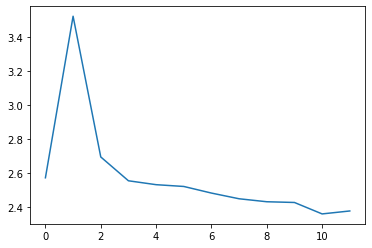

Kernel initializer: he_uniform
Epoch 1/15
11/11 - 68s - loss: 3.1568 - accuracy: 0.4277 - auc_96: 0.7252 - precision_96: 0.4730 - recall_96: 0.1032 - f1_score: 0.2582 - val_loss: 1.2530 - val_accuracy: 0.4353 - val_auc_96: 0.7518 - val_precision_96: 0.3333 - val_recall_96: 0.0176 - val_f1_score: 0.1570 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.9590 - accuracy: 0.3687 - auc_96: 0.7601 - precision_96: 0.8400 - recall_96: 0.0619 - f1_score: 0.2037 - val_loss: 1.2331 - val_accuracy: 0.2412 - val_auc_96: 0.6690 - val_precision_96: 0.6667 - val_recall_96: 0.0235 - val_f1_score: 0.1563 - 3s/epoch - 233ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8374 - accuracy: 0.3569 - auc_96: 0.7127 - precision_96: 0.7083 - recall_96: 0.1003 - f1_score: 0.2451 - val_loss: 1.2161 - val_accuracy: 0.2235 - val_auc_96: 0.6614 - val_precision_96: 0.5000 - val_recall_96: 0.0235 - val_f1_score: 0.1521 - 3s/epoch - 233ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8732 - accuracy: 0.4277 - auc_96: 0.7718 - precisi

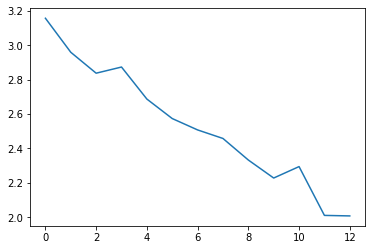

Epoch 1/15
11/11 - 74s - loss: 2.7491 - accuracy: 0.4513 - auc_97: 0.7519 - precision_97: 0.5758 - recall_97: 0.0560 - f1_score: 0.2108 - val_loss: 1.2268 - val_accuracy: 0.4000 - val_auc_97: 0.7444 - val_precision_97: 0.4286 - val_recall_97: 0.0176 - val_f1_score: 0.2090 - 74s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.4258 - accuracy: 0.4336 - auc_97: 0.7041 - precision_97: 0.5833 - recall_97: 0.0413 - f1_score: 0.2816 - val_loss: 1.1881 - val_accuracy: 0.4882 - val_auc_97: 0.7247 - val_precision_97: 0.6500 - val_recall_97: 0.0765 - val_f1_score: 0.2695 - 3s/epoch - 263ms/step
Epoch 3/15
11/11 - 3s - loss: 2.3790 - accuracy: 0.4277 - auc_97: 0.7330 - precision_97: 0.6970 - recall_97: 0.1357 - f1_score: 0.2736 - val_loss: 1.1854 - val_accuracy: 0.4235 - val_auc_97: 0.7266 - val_precision_97: 0.6757 - val_recall_97: 0.1471 - val_f1_score: 0.2692 - 3s/epoch - 254ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4039 - accuracy: 0.4130 - auc_97: 0.6853 - precision_97: 0.5417 - recall_97: 0.15

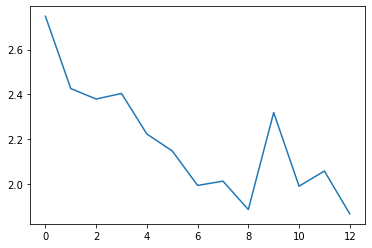

Epoch 1/15
11/11 - 67s - loss: 2.7578 - accuracy: 0.3000 - auc_98: 0.6944 - precision_98: 0.6429 - recall_98: 0.0265 - f1_score: 0.2148 - val_loss: 1.2261 - val_accuracy: 0.2604 - val_auc_98: 0.6258 - val_precision_98: 0.7778 - val_recall_98: 0.0414 - val_f1_score: 0.1929 - 67s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.4207 - accuracy: 0.4265 - auc_98: 0.7335 - precision_98: 0.6029 - recall_98: 0.1206 - f1_score: 0.2835 - val_loss: 1.3197 - val_accuracy: 0.3728 - val_auc_98: 0.6468 - val_precision_98: 0.3182 - val_recall_98: 0.1243 - val_f1_score: 0.1897 - 3s/epoch - 242ms/step
Epoch 3/15
11/11 - 3s - loss: 2.2663 - accuracy: 0.4706 - auc_98: 0.7620 - precision_98: 0.6413 - recall_98: 0.1735 - f1_score: 0.3201 - val_loss: 1.3557 - val_accuracy: 0.3373 - val_auc_98: 0.6440 - val_precision_98: 0.3425 - val_recall_98: 0.1479 - val_f1_score: 0.1796 - 3s/epoch - 241ms/step
Epoch 4/15
11/11 - 3s - loss: 2.2581 - accuracy: 0.4912 - auc_98: 0.7875 - precision_98: 0.6822 - recall_98: 0.25

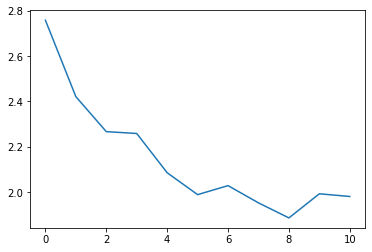

Kernel initializer: he_normal
Epoch 1/15
11/11 - 73s - loss: 3.1669 - accuracy: 0.4867 - auc_99: 0.6966 - precision_99: 0.6571 - recall_99: 0.0678 - f1_score: 0.2084 - val_loss: 1.2243 - val_accuracy: 0.4706 - val_auc_99: 0.7423 - val_precision_99: 0.5806 - val_recall_99: 0.1059 - val_f1_score: 0.1600 - 73s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.2205 - accuracy: 0.5192 - auc_99: 0.8123 - precision_99: 0.6667 - recall_99: 0.1121 - f1_score: 0.2282 - val_loss: 1.2239 - val_accuracy: 0.3647 - val_auc_99: 0.6801 - val_precision_99: 0.5000 - val_recall_99: 0.0176 - val_f1_score: 0.2047 - 3s/epoch - 268ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8938 - accuracy: 0.3982 - auc_99: 0.7298 - precision_99: 0.7188 - recall_99: 0.0678 - f1_score: 0.2048 - val_loss: 1.2598 - val_accuracy: 0.4588 - val_auc_99: 0.7328 - val_precision_99: 0.5789 - val_recall_99: 0.0647 - val_f1_score: 0.1643 - 3s/epoch - 269ms/step
Epoch 4/15
11/11 - 3s - loss: 2.7273 - accuracy: 0.4484 - auc_99: 0.7766 - precisio

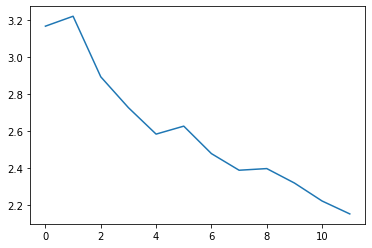

Epoch 1/15
11/11 - 60s - loss: 2.5948 - accuracy: 0.4543 - auc_100: 0.7162 - precision_100: 0.5000 - recall_100: 0.0472 - f1_score: 0.2530 - val_loss: 1.2544 - val_accuracy: 0.3353 - val_auc_100: 0.6392 - val_precision_100: 0.0000e+00 - val_recall_100: 0.0000e+00 - val_f1_score: 0.1481 - 60s/epoch - 5s/step
Epoch 2/15
11/11 - 3s - loss: 2.3833 - accuracy: 0.2802 - auc_100: 0.7011 - precision_100: 0.7083 - recall_100: 0.0501 - f1_score: 0.2097 - val_loss: 1.2369 - val_accuracy: 0.3294 - val_auc_100: 0.6741 - val_precision_100: 0.5000 - val_recall_100: 0.0941 - val_f1_score: 0.2132 - 3s/epoch - 232ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5723 - accuracy: 0.4395 - auc_100: 0.7298 - precision_100: 0.5306 - recall_100: 0.1534 - f1_score: 0.3026 - val_loss: 1.4156 - val_accuracy: 0.3412 - val_auc_100: 0.6573 - val_precision_100: 0.3095 - val_recall_100: 0.0765 - val_f1_score: 0.1929 - 3s/epoch - 241ms/step
Epoch 4/15
11/11 - 3s - loss: 2.3451 - accuracy: 0.4631 - auc_100: 0.7624 - precision_1

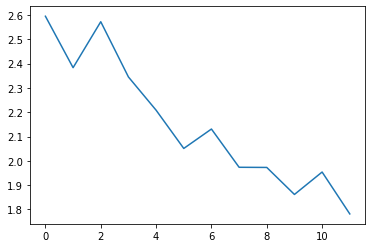

Epoch 1/15
11/11 - 68s - loss: 2.7778 - accuracy: 0.3147 - auc_101: 0.6577 - precision_101: 0.5152 - recall_101: 0.0500 - f1_score: 0.2273 - val_loss: 1.2002 - val_accuracy: 0.3669 - val_auc_101: 0.7525 - val_precision_101: 0.3333 - val_recall_101: 0.0237 - val_f1_score: 0.1576 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5064 - accuracy: 0.5000 - auc_101: 0.7871 - precision_101: 0.6429 - recall_101: 0.1059 - f1_score: 0.2924 - val_loss: 1.3677 - val_accuracy: 0.1893 - val_auc_101: 0.5549 - val_precision_101: 0.1509 - val_recall_101: 0.0473 - val_f1_score: 0.1459 - 3s/epoch - 256ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4167 - accuracy: 0.4500 - auc_101: 0.7453 - precision_101: 0.5730 - recall_101: 0.1500 - f1_score: 0.3136 - val_loss: 1.2541 - val_accuracy: 0.3964 - val_auc_101: 0.7289 - val_precision_101: 0.4615 - val_recall_101: 0.1420 - val_f1_score: 0.2159 - 3s/epoch - 259ms/step
Epoch 4/15
11/11 - 3s - loss: 2.2228 - accuracy: 0.5265 - auc_101: 0.8033 - precision_101: 0.70

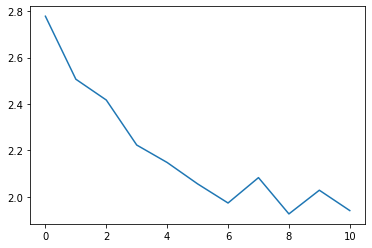

Kernel initializer: random_uniform
Epoch 1/15
11/11 - 72s - loss: 3.4017 - accuracy: 0.5192 - auc_102: 0.6921 - precision_102: 0.6667 - recall_102: 0.0059 - f1_score: 0.2201 - val_loss: 1.3134 - val_accuracy: 0.4706 - val_auc_102: 0.6776 - val_precision_102: 0.0000e+00 - val_recall_102: 0.0000e+00 - val_f1_score: 0.1600 - 72s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.9987 - accuracy: 0.5162 - auc_102: 0.6864 - precision_102: 0.6667 - recall_102: 0.0354 - f1_score: 0.1907 - val_loss: 1.2692 - val_accuracy: 0.2471 - val_auc_102: 0.6646 - val_precision_102: 0.0000e+00 - val_recall_102: 0.0000e+00 - val_f1_score: 0.1676 - 3s/epoch - 234ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8994 - accuracy: 0.3156 - auc_102: 0.6819 - precision_102: 0.7027 - recall_102: 0.0767 - f1_score: 0.2151 - val_loss: 1.2176 - val_accuracy: 0.2647 - val_auc_102: 0.6810 - val_precision_102: 0.5000 - val_recall_102: 0.1706 - val_f1_score: 0.1368 - 3s/epoch - 246ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8551 - accur

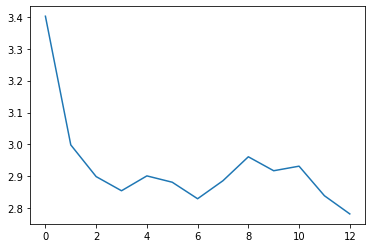

Epoch 1/15
11/11 - 73s - loss: 2.6107 - accuracy: 0.4041 - auc_103: 0.7132 - precision_103: 0.0000e+00 - recall_103: 0.0000e+00 - f1_score: 0.2251 - val_loss: 1.1660 - val_accuracy: 0.4941 - val_auc_103: 0.7871 - val_precision_103: 0.5000 - val_recall_103: 0.0059 - val_f1_score: 0.2556 - 73s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.5495 - accuracy: 0.4484 - auc_103: 0.7444 - precision_103: 0.6296 - recall_103: 0.0501 - f1_score: 0.2566 - val_loss: 1.3405 - val_accuracy: 0.2706 - val_auc_103: 0.5733 - val_precision_103: 0.1250 - val_recall_103: 0.0059 - val_f1_score: 0.1318 - 3s/epoch - 261ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4685 - accuracy: 0.4484 - auc_103: 0.7474 - precision_103: 0.5814 - recall_103: 0.0737 - f1_score: 0.2692 - val_loss: 1.2544 - val_accuracy: 0.3118 - val_auc_103: 0.6853 - val_precision_103: 0.0833 - val_recall_103: 0.0059 - val_f1_score: 0.1593 - 3s/epoch - 265ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4152 - accuracy: 0.3186 - auc_103: 0.6477 - precision_1

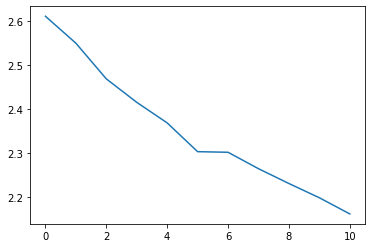

Epoch 1/15
11/11 - 66s - loss: 3.3062 - accuracy: 0.3471 - auc_104: 0.7270 - precision_104: 0.0000e+00 - recall_104: 0.0000e+00 - f1_score: 0.2418 - val_loss: 1.0905 - val_accuracy: 0.4556 - val_auc_104: 0.7899 - val_precision_104: 0.0000e+00 - val_recall_104: 0.0000e+00 - val_f1_score: 0.2369 - 66s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.7298 - accuracy: 0.4941 - auc_104: 0.7451 - precision_104: 0.0000e+00 - recall_104: 0.0000e+00 - f1_score: 0.1812 - val_loss: 1.2629 - val_accuracy: 0.5503 - val_auc_104: 0.6955 - val_precision_104: 0.0000e+00 - val_recall_104: 0.0000e+00 - val_f1_score: 0.1775 - 3s/epoch - 242ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5338 - accuracy: 0.4529 - auc_104: 0.7249 - precision_104: 0.6296 - recall_104: 0.0500 - f1_score: 0.2272 - val_loss: 1.3413 - val_accuracy: 0.1302 - val_auc_104: 0.5124 - val_precision_104: 0.0000e+00 - val_recall_104: 0.0000e+00 - val_f1_score: 0.0926 - 3s/epoch - 241ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4938 - accuracy: 0.1971

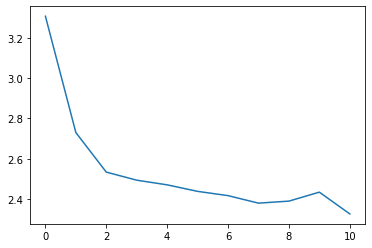

Kernel initializer: random_normal
Epoch 1/15
11/11 - 68s - loss: 3.4244 - accuracy: 0.5015 - auc_105: 0.7797 - precision_105: 0.6531 - recall_105: 0.0944 - f1_score: 0.2430 - val_loss: 1.3429 - val_accuracy: 0.1000 - val_auc_105: 0.5490 - val_precision_105: 0.0000e+00 - val_recall_105: 0.0000e+00 - val_f1_score: 0.0455 - 68s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.0710 - accuracy: 0.0914 - auc_105: 0.5448 - precision_105: 0.0000e+00 - recall_105: 0.0000e+00 - f1_score: 0.0419 - val_loss: 1.3537 - val_accuracy: 0.3059 - val_auc_105: 0.6455 - val_precision_105: 0.0000e+00 - val_recall_105: 0.0000e+00 - val_f1_score: 0.1992 - 3s/epoch - 251ms/step
Epoch 3/15
11/11 - 3s - loss: 3.1826 - accuracy: 0.5339 - auc_105: 0.7817 - precision_105: 0.7407 - recall_105: 0.0590 - f1_score: 0.2338 - val_loss: 1.1961 - val_accuracy: 0.4706 - val_auc_105: 0.7482 - val_precision_105: 0.5000 - val_recall_105: 0.0412 - val_f1_score: 0.1600 - 3s/epoch - 259ms/step
Epoch 4/15
11/11 - 3s - loss: 2.9117 

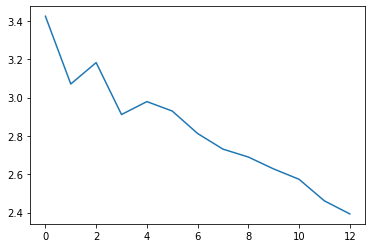

Epoch 1/15
11/11 - 60s - loss: 2.5472 - accuracy: 0.3835 - auc_106: 0.6818 - precision_106: 0.2500 - recall_106: 0.0029 - f1_score: 0.2025 - val_loss: 1.1221 - val_accuracy: 0.4941 - val_auc_106: 0.7999 - val_precision_106: 0.7778 - val_recall_106: 0.0412 - val_f1_score: 0.2556 - 60s/epoch - 5s/step
Epoch 2/15
11/11 - 3s - loss: 2.7977 - accuracy: 0.3982 - auc_106: 0.6918 - precision_106: 0.3500 - recall_106: 0.0206 - f1_score: 0.2195 - val_loss: 1.1431 - val_accuracy: 0.3529 - val_auc_106: 0.7276 - val_precision_106: 0.6923 - val_recall_106: 0.0529 - val_f1_score: 0.1897 - 3s/epoch - 238ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4661 - accuracy: 0.2891 - auc_106: 0.7146 - precision_106: 0.6667 - recall_106: 0.0472 - f1_score: 0.1761 - val_loss: 1.2029 - val_accuracy: 0.3000 - val_auc_106: 0.6794 - val_precision_106: 0.7333 - val_recall_106: 0.0647 - val_f1_score: 0.1797 - 3s/epoch - 237ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4786 - accuracy: 0.3186 - auc_106: 0.7167 - precision_106: 0.64

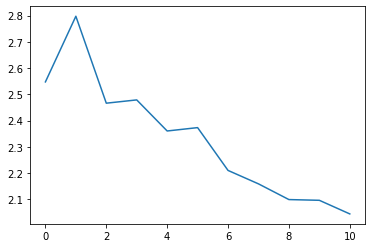

Epoch 1/15
11/11 - 69s - loss: 3.3042 - accuracy: 0.4176 - auc_107: 0.7314 - precision_107: 0.5455 - recall_107: 0.0529 - f1_score: 0.2529 - val_loss: 1.2639 - val_accuracy: 0.0888 - val_auc_107: 0.5123 - val_precision_107: 0.0000e+00 - val_recall_107: 0.0000e+00 - val_f1_score: 0.0408 - 69s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5100 - accuracy: 0.0971 - auc_107: 0.5604 - precision_107: 0.2222 - recall_107: 0.0059 - f1_score: 0.0444 - val_loss: 1.2640 - val_accuracy: 0.1834 - val_auc_107: 0.5903 - val_precision_107: 0.0000e+00 - val_recall_107: 0.0000e+00 - val_f1_score: 0.1217 - 3s/epoch - 264ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5494 - accuracy: 0.2676 - auc_107: 0.6551 - precision_107: 0.7500 - recall_107: 0.0088 - f1_score: 0.1835 - val_loss: 1.1604 - val_accuracy: 0.5089 - val_auc_107: 0.7752 - val_precision_107: 0.6400 - val_recall_107: 0.0947 - val_f1_score: 0.2501 - 3s/epoch - 259ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5262 - accuracy: 0.4794 - auc_107: 0.7693 - pre

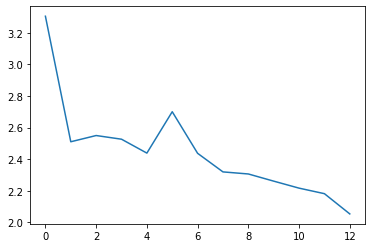

In [33]:
for kernel in kernel_initializer:
    print('Kernel initializer:', kernel)
    for train_index, val_index in kf.split(face_X):
        X_train, X_val = face_X[train_index], face_X[val_index]
        y_train, y_val = face_y[train_index], face_y[val_index]
        body_biConvLSTM = build_biConvLSTM(face_features, n_length, face_outputs, kernel_initializer=kernel)
        history = train(body_biConvLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
        plt.plot(history.history['loss'])
        plt.show()

Neurons: 50
Epoch 1/15
11/11 - 79s - loss: 3.5451 - accuracy: 0.3835 - auc_108: 0.7584 - precision_108: 1.0000 - recall_108: 0.0029 - f1_score: 0.2366 - val_loss: 1.0393 - val_accuracy: 0.4706 - val_auc_108: 0.7923 - val_precision_108: 0.8000 - val_recall_108: 0.0235 - val_f1_score: 0.1600 - 79s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.2623 - accuracy: 0.5546 - auc_108: 0.8065 - precision_108: 0.0000e+00 - recall_108: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.2746 - val_accuracy: 0.4706 - val_auc_108: 0.7174 - val_precision_108: 0.0000e+00 - val_recall_108: 0.0000e+00 - val_f1_score: 0.1600 - 3s/epoch - 247ms/step
Epoch 3/15
11/11 - 3s - loss: 3.0331 - accuracy: 0.5546 - auc_108: 0.7242 - precision_108: 0.0000e+00 - recall_108: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.2889 - val_accuracy: 0.4706 - val_auc_108: 0.6471 - val_precision_108: 0.6250 - val_recall_108: 0.0294 - val_f1_score: 0.1600 - 3s/epoch - 247ms/step
Epoch 4/15
11/11 - 3s - loss: 2.9713 - accuracy: 0.5516 - a

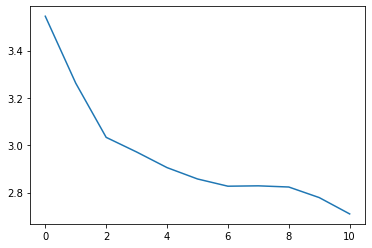

Epoch 1/15
11/11 - 69s - loss: 2.5921 - accuracy: 0.4631 - auc_109: 0.6391 - precision_109: 0.0000e+00 - recall_109: 0.0000e+00 - f1_score: 0.1777 - val_loss: 1.2546 - val_accuracy: 0.5588 - val_auc_109: 0.7105 - val_precision_109: 0.0000e+00 - val_recall_109: 0.0000e+00 - val_f1_score: 0.1792 - 69s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.7007 - accuracy: 0.5103 - auc_109: 0.6740 - precision_109: 0.5152 - recall_109: 0.0501 - f1_score: 0.1689 - val_loss: 1.2121 - val_accuracy: 0.4588 - val_auc_109: 0.6780 - val_precision_109: 0.0000e+00 - val_recall_109: 0.0000e+00 - val_f1_score: 0.2000 - 3s/epoch - 253ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5287 - accuracy: 0.1416 - auc_109: 0.6234 - precision_109: 0.0000e+00 - recall_109: 0.0000e+00 - f1_score: 0.0876 - val_loss: 1.2776 - val_accuracy: 0.0941 - val_auc_109: 0.6040 - val_precision_109: 0.0000e+00 - val_recall_109: 0.0000e+00 - val_f1_score: 0.0430 - 3s/epoch - 266ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5158 - accuracy: 0.0944

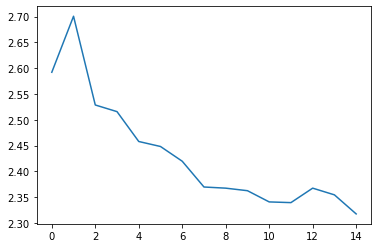

Epoch 1/15
11/11 - 71s - loss: 2.5952 - accuracy: 0.3941 - auc_110: 0.6892 - precision_110: 0.0000e+00 - recall_110: 0.0000e+00 - f1_score: 0.1827 - val_loss: 1.2314 - val_accuracy: 0.5503 - val_auc_110: 0.8009 - val_precision_110: 0.0000e+00 - val_recall_110: 0.0000e+00 - val_f1_score: 0.1775 - 71s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5882 - accuracy: 0.5000 - auc_110: 0.7845 - precision_110: 0.4000 - recall_110: 0.0118 - f1_score: 0.2544 - val_loss: 1.2481 - val_accuracy: 0.2130 - val_auc_110: 0.6368 - val_precision_110: 0.0000e+00 - val_recall_110: 0.0000e+00 - val_f1_score: 0.1402 - 3s/epoch - 257ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5734 - accuracy: 0.1382 - auc_110: 0.5465 - precision_110: 0.0263 - recall_110: 0.0029 - f1_score: 0.0987 - val_loss: 1.2543 - val_accuracy: 0.3018 - val_auc_110: 0.6635 - val_precision_110: 0.0000e+00 - val_recall_110: 0.0000e+00 - val_f1_score: 0.1585 - 3s/epoch - 262ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5405 - accuracy: 0.4559 - auc_1

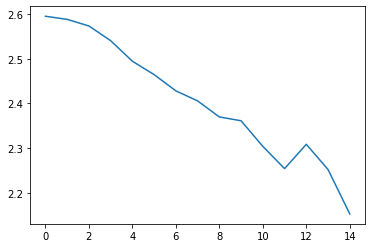

Neurons: 100
Epoch 1/15
11/11 - 61s - loss: 3.2733 - accuracy: 0.5428 - auc_111: 0.7604 - precision_111: 0.7857 - recall_111: 0.0324 - f1_score: 0.2659 - val_loss: 1.3670 - val_accuracy: 0.4471 - val_auc_111: 0.7093 - val_precision_111: 0.0000e+00 - val_recall_111: 0.0000e+00 - val_f1_score: 0.1874 - 61s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.0591 - accuracy: 0.5133 - auc_111: 0.7258 - precision_111: 0.0000e+00 - recall_111: 0.0000e+00 - f1_score: 0.2134 - val_loss: 1.2882 - val_accuracy: 0.4706 - val_auc_111: 0.6539 - val_precision_111: 0.6000 - val_recall_111: 0.0353 - val_f1_score: 0.1600 - 3s/epoch - 240ms/step
Epoch 3/15
11/11 - 3s - loss: 2.9281 - accuracy: 0.4484 - auc_111: 0.7088 - precision_111: 0.7045 - recall_111: 0.0914 - f1_score: 0.1713 - val_loss: 1.2963 - val_accuracy: 0.1000 - val_auc_111: 0.5914 - val_precision_111: 0.0000e+00 - val_recall_111: 0.0000e+00 - val_f1_score: 0.0945 - 3s/epoch - 241ms/step
Epoch 4/15
11/11 - 3s - loss: 2.9094 - accuracy: 0.2743 - 

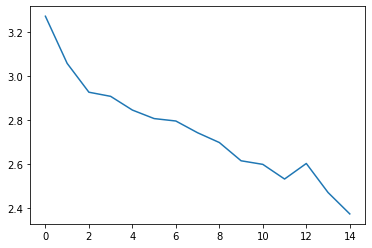

Epoch 1/15
11/11 - 69s - loss: 3.1017 - accuracy: 0.4956 - auc_112: 0.6991 - precision_112: 0.3889 - recall_112: 0.0206 - f1_score: 0.2717 - val_loss: 1.2381 - val_accuracy: 0.3412 - val_auc_112: 0.5758 - val_precision_112: 0.0000e+00 - val_recall_112: 0.0000e+00 - val_f1_score: 0.1272 - 69s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5578 - accuracy: 0.3923 - auc_112: 0.6185 - precision_112: 0.0000e+00 - recall_112: 0.0000e+00 - f1_score: 0.1409 - val_loss: 1.3365 - val_accuracy: 0.3412 - val_auc_112: 0.5741 - val_precision_112: 0.0000e+00 - val_recall_112: 0.0000e+00 - val_f1_score: 0.1272 - 3s/epoch - 277ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5370 - accuracy: 0.3923 - auc_112: 0.6438 - precision_112: 0.0000e+00 - recall_112: 0.0000e+00 - f1_score: 0.1551 - val_loss: 1.2693 - val_accuracy: 0.3353 - val_auc_112: 0.6829 - val_precision_112: 0.0000e+00 - val_recall_112: 0.0000e+00 - val_f1_score: 0.1284 - 3s/epoch - 260ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4503 - accuracy: 0.4189

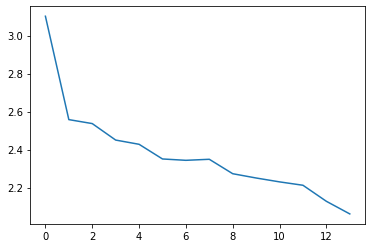

Epoch 1/15
11/11 - 75s - loss: 3.6281 - accuracy: 0.3676 - auc_113: 0.6602 - precision_113: 0.0000e+00 - recall_113: 0.0000e+00 - f1_score: 0.2223 - val_loss: 1.1296 - val_accuracy: 0.5503 - val_auc_113: 0.6915 - val_precision_113: 0.0000e+00 - val_recall_113: 0.0000e+00 - val_f1_score: 0.1775 - 75s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.8025 - accuracy: 0.1265 - auc_113: 0.6161 - precision_113: 0.0000e+00 - recall_113: 0.0000e+00 - f1_score: 0.0782 - val_loss: 1.2791 - val_accuracy: 0.0888 - val_auc_113: 0.6197 - val_precision_113: 0.0000e+00 - val_recall_113: 0.0000e+00 - val_f1_score: 0.0408 - 3s/epoch - 249ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5682 - accuracy: 0.3765 - auc_113: 0.6570 - precision_113: 0.5000 - recall_113: 0.0059 - f1_score: 0.1956 - val_loss: 1.2034 - val_accuracy: 0.5503 - val_auc_113: 0.7008 - val_precision_113: 0.6667 - val_recall_113: 0.0118 - val_f1_score: 0.1775 - 3s/epoch - 248ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5535 - accuracy: 0.2294 - auc_1

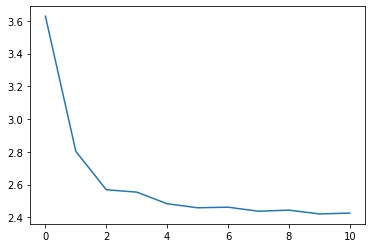

Neurons: 250
Epoch 1/15
11/11 - 78s - loss: 3.3748 - accuracy: 0.5221 - auc_114: 0.7454 - precision_114: 0.5714 - recall_114: 0.0354 - f1_score: 0.2043 - val_loss: 1.3672 - val_accuracy: 0.3412 - val_auc_114: 0.6663 - val_precision_114: 0.0000e+00 - val_recall_114: 0.0000e+00 - val_f1_score: 0.1559 - 78s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.9970 - accuracy: 0.3658 - auc_114: 0.6601 - precision_114: 1.0000 - recall_114: 0.0118 - f1_score: 0.2325 - val_loss: 1.2687 - val_accuracy: 0.4706 - val_auc_114: 0.6611 - val_precision_114: 0.5208 - val_recall_114: 0.1471 - val_f1_score: 0.1659 - 3s/epoch - 290ms/step
Epoch 3/15
11/11 - 3s - loss: 2.9400 - accuracy: 0.4041 - auc_114: 0.7011 - precision_114: 0.5556 - recall_114: 0.0737 - f1_score: 0.2459 - val_loss: 1.3432 - val_accuracy: 0.0824 - val_auc_114: 0.5299 - val_precision_114: 0.0800 - val_recall_114: 0.0118 - val_f1_score: 0.0758 - 3s/epoch - 282ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8844 - accuracy: 0.2419 - auc_114: 0.6190 

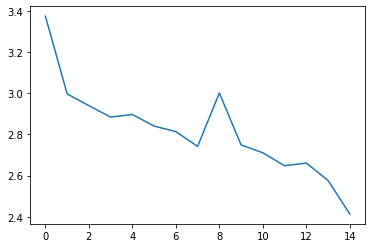

Epoch 1/15
11/11 - 66s - loss: 2.8517 - accuracy: 0.4189 - auc_115: 0.7128 - precision_115: 0.2273 - recall_115: 0.0147 - f1_score: 0.2211 - val_loss: 1.3325 - val_accuracy: 0.5588 - val_auc_115: 0.7123 - val_precision_115: 0.0000e+00 - val_recall_115: 0.0000e+00 - val_f1_score: 0.1792 - 66s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.8030 - accuracy: 0.5103 - auc_115: 0.7485 - precision_115: 0.5263 - recall_115: 0.0885 - f1_score: 0.1689 - val_loss: 1.0924 - val_accuracy: 0.5588 - val_auc_115: 0.8317 - val_precision_115: 0.7778 - val_recall_115: 0.0412 - val_f1_score: 0.1792 - 3s/epoch - 270ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5312 - accuracy: 0.5133 - auc_115: 0.7920 - precision_115: 0.6000 - recall_115: 0.0088 - f1_score: 0.2152 - val_loss: 1.2471 - val_accuracy: 0.3412 - val_auc_115: 0.7255 - val_precision_115: 0.0000e+00 - val_recall_115: 0.0000e+00 - val_f1_score: 0.1272 - 3s/epoch - 272ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5079 - accuracy: 0.3953 - auc_115: 0.7330 - pre

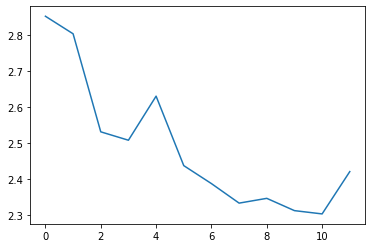

Epoch 1/15
11/11 - 71s - loss: 2.7209 - accuracy: 0.3118 - auc_116: 0.6868 - precision_116: 1.0000 - recall_116: 0.0029 - f1_score: 0.2103 - val_loss: 1.2792 - val_accuracy: 0.0947 - val_auc_116: 0.6239 - val_precision_116: 0.0000e+00 - val_recall_116: 0.0000e+00 - val_f1_score: 0.0463 - 71s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.0359 - accuracy: 0.3147 - auc_116: 0.6895 - precision_116: 0.2609 - recall_116: 0.0176 - f1_score: 0.2169 - val_loss: 1.1585 - val_accuracy: 0.3728 - val_auc_116: 0.7406 - val_precision_116: 0.0000e+00 - val_recall_116: 0.0000e+00 - val_f1_score: 0.1525 - 3s/epoch - 284ms/step
Epoch 3/15
11/11 - 3s - loss: 2.6682 - accuracy: 0.4588 - auc_116: 0.7252 - precision_116: 0.0000e+00 - recall_116: 0.0000e+00 - f1_score: 0.2353 - val_loss: 1.1856 - val_accuracy: 0.4970 - val_auc_116: 0.7823 - val_precision_116: 0.5000 - val_recall_116: 0.0059 - val_f1_score: 0.2523 - 3s/epoch - 288ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4826 - accuracy: 0.4647 - auc_116: 0.74

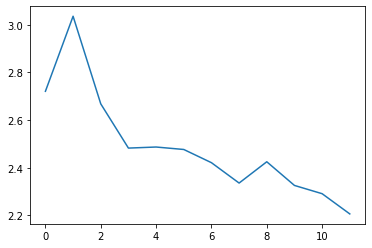

Neurons: 500
Epoch 1/15
11/11 - 61s - loss: 3.4563 - accuracy: 0.4100 - auc_117: 0.6683 - precision_117: 0.5000 - recall_117: 0.0147 - f1_score: 0.2187 - val_loss: 1.1000 - val_accuracy: 0.4706 - val_auc_117: 0.7739 - val_precision_117: 0.5000 - val_recall_117: 0.2176 - val_f1_score: 0.1600 - 61s/epoch - 6s/step
Epoch 2/15
11/11 - 4s - loss: 3.5676 - accuracy: 0.5546 - auc_117: 0.7953 - precision_117: 0.6531 - recall_117: 0.0944 - f1_score: 0.1784 - val_loss: 1.2986 - val_accuracy: 0.4706 - val_auc_117: 0.6940 - val_precision_117: 0.0000e+00 - val_recall_117: 0.0000e+00 - val_f1_score: 0.1600 - 4s/epoch - 408ms/step
Epoch 3/15
11/11 - 5s - loss: 3.0818 - accuracy: 0.5575 - auc_117: 0.7578 - precision_117: 0.5200 - recall_117: 0.0383 - f1_score: 0.1943 - val_loss: 1.1968 - val_accuracy: 0.4529 - val_auc_117: 0.7411 - val_precision_117: 0.4815 - val_recall_117: 0.0765 - val_f1_score: 0.1571 - 5s/epoch - 414ms/step
Epoch 4/15
11/11 - 4s - loss: 2.8982 - accuracy: 0.3894 - auc_117: 0.6947 

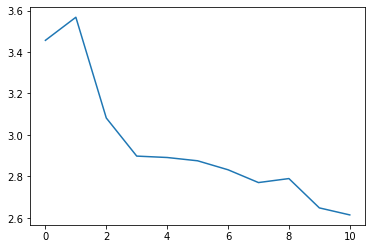

Epoch 1/15
11/11 - 71s - loss: 2.3381 - accuracy: 0.3510 - auc_118: 0.7040 - precision_118: 0.3864 - recall_118: 0.0501 - f1_score: 0.2624 - val_loss: 1.3106 - val_accuracy: 0.3412 - val_auc_118: 0.5947 - val_precision_118: 0.0000e+00 - val_recall_118: 0.0000e+00 - val_f1_score: 0.1522 - 71s/epoch - 6s/step
Epoch 2/15
11/11 - 5s - loss: 3.9692 - accuracy: 0.4395 - auc_118: 0.7187 - precision_118: 0.5882 - recall_118: 0.0295 - f1_score: 0.2399 - val_loss: 1.2447 - val_accuracy: 0.5529 - val_auc_118: 0.7417 - val_precision_118: 0.6000 - val_recall_118: 0.0176 - val_f1_score: 0.1932 - 5s/epoch - 420ms/step
Epoch 3/15
11/11 - 5s - loss: 2.5205 - accuracy: 0.4690 - auc_118: 0.7488 - precision_118: 0.6111 - recall_118: 0.0649 - f1_score: 0.2415 - val_loss: 1.2204 - val_accuracy: 0.3529 - val_auc_118: 0.7126 - val_precision_118: 0.0000e+00 - val_recall_118: 0.0000e+00 - val_f1_score: 0.2115 - 5s/epoch - 412ms/step
Epoch 4/15
11/11 - 5s - loss: 2.4197 - accuracy: 0.4307 - auc_118: 0.7395 - pre

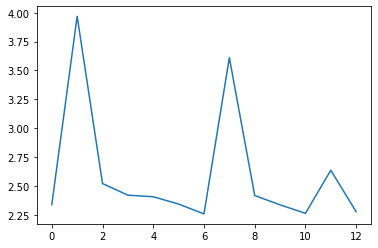

Epoch 1/15
11/11 - 80s - loss: 2.6089 - accuracy: 0.3559 - auc_119: 0.6496 - precision_119: 0.0000e+00 - recall_119: 0.0000e+00 - f1_score: 0.2272 - val_loss: 1.1226 - val_accuracy: 0.5503 - val_auc_119: 0.7571 - val_precision_119: 0.6923 - val_recall_119: 0.1065 - val_f1_score: 0.1775 - 80s/epoch - 7s/step
Epoch 2/15
11/11 - 5s - loss: 4.5140 - accuracy: 0.3706 - auc_119: 0.6616 - precision_119: 0.2727 - recall_119: 0.0353 - f1_score: 0.2426 - val_loss: 1.2975 - val_accuracy: 0.0888 - val_auc_119: 0.5065 - val_precision_119: 0.0000e+00 - val_recall_119: 0.0000e+00 - val_f1_score: 0.0408 - 5s/epoch - 415ms/step
Epoch 3/15
11/11 - 5s - loss: 2.8750 - accuracy: 0.2265 - auc_119: 0.5640 - precision_119: 0.0000e+00 - recall_119: 0.0000e+00 - f1_score: 0.1457 - val_loss: 1.3288 - val_accuracy: 0.3550 - val_auc_119: 0.5986 - val_precision_119: 0.0000e+00 - val_recall_119: 0.0000e+00 - val_f1_score: 0.1310 - 5s/epoch - 414ms/step
Epoch 4/15
11/11 - 5s - loss: 2.6611 - accuracy: 0.3853 - auc_1

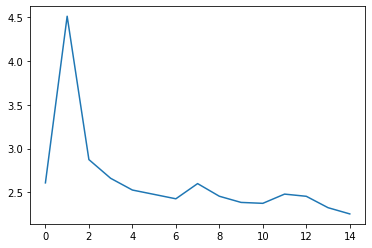

In [35]:
for neuron in neurons:
    print('Neurons:', neuron)
    for train_index, val_index in kf.split(face_X):
        X_train, X_val = face_X[train_index], face_X[val_index]
        y_train, y_val = face_y[train_index], face_y[val_index]
        body_biConvLSTM = build_biConvLSTM(face_features, n_length, face_outputs, neurons=neuron)
        history = train(body_biConvLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
        plt.plot(history.history['loss'])
        plt.show()

Activation function: relu
Epoch 1/15
11/11 - 76s - loss: 3.1012 - accuracy: 0.5516 - auc_120: 0.7299 - precision_120: 0.5000 - recall_120: 0.0118 - f1_score: 0.2020 - val_loss: 1.3128 - val_accuracy: 0.4706 - val_auc_120: 0.7034 - val_precision_120: 0.0000e+00 - val_recall_120: 0.0000e+00 - val_f1_score: 0.1600 - 76s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.9442 - accuracy: 0.5516 - auc_120: 0.7464 - precision_120: 0.6486 - recall_120: 0.0708 - f1_score: 0.1778 - val_loss: 1.2310 - val_accuracy: 0.4353 - val_auc_120: 0.6772 - val_precision_120: 0.5000 - val_recall_120: 0.0059 - val_f1_score: 0.1646 - 3s/epoch - 258ms/step
Epoch 3/15
11/11 - 3s - loss: 2.9144 - accuracy: 0.4248 - auc_120: 0.7298 - precision_120: 0.7297 - recall_120: 0.0796 - f1_score: 0.2416 - val_loss: 1.2132 - val_accuracy: 0.3000 - val_auc_120: 0.7069 - val_precision_120: 0.5111 - val_recall_120: 0.1353 - val_f1_score: 0.1903 - 3s/epoch - 261ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8184 - accuracy: 0.3687 - auc

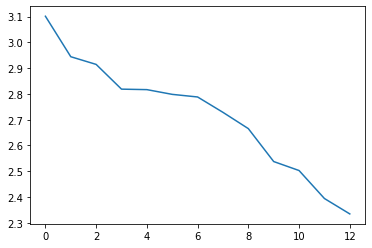

Epoch 1/15
11/11 - 66s - loss: 3.1085 - accuracy: 0.4277 - auc_121: 0.7531 - precision_121: 0.5833 - recall_121: 0.0206 - f1_score: 0.2614 - val_loss: 1.2194 - val_accuracy: 0.3471 - val_auc_121: 0.6609 - val_precision_121: 0.0000e+00 - val_recall_121: 0.0000e+00 - val_f1_score: 0.1930 - 66s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.5725 - accuracy: 0.1121 - auc_121: 0.5678 - precision_121: 0.0000e+00 - recall_121: 0.0000e+00 - f1_score: 0.0634 - val_loss: 1.3550 - val_accuracy: 0.0941 - val_auc_121: 0.5445 - val_precision_121: 0.0000e+00 - val_recall_121: 0.0000e+00 - val_f1_score: 0.0430 - 3s/epoch - 244ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5419 - accuracy: 0.0973 - auc_121: 0.5827 - precision_121: 0.0000e+00 - recall_121: 0.0000e+00 - f1_score: 0.0461 - val_loss: 1.2704 - val_accuracy: 0.1765 - val_auc_121: 0.6302 - val_precision_121: 0.0000e+00 - val_recall_121: 0.0000e+00 - val_f1_score: 0.1113 - 3s/epoch - 245ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4254 - accuracy: 0.2979

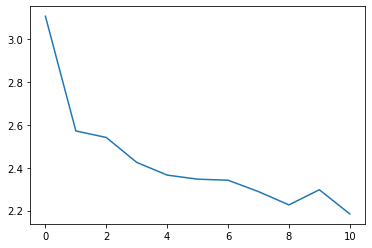

Epoch 1/15
11/11 - 69s - loss: 3.2151 - accuracy: 0.3794 - auc_122: 0.7108 - precision_122: 0.6538 - recall_122: 0.0500 - f1_score: 0.2508 - val_loss: 1.1968 - val_accuracy: 0.3550 - val_auc_122: 0.6186 - val_precision_122: 0.0000e+00 - val_recall_122: 0.0000e+00 - val_f1_score: 0.1310 - 69s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.7630 - accuracy: 0.3588 - auc_122: 0.5830 - precision_122: 0.0000e+00 - recall_122: 0.0000e+00 - f1_score: 0.1859 - val_loss: 1.3655 - val_accuracy: 0.1775 - val_auc_122: 0.5382 - val_precision_122: 0.0000e+00 - val_recall_122: 0.0000e+00 - val_f1_score: 0.1220 - 3s/epoch - 263ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5530 - accuracy: 0.1794 - auc_122: 0.5913 - precision_122: 0.0000e+00 - recall_122: 0.0000e+00 - f1_score: 0.1347 - val_loss: 1.1881 - val_accuracy: 0.5503 - val_auc_122: 0.7876 - val_precision_122: 0.6667 - val_recall_122: 0.0118 - val_f1_score: 0.1775 - 3s/epoch - 266ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4806 - accuracy: 0.4706 - auc_1

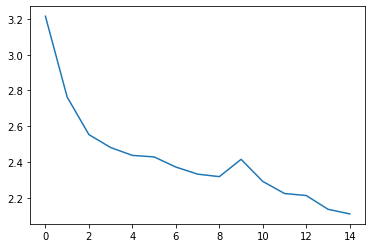

Activation function: tanh
Epoch 1/15
11/11 - 58s - loss: 3.8070 - accuracy: 0.2743 - auc_123: 0.6276 - precision_123: 0.4286 - recall_123: 0.0177 - f1_score: 0.1864 - val_loss: 1.2937 - val_accuracy: 0.4647 - val_auc_123: 0.7013 - val_precision_123: 1.0000 - val_recall_123: 0.0118 - val_f1_score: 0.2373 - 58s/epoch - 5s/step
Epoch 2/15
11/11 - 3s - loss: 3.2652 - accuracy: 0.4012 - auc_123: 0.6742 - precision_123: 0.6852 - recall_123: 0.1091 - f1_score: 0.2496 - val_loss: 1.2762 - val_accuracy: 0.2176 - val_auc_123: 0.6061 - val_precision_123: 0.0000e+00 - val_recall_123: 0.0000e+00 - val_f1_score: 0.1510 - 3s/epoch - 235ms/step
Epoch 3/15
11/11 - 3s - loss: 2.8609 - accuracy: 0.2478 - auc_123: 0.5516 - precision_123: 0.1953 - recall_123: 0.0973 - f1_score: 0.1937 - val_loss: 1.4654 - val_accuracy: 0.2294 - val_auc_123: 0.5080 - val_precision_123: 0.0471 - val_recall_123: 0.0235 - val_f1_score: 0.1440 - 3s/epoch - 235ms/step
Epoch 4/15
11/11 - 3s - loss: 2.8544 - accuracy: 0.3127 - auc

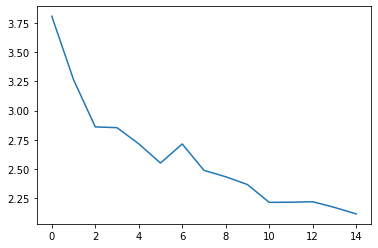

Epoch 1/15
11/11 - 69s - loss: 3.0933 - accuracy: 0.2301 - auc_124: 0.5997 - precision_124: 0.0000e+00 - recall_124: 0.0000e+00 - f1_score: 0.1787 - val_loss: 1.1747 - val_accuracy: 0.4588 - val_auc_124: 0.7795 - val_precision_124: 0.8000 - val_recall_124: 0.0235 - val_f1_score: 0.2324 - 69s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.7446 - accuracy: 0.2714 - auc_124: 0.6197 - precision_124: 0.0769 - recall_124: 0.0029 - f1_score: 0.2115 - val_loss: 1.2944 - val_accuracy: 0.3647 - val_auc_124: 0.6434 - val_precision_124: 0.7500 - val_recall_124: 0.0176 - val_f1_score: 0.2012 - 3s/epoch - 250ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4457 - accuracy: 0.2950 - auc_124: 0.6318 - precision_124: 0.6029 - recall_124: 0.1209 - f1_score: 0.2458 - val_loss: 1.2537 - val_accuracy: 0.3529 - val_auc_124: 0.6909 - val_precision_124: 0.3134 - val_recall_124: 0.1235 - val_f1_score: 0.1435 - 3s/epoch - 260ms/step
Epoch 4/15
11/11 - 3s - loss: 2.4204 - accuracy: 0.3304 - auc_124: 0.6466 - precision_1

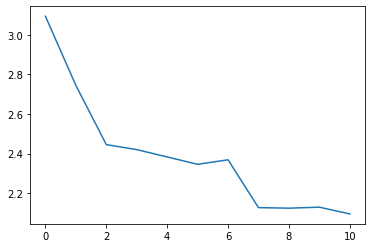

Epoch 1/15
11/11 - 76s - loss: 3.0485 - accuracy: 0.3029 - auc_125: 0.6524 - precision_125: 0.3000 - recall_125: 0.0176 - f1_score: 0.2142 - val_loss: 1.2639 - val_accuracy: 0.3669 - val_auc_125: 0.6974 - val_precision_125: 0.5000 - val_recall_125: 0.0118 - val_f1_score: 0.1613 - 76s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 2.6685 - accuracy: 0.2588 - auc_125: 0.6406 - precision_125: 0.4118 - recall_125: 0.0206 - f1_score: 0.1951 - val_loss: 1.2685 - val_accuracy: 0.3669 - val_auc_125: 0.6558 - val_precision_125: 0.1818 - val_recall_125: 0.0118 - val_f1_score: 0.1590 - 3s/epoch - 242ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4444 - accuracy: 0.3382 - auc_125: 0.6385 - precision_125: 0.4314 - recall_125: 0.0647 - f1_score: 0.2412 - val_loss: 1.3515 - val_accuracy: 0.2189 - val_auc_125: 0.5789 - val_precision_125: 0.3889 - val_recall_125: 0.0828 - val_f1_score: 0.1811 - 3s/epoch - 244ms/step
Epoch 4/15
11/11 - 3s - loss: 2.3594 - accuracy: 0.3206 - auc_125: 0.6260 - precision_125: 0.69

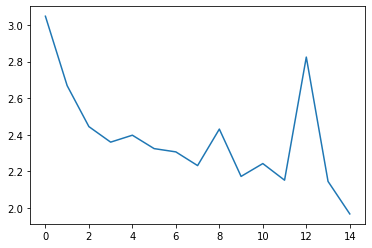

In [36]:
for act in activation:
    print('Activation function:', act)
    for train_index, val_index in kf.split(face_X):
        X_train, X_val = face_X[train_index], face_X[val_index]
        y_train, y_val = face_y[train_index], face_y[val_index]
        body_biConvLSTM = build_biConvLSTM(face_features, n_length, face_outputs, activation=act)
        history = train(body_biConvLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
        plt.plot(history.history['loss'])
        plt.show()

Batch size: 32
Epoch 1/15
11/11 - 75s - loss: 3.4999 - accuracy: 0.5487 - auc_126: 0.7717 - precision_126: 0.6176 - recall_126: 0.0619 - f1_score: 0.2125 - val_loss: 1.3049 - val_accuracy: 0.4706 - val_auc_126: 0.7898 - val_precision_126: 0.0000e+00 - val_recall_126: 0.0000e+00 - val_f1_score: 0.1600 - 75s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.1174 - accuracy: 0.5546 - auc_126: 0.6868 - precision_126: 0.0000e+00 - recall_126: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.3843 - val_accuracy: 0.4706 - val_auc_126: 0.5665 - val_precision_126: 0.0000e+00 - val_recall_126: 0.0000e+00 - val_f1_score: 0.1600 - 3s/epoch - 256ms/step
Epoch 3/15
11/11 - 3s - loss: 3.0815 - accuracy: 0.4631 - auc_126: 0.6611 - precision_126: 0.0000e+00 - recall_126: 0.0000e+00 - f1_score: 0.1681 - val_loss: 1.3676 - val_accuracy: 0.4706 - val_auc_126: 0.6680 - val_precision_126: 0.0000e+00 - val_recall_126: 0.0000e+00 - val_f1_score: 0.1600 - 3s/epoch - 260ms/step
Epoch 4/15
11/11 - 3s - loss: 3.0432 - a

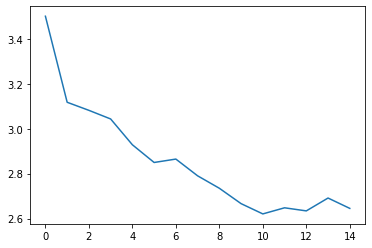

Epoch 1/15
11/11 - 66s - loss: 2.6987 - accuracy: 0.2271 - auc_127: 0.6223 - precision_127: 0.0000e+00 - recall_127: 0.0000e+00 - f1_score: 0.1619 - val_loss: 1.1916 - val_accuracy: 0.5059 - val_auc_127: 0.7903 - val_precision_127: 0.6000 - val_recall_127: 0.0176 - val_f1_score: 0.2618 - 66s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.6561 - accuracy: 0.3156 - auc_127: 0.7087 - precision_127: 0.6000 - recall_127: 0.0442 - f1_score: 0.1646 - val_loss: 1.2227 - val_accuracy: 0.1353 - val_auc_127: 0.5856 - val_precision_127: 0.0000e+00 - val_recall_127: 0.0000e+00 - val_f1_score: 0.1003 - 3s/epoch - 242ms/step
Epoch 3/15
11/11 - 3s - loss: 2.4624 - accuracy: 0.3982 - auc_127: 0.7266 - precision_127: 0.5833 - recall_127: 0.0413 - f1_score: 0.2510 - val_loss: 1.2312 - val_accuracy: 0.4176 - val_auc_127: 0.7081 - val_precision_127: 0.4286 - val_recall_127: 0.0353 - val_f1_score: 0.2419 - 3s/epoch - 247ms/step
Epoch 4/15
11/11 - 3s - loss: 2.3828 - accuracy: 0.3363 - auc_127: 0.7003 - pre

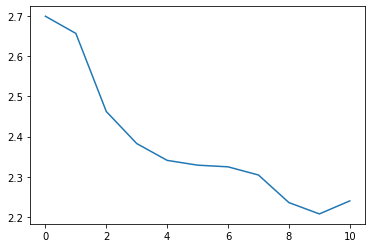

Epoch 1/15
11/11 - 70s - loss: 3.0757 - accuracy: 0.4941 - auc_128: 0.7412 - precision_128: 0.5806 - recall_128: 0.0529 - f1_score: 0.2750 - val_loss: 1.2432 - val_accuracy: 0.3550 - val_auc_128: 0.5610 - val_precision_128: 0.0000e+00 - val_recall_128: 0.0000e+00 - val_f1_score: 0.1310 - 70s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 2.6341 - accuracy: 0.1324 - auc_128: 0.5488 - precision_128: 0.0000e+00 - recall_128: 0.0000e+00 - f1_score: 0.0889 - val_loss: 1.3545 - val_accuracy: 0.0888 - val_auc_128: 0.5240 - val_precision_128: 0.0000e+00 - val_recall_128: 0.0000e+00 - val_f1_score: 0.0408 - 3s/epoch - 258ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5714 - accuracy: 0.1000 - auc_128: 0.5636 - precision_128: 0.0000e+00 - recall_128: 0.0000e+00 - f1_score: 0.0483 - val_loss: 1.3113 - val_accuracy: 0.1006 - val_auc_128: 0.6091 - val_precision_128: 0.0000e+00 - val_recall_128: 0.0000e+00 - val_f1_score: 0.0573 - 3s/epoch - 259ms/step
Epoch 4/15
11/11 - 3s - loss: 2.5521 - accuracy: 0.2912

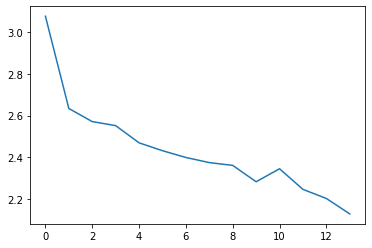

Batch size: 64
Epoch 1/15
6/6 - 57s - loss: 3.0771 - accuracy: 0.4897 - auc_129: 0.7483 - precision_129: 0.0000e+00 - recall_129: 0.0000e+00 - f1_score: 0.2802 - val_loss: 1.2043 - val_accuracy: 0.4706 - val_auc_129: 0.7935 - val_precision_129: 0.6471 - val_recall_129: 0.0647 - val_f1_score: 0.1600 - 57s/epoch - 9s/step
Epoch 2/15
6/6 - 1s - loss: 3.0814 - accuracy: 0.5546 - auc_129: 0.8128 - precision_129: 0.6667 - recall_129: 0.0531 - f1_score: 0.1784 - val_loss: 1.2485 - val_accuracy: 0.4706 - val_auc_129: 0.7775 - val_precision_129: 1.0000 - val_recall_129: 0.0059 - val_f1_score: 0.1600 - 1s/epoch - 234ms/step
Epoch 3/15
6/6 - 1s - loss: 2.9209 - accuracy: 0.4956 - auc_129: 0.7703 - precision_129: 0.6800 - recall_129: 0.0501 - f1_score: 0.2227 - val_loss: 1.2337 - val_accuracy: 0.2412 - val_auc_129: 0.6353 - val_precision_129: 0.6667 - val_recall_129: 0.0235 - val_f1_score: 0.1490 - 1s/epoch - 240ms/step
Epoch 4/15
6/6 - 2s - loss: 2.8477 - accuracy: 0.2861 - auc_129: 0.6644 - prec

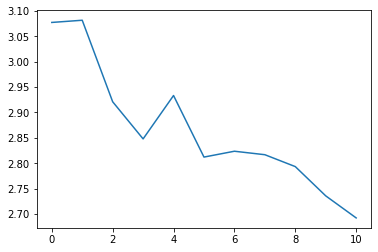

Epoch 1/15
6/6 - 66s - loss: 2.6168 - accuracy: 0.3009 - auc_130: 0.6455 - precision_130: 0.0000e+00 - recall_130: 0.0000e+00 - f1_score: 0.1868 - val_loss: 1.2185 - val_accuracy: 0.5471 - val_auc_130: 0.7885 - val_precision_130: 0.0000e+00 - val_recall_130: 0.0000e+00 - val_f1_score: 0.1843 - 66s/epoch - 11s/step
Epoch 2/15
6/6 - 2s - loss: 2.4960 - accuracy: 0.4661 - auc_130: 0.7835 - precision_130: 0.3846 - recall_130: 0.0147 - f1_score: 0.2555 - val_loss: 1.3315 - val_accuracy: 0.1176 - val_auc_130: 0.5327 - val_precision_130: 0.2000 - val_recall_130: 0.0118 - val_f1_score: 0.0747 - 2s/epoch - 253ms/step
Epoch 3/15
6/6 - 2s - loss: 2.4943 - accuracy: 0.1091 - auc_130: 0.5604 - precision_130: 0.0938 - recall_130: 0.0177 - f1_score: 0.0639 - val_loss: 1.2722 - val_accuracy: 0.2824 - val_auc_130: 0.6585 - val_precision_130: 0.0000e+00 - val_recall_130: 0.0000e+00 - val_f1_score: 0.1922 - 2s/epoch - 268ms/step
Epoch 4/15
6/6 - 2s - loss: 2.4381 - accuracy: 0.4336 - auc_130: 0.6810 - pr

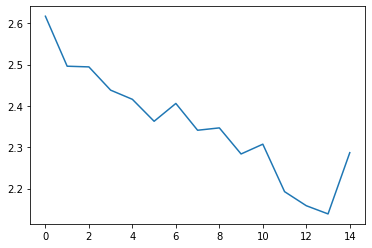

Epoch 1/15
6/6 - 75s - loss: 2.6005 - accuracy: 0.4324 - auc_131: 0.7163 - precision_131: 1.0000 - recall_131: 0.0029 - f1_score: 0.2931 - val_loss: 1.1694 - val_accuracy: 0.5503 - val_auc_131: 0.8019 - val_precision_131: 0.6207 - val_recall_131: 0.1065 - val_f1_score: 0.1775 - 75s/epoch - 12s/step
Epoch 2/15
6/6 - 2s - loss: 2.7252 - accuracy: 0.4706 - auc_131: 0.7523 - precision_131: 0.5714 - recall_131: 0.0353 - f1_score: 0.2343 - val_loss: 1.1919 - val_accuracy: 0.3550 - val_auc_131: 0.6835 - val_precision_131: 0.0000e+00 - val_recall_131: 0.0000e+00 - val_f1_score: 0.1310 - 2s/epoch - 254ms/step
Epoch 3/15
6/6 - 2s - loss: 2.5503 - accuracy: 0.3824 - auc_131: 0.6452 - precision_131: 0.0000e+00 - recall_131: 0.0000e+00 - f1_score: 0.1581 - val_loss: 1.1915 - val_accuracy: 0.5030 - val_auc_131: 0.7196 - val_precision_131: 0.0000e+00 - val_recall_131: 0.0000e+00 - val_f1_score: 0.2657 - 2s/epoch - 250ms/step
Epoch 4/15
6/6 - 2s - loss: 2.4716 - accuracy: 0.4824 - auc_131: 0.7639 - pr

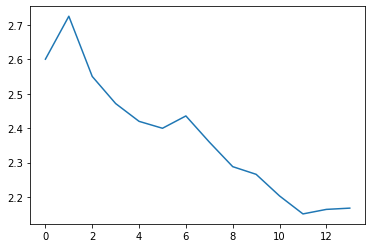

Batch size: 128
Epoch 1/15
3/3 - 73s - loss: 3.0828 - accuracy: 0.4277 - auc_132: 0.6321 - precision_132: 0.0000e+00 - recall_132: 0.0000e+00 - f1_score: 0.2461 - val_loss: 1.3518 - val_accuracy: 0.4706 - val_auc_132: 0.6269 - val_precision_132: 0.0000e+00 - val_recall_132: 0.0000e+00 - val_f1_score: 0.1600 - 73s/epoch - 24s/step
Epoch 2/15
3/3 - 1s - loss: 3.0467 - accuracy: 0.5546 - auc_132: 0.7105 - precision_132: 0.7692 - recall_132: 0.0295 - f1_score: 0.1784 - val_loss: 1.2853 - val_accuracy: 0.4706 - val_auc_132: 0.6807 - val_precision_132: 0.5806 - val_recall_132: 0.1059 - val_f1_score: 0.1600 - 904ms/epoch - 301ms/step
Epoch 3/15
3/3 - 1s - loss: 2.9286 - accuracy: 0.4454 - auc_132: 0.7006 - precision_132: 0.7500 - recall_132: 0.0885 - f1_score: 0.1876 - val_loss: 1.2616 - val_accuracy: 0.2353 - val_auc_132: 0.6001 - val_precision_132: 0.6667 - val_recall_132: 0.0118 - val_f1_score: 0.1220 - 912ms/epoch - 304ms/step
Epoch 4/15
3/3 - 1s - loss: 2.8622 - accuracy: 0.3304 - auc_13

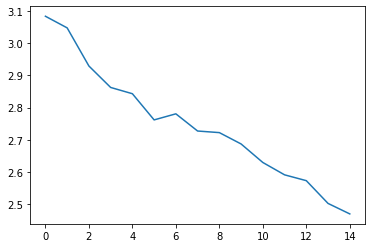

Epoch 1/15
3/3 - 65s - loss: 2.5975 - accuracy: 0.3953 - auc_133: 0.6428 - precision_133: 0.0000e+00 - recall_133: 0.0000e+00 - f1_score: 0.2491 - val_loss: 1.2850 - val_accuracy: 0.5588 - val_auc_133: 0.7764 - val_precision_133: 0.0000e+00 - val_recall_133: 0.0000e+00 - val_f1_score: 0.1792 - 65s/epoch - 22s/step
Epoch 2/15
3/3 - 1s - loss: 2.5258 - accuracy: 0.5103 - auc_133: 0.7906 - precision_133: 0.6667 - recall_133: 0.0059 - f1_score: 0.1689 - val_loss: 1.1401 - val_accuracy: 0.5647 - val_auc_133: 0.7985 - val_precision_133: 0.7273 - val_recall_133: 0.0471 - val_f1_score: 0.1884 - 862ms/epoch - 287ms/step
Epoch 3/15
3/3 - 1s - loss: 2.5908 - accuracy: 0.4277 - auc_133: 0.7527 - precision_133: 0.7500 - recall_133: 0.0088 - f1_score: 0.2490 - val_loss: 1.1770 - val_accuracy: 0.2706 - val_auc_133: 0.6719 - val_precision_133: 1.0000 - val_recall_133: 0.0059 - val_f1_score: 0.1641 - 881ms/epoch - 294ms/step
Epoch 4/15
3/3 - 1s - loss: 2.4512 - accuracy: 0.3274 - auc_133: 0.6755 - prec

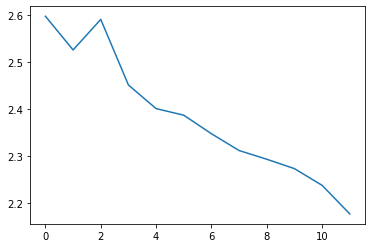

Epoch 1/15
3/3 - 68s - loss: 2.6313 - accuracy: 0.4588 - auc_134: 0.7120 - precision_134: 0.0000e+00 - recall_134: 0.0000e+00 - f1_score: 0.2522 - val_loss: 1.2991 - val_accuracy: 0.5503 - val_auc_134: 0.8122 - val_precision_134: 0.0000e+00 - val_recall_134: 0.0000e+00 - val_f1_score: 0.1775 - 68s/epoch - 23s/step
Epoch 2/15
3/3 - 1s - loss: 2.5467 - accuracy: 0.5147 - auc_134: 0.7442 - precision_134: 1.0000 - recall_134: 0.0029 - f1_score: 0.1699 - val_loss: 1.2018 - val_accuracy: 0.5503 - val_auc_134: 0.7457 - val_precision_134: 0.6875 - val_recall_134: 0.0651 - val_f1_score: 0.1775 - 876ms/epoch - 292ms/step
Epoch 3/15
3/3 - 1s - loss: 2.4596 - accuracy: 0.5147 - auc_134: 0.7306 - precision_134: 0.6800 - recall_134: 0.0500 - f1_score: 0.2053 - val_loss: 1.2261 - val_accuracy: 0.3491 - val_auc_134: 0.6765 - val_precision_134: 0.0000e+00 - val_recall_134: 0.0000e+00 - val_f1_score: 0.1560 - 919ms/epoch - 306ms/step
Epoch 4/15
3/3 - 1s - loss: 2.4426 - accuracy: 0.4118 - auc_134: 0.679

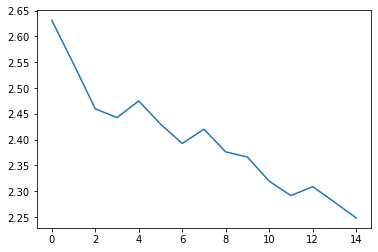

Batch size: 256
Epoch 1/15
2/2 - 69s - loss: 3.0833 - accuracy: 0.2360 - auc_135: 0.5536 - precision_135: 0.0000e+00 - recall_135: 0.0000e+00 - f1_score: 0.2398 - val_loss: 1.3542 - val_accuracy: 0.4706 - val_auc_135: 0.6507 - val_precision_135: 0.0000e+00 - val_recall_135: 0.0000e+00 - val_f1_score: 0.1600 - 69s/epoch - 34s/step
Epoch 2/15
2/2 - 1s - loss: 3.0723 - accuracy: 0.5546 - auc_135: 0.6933 - precision_135: 0.0000e+00 - recall_135: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.3058 - val_accuracy: 0.4706 - val_auc_135: 0.6484 - val_precision_135: 0.6429 - val_recall_135: 0.0529 - val_f1_score: 0.1600 - 662ms/epoch - 331ms/step
Epoch 3/15
2/2 - 1s - loss: 3.0301 - accuracy: 0.5546 - auc_135: 0.7103 - precision_135: 0.7097 - recall_135: 0.0649 - f1_score: 0.1784 - val_loss: 1.2325 - val_accuracy: 0.4706 - val_auc_135: 0.7297 - val_precision_135: 0.5806 - val_recall_135: 0.1059 - val_f1_score: 0.1600 - 703ms/epoch - 352ms/step
Epoch 4/15
2/2 - 1s - loss: 2.9566 - accuracy: 0.5575 

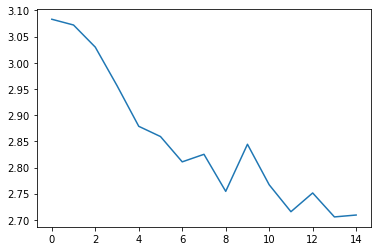

Epoch 1/15
2/2 - 72s - loss: 2.6062 - accuracy: 0.2094 - auc_136: 0.5685 - precision_136: 0.0000e+00 - recall_136: 0.0000e+00 - f1_score: 0.2205 - val_loss: 1.3073 - val_accuracy: 0.5588 - val_auc_136: 0.7185 - val_precision_136: 0.0000e+00 - val_recall_136: 0.0000e+00 - val_f1_score: 0.1792 - 72s/epoch - 36s/step
Epoch 2/15
2/2 - 1s - loss: 2.5372 - accuracy: 0.5103 - auc_136: 0.7332 - precision_136: 0.0000e+00 - recall_136: 0.0000e+00 - f1_score: 0.1689 - val_loss: 1.1340 - val_accuracy: 0.5588 - val_auc_136: 0.8188 - val_precision_136: 0.6667 - val_recall_136: 0.0353 - val_f1_score: 0.1792 - 774ms/epoch - 387ms/step
Epoch 3/15
2/2 - 1s - loss: 2.6510 - accuracy: 0.5103 - auc_136: 0.7955 - precision_136: 0.6429 - recall_136: 0.0265 - f1_score: 0.1689 - val_loss: 1.1336 - val_accuracy: 0.5647 - val_auc_136: 0.7931 - val_precision_136: 1.0000 - val_recall_136: 0.0059 - val_f1_score: 0.2027 - 789ms/epoch - 395ms/step
Epoch 4/15
2/2 - 1s - loss: 2.4489 - accuracy: 0.5133 - auc_136: 0.779

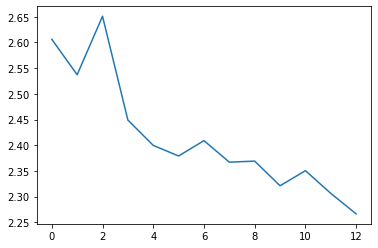

Epoch 1/15
2/2 - 81s - loss: 2.6186 - accuracy: 0.2765 - auc_137: 0.5584 - precision_137: 0.0000e+00 - recall_137: 0.0000e+00 - f1_score: 0.2396 - val_loss: 1.3469 - val_accuracy: 0.2012 - val_auc_137: 0.6341 - val_precision_137: 0.0000e+00 - val_recall_137: 0.0000e+00 - val_f1_score: 0.1268 - 81s/epoch - 40s/step
Epoch 2/15
2/2 - 1s - loss: 2.5713 - accuracy: 0.1941 - auc_137: 0.6278 - precision_137: 0.0000e+00 - recall_137: 0.0000e+00 - f1_score: 0.1248 - val_loss: 1.2503 - val_accuracy: 0.0888 - val_auc_137: 0.6265 - val_precision_137: 0.0000e+00 - val_recall_137: 0.0000e+00 - val_f1_score: 0.0408 - 742ms/epoch - 371ms/step
Epoch 3/15
2/2 - 1s - loss: 2.6152 - accuracy: 0.1118 - auc_137: 0.6324 - precision_137: 0.0000e+00 - recall_137: 0.0000e+00 - f1_score: 0.0588 - val_loss: 1.1834 - val_accuracy: 0.4083 - val_auc_137: 0.6810 - val_precision_137: 0.0000e+00 - val_recall_137: 0.0000e+00 - val_f1_score: 0.2011 - 796ms/epoch - 398ms/step
Epoch 4/15
2/2 - 1s - loss: 2.5223 - accuracy:

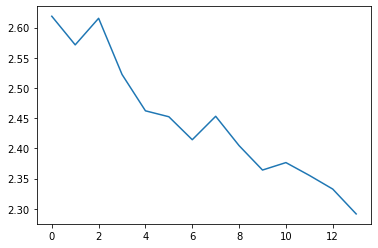

Batch size: 512
Epoch 1/15
1/1 - 74s - loss: 3.0860 - accuracy: 0.2389 - auc_138: 0.5000 - precision_138: 0.0000e+00 - recall_138: 0.0000e+00 - f1_score: 0.2443 - val_loss: 1.3729 - val_accuracy: 0.4706 - val_auc_138: 0.6455 - val_precision_138: 0.0000e+00 - val_recall_138: 0.0000e+00 - val_f1_score: 0.1600 - 74s/epoch - 74s/step
Epoch 2/15
1/1 - 1s - loss: 3.0805 - accuracy: 0.5546 - auc_138: 0.7003 - precision_138: 0.0000e+00 - recall_138: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.3568 - val_accuracy: 0.4706 - val_auc_138: 0.6348 - val_precision_138: 0.0000e+00 - val_recall_138: 0.0000e+00 - val_f1_score: 0.1600 - 513ms/epoch - 513ms/step
Epoch 3/15
1/1 - 0s - loss: 3.0458 - accuracy: 0.5546 - auc_138: 0.7017 - precision_138: 0.0000e+00 - recall_138: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.3223 - val_accuracy: 0.4706 - val_auc_138: 0.6018 - val_precision_138: 0.0000e+00 - val_recall_138: 0.0000e+00 - val_f1_score: 0.1600 - 489ms/epoch - 489ms/step
Epoch 4/15
1/1 - 1s - loss: 2.

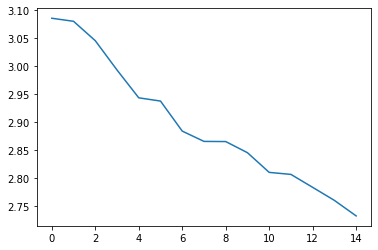

Epoch 1/15
1/1 - 71s - loss: 2.6106 - accuracy: 0.2891 - auc_139: 0.5000 - precision_139: 0.0000e+00 - recall_139: 0.0000e+00 - f1_score: 0.2483 - val_loss: 1.3717 - val_accuracy: 0.3412 - val_auc_139: 0.6643 - val_precision_139: 0.0000e+00 - val_recall_139: 0.0000e+00 - val_f1_score: 0.1272 - 71s/epoch - 71s/step
Epoch 2/15
1/1 - 1s - loss: 2.5974 - accuracy: 0.3923 - auc_139: 0.6717 - precision_139: 0.0000e+00 - recall_139: 0.0000e+00 - f1_score: 0.1409 - val_loss: 1.3324 - val_accuracy: 0.3412 - val_auc_139: 0.6773 - val_precision_139: 0.0000e+00 - val_recall_139: 0.0000e+00 - val_f1_score: 0.1272 - 569ms/epoch - 569ms/step
Epoch 3/15
1/1 - 1s - loss: 2.5607 - accuracy: 0.3923 - auc_139: 0.6989 - precision_139: 0.0000e+00 - recall_139: 0.0000e+00 - f1_score: 0.1409 - val_loss: 1.2737 - val_accuracy: 0.3412 - val_auc_139: 0.6663 - val_precision_139: 0.0000e+00 - val_recall_139: 0.0000e+00 - val_f1_score: 0.1272 - 514ms/epoch - 514ms/step
Epoch 4/15
1/1 - 1s - loss: 2.5218 - accuracy:

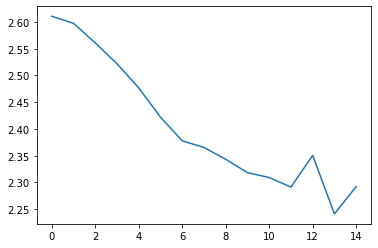

Epoch 1/15
1/1 - 73s - loss: 2.6215 - accuracy: 0.4118 - auc_140: 0.5000 - precision_140: 0.0000e+00 - recall_140: 0.0000e+00 - f1_score: 0.3154 - val_loss: 1.3664 - val_accuracy: 0.5444 - val_auc_140: 0.7491 - val_precision_140: 0.0000e+00 - val_recall_140: 0.0000e+00 - val_f1_score: 0.2188 - 73s/epoch - 73s/step
Epoch 2/15
1/1 - 1s - loss: 2.6076 - accuracy: 0.5353 - auc_140: 0.7563 - precision_140: 0.0000e+00 - recall_140: 0.0000e+00 - f1_score: 0.2161 - val_loss: 1.3148 - val_accuracy: 0.4260 - val_auc_140: 0.7569 - val_precision_140: 0.0000e+00 - val_recall_140: 0.0000e+00 - val_f1_score: 0.2068 - 516ms/epoch - 516ms/step
Epoch 3/15
1/1 - 1s - loss: 2.5704 - accuracy: 0.4765 - auc_140: 0.7594 - precision_140: 0.0000e+00 - recall_140: 0.0000e+00 - f1_score: 0.2318 - val_loss: 1.2265 - val_accuracy: 0.4497 - val_auc_140: 0.7863 - val_precision_140: 0.0000e+00 - val_recall_140: 0.0000e+00 - val_f1_score: 0.2358 - 520ms/epoch - 520ms/step
Epoch 4/15
1/1 - 1s - loss: 2.5295 - accuracy:

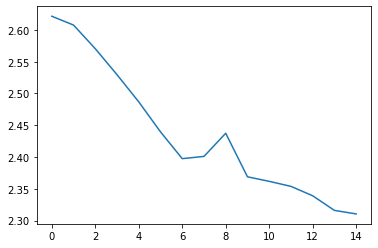

In [37]:
for batch in batch_sizes: 
    print('Batch size:', batch)
    for train_index, val_index in kf.split(face_X):
        X_train, X_val = face_X[train_index], face_X[val_index]
        y_train, y_val = face_y[train_index], face_y[val_index]
        body_biConvLSTM = build_biConvLSTM(face_features, n_length, face_outputs)
        history = train(body_biConvLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch, class_weight=class_weight)
        plt.plot(history.history['loss'])
        plt.show()

#### Train CNN+LSTM

Epoch 1/15
11/11 - 28s - loss: 3.0934 - accuracy: 0.5457 - auc_141: 0.7845 - precision_141: 0.0000e+00 - recall_141: 0.0000e+00 - f1_score: 0.2132 - val_loss: 1.2754 - val_accuracy: 0.4706 - val_auc_141: 0.7822 - val_precision_141: 0.0000e+00 - val_recall_141: 0.0000e+00 - val_f1_score: 0.1600 - 28s/epoch - 3s/step
Epoch 2/15
11/11 - 0s - loss: 2.9728 - accuracy: 0.5546 - auc_141: 0.8009 - precision_141: 0.0000e+00 - recall_141: 0.0000e+00 - f1_score: 0.1784 - val_loss: 1.2406 - val_accuracy: 0.4706 - val_auc_141: 0.7444 - val_precision_141: 0.0000e+00 - val_recall_141: 0.0000e+00 - val_f1_score: 0.1600 - 398ms/epoch - 36ms/step
Epoch 3/15
11/11 - 0s - loss: 2.8902 - accuracy: 0.4513 - auc_141: 0.7547 - precision_141: 0.0000e+00 - recall_141: 0.0000e+00 - f1_score: 0.1752 - val_loss: 1.1881 - val_accuracy: 0.4706 - val_auc_141: 0.7425 - val_precision_141: 0.0000e+00 - val_recall_141: 0.0000e+00 - val_f1_score: 0.1600 - 391ms/epoch - 36ms/step
Epoch 4/15
11/11 - 0s - loss: 2.8450 - accu

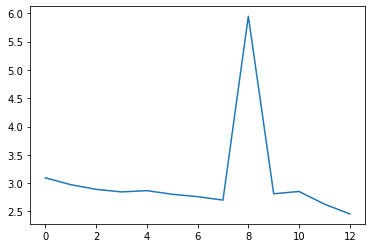

Epoch 1/15
11/11 - 16s - loss: 2.5142 - accuracy: 0.4838 - auc_142: 0.7160 - precision_142: 0.0000e+00 - recall_142: 0.0000e+00 - f1_score: 0.1945 - val_loss: 1.1199 - val_accuracy: 0.5588 - val_auc_142: 0.8263 - val_precision_142: 0.0000e+00 - val_recall_142: 0.0000e+00 - val_f1_score: 0.1792 - 16s/epoch - 1s/step
Epoch 2/15
11/11 - 0s - loss: 3.2970 - accuracy: 0.4513 - auc_142: 0.7737 - precision_142: 0.0000e+00 - recall_142: 0.0000e+00 - f1_score: 0.2372 - val_loss: 1.1312 - val_accuracy: 0.3412 - val_auc_142: 0.7442 - val_precision_142: 0.0000e+00 - val_recall_142: 0.0000e+00 - val_f1_score: 0.1272 - 402ms/epoch - 37ms/step
Epoch 3/15
11/11 - 0s - loss: 2.8051 - accuracy: 0.3422 - auc_142: 0.6872 - precision_142: 0.0000e+00 - recall_142: 0.0000e+00 - f1_score: 0.1405 - val_loss: 1.2008 - val_accuracy: 0.3294 - val_auc_142: 0.5647 - val_precision_142: 0.0000e+00 - val_recall_142: 0.0000e+00 - val_f1_score: 0.1279 - 415ms/epoch - 38ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6676 - accu

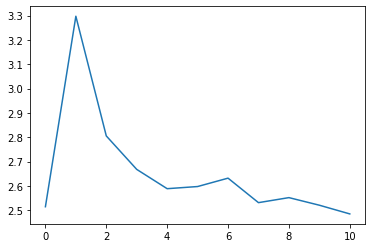

Epoch 1/15
11/11 - 18s - loss: 2.4396 - accuracy: 0.4059 - auc_143: 0.7225 - precision_143: 0.0000e+00 - recall_143: 0.0000e+00 - f1_score: 0.2717 - val_loss: 1.1111 - val_accuracy: 0.5503 - val_auc_143: 0.8272 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00 - val_f1_score: 0.1775 - 18s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 3.1232 - accuracy: 0.2971 - auc_143: 0.6381 - precision_143: 0.0000e+00 - recall_143: 0.0000e+00 - f1_score: 0.1775 - val_loss: 1.2187 - val_accuracy: 0.0888 - val_auc_143: 0.5107 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00 - val_f1_score: 0.0408 - 420ms/epoch - 38ms/step
Epoch 3/15
11/11 - 0s - loss: 2.7368 - accuracy: 0.0971 - auc_143: 0.5278 - precision_143: 0.0000e+00 - recall_143: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.2620 - val_accuracy: 0.0888 - val_auc_143: 0.5208 - val_precision_143: 0.0000e+00 - val_recall_143: 0.0000e+00 - val_f1_score: 0.0408 - 423ms/epoch - 38ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6194 - accu

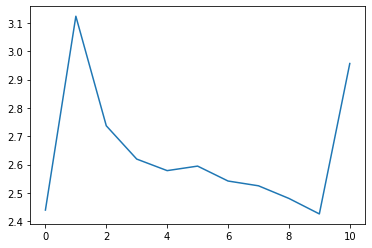

In [38]:
for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = face_y[train_index], face_y[val_index]
    face_cnn = build_CNN(face_features, n_length, face_outputs)
    history = train(face_cnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Train ConvLSTM

Epoch 1/15
11/11 - 23s - loss: 3.0544 - accuracy: 0.5221 - auc_144: 0.6810 - precision_144: 0.6471 - recall_144: 0.0324 - f1_score: 0.2299 - val_loss: 1.2702 - val_accuracy: 0.3412 - val_auc_144: 0.6497 - val_precision_144: 0.5926 - val_recall_144: 0.0941 - val_f1_score: 0.1854 - 23s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.9286 - accuracy: 0.3894 - auc_144: 0.6883 - precision_144: 0.5714 - recall_144: 0.0236 - f1_score: 0.2172 - val_loss: 1.2429 - val_accuracy: 0.3412 - val_auc_144: 0.6370 - val_precision_144: 0.5143 - val_recall_144: 0.1059 - val_f1_score: 0.1908 - 1s/epoch - 96ms/step
Epoch 3/15
11/11 - 1s - loss: 2.8675 - accuracy: 0.4366 - auc_144: 0.7072 - precision_144: 0.6724 - recall_144: 0.1150 - f1_score: 0.2564 - val_loss: 1.2222 - val_accuracy: 0.2765 - val_auc_144: 0.6765 - val_precision_144: 0.0000e+00 - val_recall_144: 0.0000e+00 - val_f1_score: 0.1906 - 1s/epoch - 97ms/step
Epoch 4/15
11/11 - 1s - loss: 2.8382 - accuracy: 0.3127 - auc_144: 0.6945 - precision_144

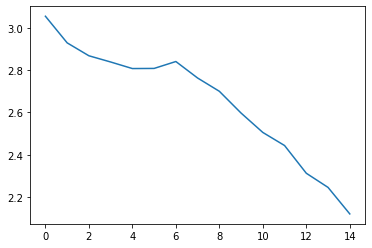

Epoch 1/15
11/11 - 26s - loss: 2.5801 - accuracy: 0.3776 - auc_145: 0.7452 - precision_145: 0.0000e+00 - recall_145: 0.0000e+00 - f1_score: 0.2191 - val_loss: 1.2055 - val_accuracy: 0.5588 - val_auc_145: 0.7976 - val_precision_145: 0.6667 - val_recall_145: 0.0235 - val_f1_score: 0.1792 - 26s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.4622 - accuracy: 0.4572 - auc_145: 0.7658 - precision_145: 0.5833 - recall_145: 0.0206 - f1_score: 0.2377 - val_loss: 1.2112 - val_accuracy: 0.3529 - val_auc_145: 0.6951 - val_precision_145: 1.0000 - val_recall_145: 0.0059 - val_f1_score: 0.2000 - 1s/epoch - 107ms/step
Epoch 3/15
11/11 - 1s - loss: 2.4254 - accuracy: 0.2655 - auc_145: 0.6627 - precision_145: 0.4000 - recall_145: 0.0177 - f1_score: 0.1881 - val_loss: 1.2938 - val_accuracy: 0.1529 - val_auc_145: 0.6030 - val_precision_145: 0.1250 - val_recall_145: 0.0059 - val_f1_score: 0.1124 - 1s/epoch - 109ms/step
Epoch 4/15
11/11 - 1s - loss: 2.3668 - accuracy: 0.2861 - auc_145: 0.6992 - precision_1

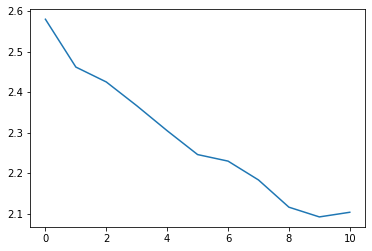

Epoch 1/15
11/11 - 27s - loss: 2.5579 - accuracy: 0.3294 - auc_146: 0.6438 - precision_146: 0.3333 - recall_146: 0.0059 - f1_score: 0.2195 - val_loss: 1.1742 - val_accuracy: 0.5503 - val_auc_146: 0.7319 - val_precision_146: 0.6875 - val_recall_146: 0.0651 - val_f1_score: 0.1775 - 27s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 2.5071 - accuracy: 0.5088 - auc_146: 0.7187 - precision_146: 0.8182 - recall_146: 0.0265 - f1_score: 0.2627 - val_loss: 1.2286 - val_accuracy: 0.3550 - val_auc_146: 0.6412 - val_precision_146: 0.0000e+00 - val_recall_146: 0.0000e+00 - val_f1_score: 0.1310 - 1s/epoch - 101ms/step
Epoch 3/15
11/11 - 1s - loss: 2.5441 - accuracy: 0.4265 - auc_146: 0.6922 - precision_146: 0.6667 - recall_146: 0.0353 - f1_score: 0.2679 - val_loss: 1.2492 - val_accuracy: 0.2781 - val_auc_146: 0.5885 - val_precision_146: 0.0000e+00 - val_recall_146: 0.0000e+00 - val_f1_score: 0.1278 - 1s/epoch - 98ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4641 - accuracy: 0.4176 - auc_146: 0.6718 - prec

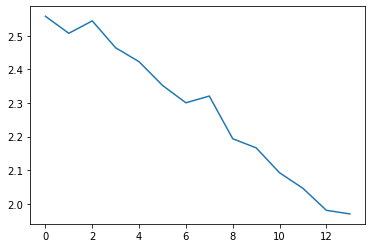

In [39]:
for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = face_y[train_index], face_y[val_index]
    face_convLSTM = build_convLSTM(face_features, n_length, face_outputs)
    history = train(face_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

#### Train RCNN

Epoch 1/15
11/11 - 7s - loss: 52.9261 - accuracy: 0.2684 - auc_147: 0.5051 - precision_147: 0.2586 - recall_147: 0.2448 - f1_score: 0.2134 - val_loss: 1.5916 - val_accuracy: 0.1941 - val_auc_147: 0.5027 - val_precision_147: 0.4030 - val_recall_147: 0.1588 - val_f1_score: 0.1267 - 7s/epoch - 667ms/step
Epoch 2/15
11/11 - 0s - loss: 9.7540 - accuracy: 0.3068 - auc_147: 0.5992 - precision_147: 0.3086 - recall_147: 0.3068 - f1_score: 0.2351 - val_loss: 1.5767 - val_accuracy: 0.3059 - val_auc_147: 0.5619 - val_precision_147: 0.0323 - val_recall_147: 0.0059 - val_f1_score: 0.1618 - 360ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 18.7056 - accuracy: 0.4543 - auc_147: 0.6797 - precision_147: 0.4551 - recall_147: 0.4484 - f1_score: 0.3339 - val_loss: 1.2896 - val_accuracy: 0.3824 - val_auc_147: 0.6799 - val_precision_147: 0.1212 - val_recall_147: 0.0235 - val_f1_score: 0.1752 - 343ms/epoch - 31ms/step
Epoch 4/15
11/11 - 0s - loss: 27.9410 - accuracy: 0.2566 - auc_147: 0.5640 - precision_1

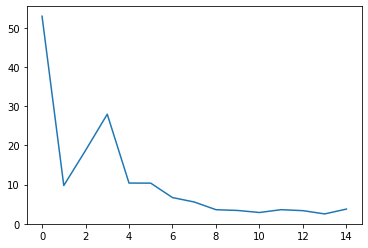

Epoch 1/15
11/11 - 8s - loss: 51.2040 - accuracy: 0.2891 - auc_148: 0.5098 - precision_148: 0.2972 - recall_148: 0.2832 - f1_score: 0.2235 - val_loss: 1.8891 - val_accuracy: 0.3882 - val_auc_148: 0.6838 - val_precision_148: 0.4051 - val_recall_148: 0.1882 - val_f1_score: 0.1879 - 8s/epoch - 704ms/step
Epoch 2/15
11/11 - 0s - loss: 32.7435 - accuracy: 0.3038 - auc_148: 0.5350 - precision_148: 0.3056 - recall_148: 0.3038 - f1_score: 0.2217 - val_loss: 1.5217 - val_accuracy: 0.3471 - val_auc_148: 0.6365 - val_precision_148: 0.6143 - val_recall_148: 0.2529 - val_f1_score: 0.2318 - 362ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 9.7693 - accuracy: 0.4041 - auc_148: 0.6849 - precision_148: 0.4012 - recall_148: 0.3835 - f1_score: 0.2809 - val_loss: 1.9883 - val_accuracy: 0.1706 - val_auc_148: 0.4875 - val_precision_148: 0.1479 - val_recall_148: 0.1235 - val_f1_score: 0.1310 - 341ms/epoch - 31ms/step
Epoch 4/15
11/11 - 0s - loss: 9.6385 - accuracy: 0.3068 - auc_148: 0.6245 - precision_14

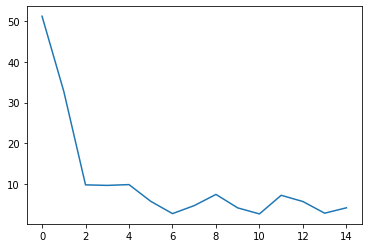

Epoch 1/15
11/11 - 8s - loss: 47.3937 - accuracy: 0.3088 - auc_149: 0.5581 - precision_149: 0.3114 - recall_149: 0.3059 - f1_score: 0.2217 - val_loss: 2.2028 - val_accuracy: 0.4793 - val_auc_149: 0.6875 - val_precision_149: 0.5870 - val_recall_149: 0.3195 - val_f1_score: 0.2447 - 8s/epoch - 707ms/step
Epoch 2/15
11/11 - 0s - loss: 20.1115 - accuracy: 0.2294 - auc_149: 0.4963 - precision_149: 0.2308 - recall_149: 0.2294 - f1_score: 0.1905 - val_loss: 1.6402 - val_accuracy: 0.2426 - val_auc_149: 0.5745 - val_precision_149: 0.2037 - val_recall_149: 0.0651 - val_f1_score: 0.1944 - 387ms/epoch - 35ms/step
Epoch 3/15
11/11 - 0s - loss: 15.2895 - accuracy: 0.3706 - auc_149: 0.6605 - precision_149: 0.3687 - recall_149: 0.3676 - f1_score: 0.2847 - val_loss: 1.6131 - val_accuracy: 0.1302 - val_auc_149: 0.5059 - val_precision_149: 0.2593 - val_recall_149: 0.0414 - val_f1_score: 0.1197 - 354ms/epoch - 32ms/step
Epoch 4/15
11/11 - 0s - loss: 3.7041 - accuracy: 0.4647 - auc_149: 0.7459 - precision_1

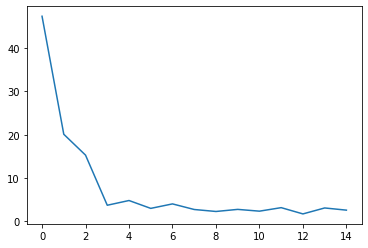

In [40]:
for train_index, val_index in kf.split(face_X):
    X_train, X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = face_y[train_index], face_y[val_index]
    face_rcnn = build_RCNN(face_features, n_length, face_outputs)
    history = train(face_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

## 2. Early Fusion - Fusion is performed at feature level

Early fusion concatenates features at the input level, then all the work is on the classifier. 

My initial assumption is that perhaps early fusion is not the best idea because the face modality is missing about half the times (OpenFace could not capture facial action units from the videos), which makes the dataset smaller. 
I did not replace the missing facial values because I thought null values will bring no benefit (I assume?) and adding for example zero would mean the absence of action units which I'm afraid might actually "trick" the model in the case where a person has pain and the facial modality was not available because of technical issues, not because of an actual lack of pain.

### About the data

In [41]:
early_X_train, early_X_test, early_y_train, early_y_test = load_earlyfusion_dataset('processed')
early_X = early_X_train.copy()
early_y = early_y_train.copy()

print(early_X_train.shape, early_y_train.shape)
print(early_X_test.shape, early_y_test.shape)

n_length, early_features, early_outputs = early_X_train.shape[2], early_X_train.shape[-1], early_y_train.shape[1]

(509, 1, 350, 48) (509, 4)
(88, 1, 350, 48) (88, 4)


In [43]:
umild, lmoderate, lmild, umoderate = np.sum(early_y, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

### Train BiLSTM (with early fusion)

Epoch 1/15
11/11 - 73s - loss: 129.5472 - accuracy: 0.3481 - auc_150: 0.5787 - precision_150: 0.3537 - recall_150: 0.3422 - f1_score: 0.2187 - val_loss: 1.5229 - val_accuracy: 0.2824 - val_auc_150: 0.4806 - val_precision_150: 0.6842 - val_recall_150: 0.0765 - val_f1_score: 0.2049 - 73s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 3.7625 - accuracy: 0.2419 - auc_150: 0.4902 - precision_150: 0.2531 - recall_150: 0.1209 - f1_score: 0.1595 - val_loss: 1.3111 - val_accuracy: 0.4353 - val_auc_150: 0.6845 - val_precision_150: 0.5000 - val_recall_150: 0.0059 - val_f1_score: 0.2340 - 3s/epoch - 253ms/step
Epoch 3/15
11/11 - 3s - loss: 3.3652 - accuracy: 0.2330 - auc_150: 0.5892 - precision_150: 0.5238 - recall_150: 0.0324 - f1_score: 0.1412 - val_loss: 1.3885 - val_accuracy: 0.0000e+00 - val_auc_150: 0.3333 - val_precision_150: 0.0000e+00 - val_recall_150: 0.0000e+00 - val_f1_score: 0.0000e+00 - 3s/epoch - 252ms/step
Epoch 4/15
11/11 - 3s - loss: 3.0849 - accuracy: 0.0059 - auc_150: 0.3373 - p

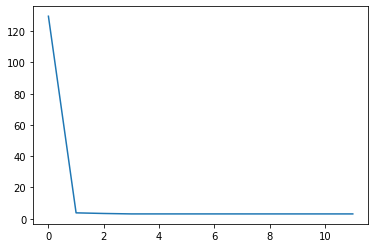

Epoch 1/15
11/11 - 70s - loss: 42.9827 - accuracy: 0.2979 - auc_151: 0.5810 - precision_151: 0.2947 - recall_151: 0.2773 - f1_score: 0.2136 - val_loss: 1.3943 - val_accuracy: 0.5471 - val_auc_151: 0.7801 - val_precision_151: 0.4839 - val_recall_151: 0.0882 - val_f1_score: 0.1843 - 70s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 5.6830 - accuracy: 0.4366 - auc_151: 0.5992 - precision_151: 0.8667 - recall_151: 0.0383 - f1_score: 0.2348 - val_loss: 1.3865 - val_accuracy: 0.3353 - val_auc_151: 0.5020 - val_precision_151: 0.0000e+00 - val_recall_151: 0.0000e+00 - val_f1_score: 0.1256 - 3s/epoch - 266ms/step
Epoch 3/15
11/11 - 3s - loss: 2.5857 - accuracy: 0.3982 - auc_151: 0.5297 - precision_151: 0.5652 - recall_151: 0.0383 - f1_score: 0.1596 - val_loss: 1.3610 - val_accuracy: 0.4235 - val_auc_151: 0.6689 - val_precision_151: 0.6842 - val_recall_151: 0.0765 - val_f1_score: 0.2218 - 3s/epoch - 266ms/step
Epoch 4/15
11/11 - 3s - loss: 2.6642 - accuracy: 0.4336 - auc_151: 0.5721 - precision_

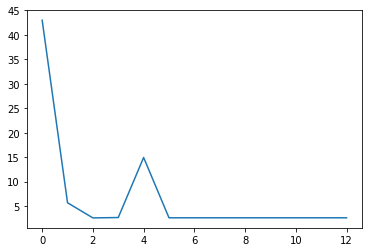

Epoch 1/15
11/11 - 70s - loss: 27.0336 - accuracy: 0.2824 - auc_152: 0.5452 - precision_152: 0.2802 - recall_152: 0.2118 - f1_score: 0.1911 - val_loss: 1.4979 - val_accuracy: 0.1598 - val_auc_152: 0.4516 - val_precision_152: 1.0000 - val_recall_152: 0.0059 - val_f1_score: 0.0999 - 70s/epoch - 6s/step
Epoch 2/15
11/11 - 3s - loss: 3.0681 - accuracy: 0.1353 - auc_152: 0.3979 - precision_152: 0.0333 - recall_152: 0.0029 - f1_score: 0.0938 - val_loss: 1.1209 - val_accuracy: 0.4201 - val_auc_152: 0.7297 - val_precision_152: 0.5000 - val_recall_152: 0.0533 - val_f1_score: 0.2126 - 3s/epoch - 264ms/step
Epoch 3/15
11/11 - 3s - loss: 6.0360 - accuracy: 0.4265 - auc_152: 0.7392 - precision_152: 0.5120 - recall_152: 0.2500 - f1_score: 0.2745 - val_loss: 1.3734 - val_accuracy: 0.4320 - val_auc_152: 0.6618 - val_precision_152: 0.7333 - val_recall_152: 0.0651 - val_f1_score: 0.2545 - 3s/epoch - 263ms/step
Epoch 4/15
11/11 - 3s - loss: 3.2266 - accuracy: 0.2735 - auc_152: 0.3992 - precision_152: 0.0

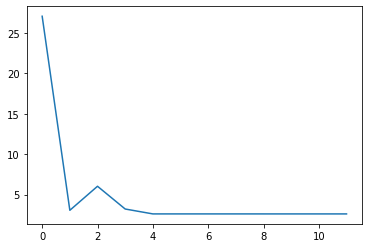

In [44]:
for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_biConvLSTM = build_biConvLSTM(early_features, n_length, early_outputs)
    history = train(early_biConvLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

### Train CNN+LSTM (with early fusion)

Epoch 1/15
11/11 - 31s - loss: 3.1229 - accuracy: 0.5133 - auc_153: 0.6500 - precision_153: 0.0000e+00 - recall_153: 0.0000e+00 - f1_score: 0.1816 - val_loss: 1.3740 - val_accuracy: 0.4706 - val_auc_153: 0.6137 - val_precision_153: 0.0000e+00 - val_recall_153: 0.0000e+00 - val_f1_score: 0.1600 - 31s/epoch - 3s/step
Epoch 2/15
11/11 - 0s - loss: 3.0950 - accuracy: 0.2035 - auc_153: 0.5228 - precision_153: 0.0000e+00 - recall_153: 0.0000e+00 - f1_score: 0.1092 - val_loss: 1.4102 - val_accuracy: 0.0000e+00 - val_auc_153: 0.4020 - val_precision_153: 0.0000e+00 - val_recall_153: 0.0000e+00 - val_f1_score: 0.0000e+00 - 422ms/epoch - 38ms/step
Epoch 3/15
11/11 - 0s - loss: 3.0684 - accuracy: 0.0059 - auc_153: 0.4503 - precision_153: 0.0000e+00 - recall_153: 0.0000e+00 - f1_score: 0.0029 - val_loss: 1.4230 - val_accuracy: 0.0000e+00 - val_auc_153: 0.4020 - val_precision_153: 0.0000e+00 - val_recall_153: 0.0000e+00 - val_f1_score: 0.0000e+00 - 418ms/epoch - 38ms/step
Epoch 4/15
11/11 - 0s - los

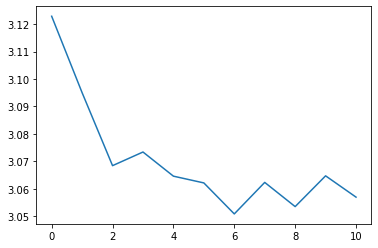

Epoch 1/15
11/11 - 20s - loss: 2.6485 - accuracy: 0.2714 - auc_154: 0.6677 - precision_154: 0.0000e+00 - recall_154: 0.0000e+00 - f1_score: 0.1375 - val_loss: 1.3184 - val_accuracy: 0.3412 - val_auc_154: 0.7451 - val_precision_154: 0.0000e+00 - val_recall_154: 0.0000e+00 - val_f1_score: 0.1272 - 20s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 2.6188 - accuracy: 0.3923 - auc_154: 0.6762 - precision_154: 0.0000e+00 - recall_154: 0.0000e+00 - f1_score: 0.1409 - val_loss: 1.3276 - val_accuracy: 0.3412 - val_auc_154: 0.5905 - val_precision_154: 0.0000e+00 - val_recall_154: 0.0000e+00 - val_f1_score: 0.1272 - 477ms/epoch - 43ms/step
Epoch 3/15
11/11 - 0s - loss: 2.6127 - accuracy: 0.3923 - auc_154: 0.6687 - precision_154: 0.0000e+00 - recall_154: 0.0000e+00 - f1_score: 0.1409 - val_loss: 1.3077 - val_accuracy: 0.3412 - val_auc_154: 0.7454 - val_precision_154: 0.0000e+00 - val_recall_154: 0.0000e+00 - val_f1_score: 0.1272 - 472ms/epoch - 43ms/step
Epoch 4/15
11/11 - 0s - loss: 2.5917 - accu

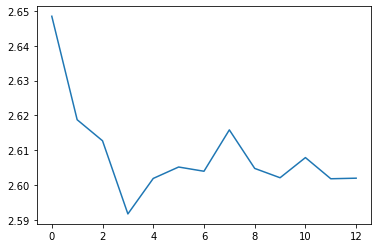

Epoch 1/15
11/11 - 20s - loss: 2.6268 - accuracy: 0.1059 - auc_155: 0.5201 - precision_155: 0.0000e+00 - recall_155: 0.0000e+00 - f1_score: 0.0619 - val_loss: 1.3723 - val_accuracy: 0.0888 - val_auc_155: 0.5740 - val_precision_155: 0.0000e+00 - val_recall_155: 0.0000e+00 - val_f1_score: 0.0408 - 20s/epoch - 2s/step
Epoch 2/15
11/11 - 0s - loss: 2.6200 - accuracy: 0.0971 - auc_155: 0.5549 - precision_155: 0.0000e+00 - recall_155: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.3701 - val_accuracy: 0.0888 - val_auc_155: 0.5393 - val_precision_155: 0.0000e+00 - val_recall_155: 0.0000e+00 - val_f1_score: 0.0408 - 455ms/epoch - 41ms/step
Epoch 3/15
11/11 - 0s - loss: 2.6466 - accuracy: 0.0971 - auc_155: 0.5459 - precision_155: 0.0000e+00 - recall_155: 0.0000e+00 - f1_score: 0.0442 - val_loss: 1.3381 - val_accuracy: 0.0888 - val_auc_155: 0.5414 - val_precision_155: 0.0000e+00 - val_recall_155: 0.0000e+00 - val_f1_score: 0.0408 - 493ms/epoch - 45ms/step
Epoch 4/15
11/11 - 0s - loss: 2.6340 - accu

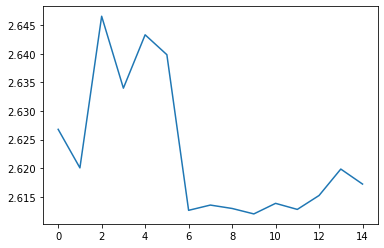

In [45]:
for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_cnn = build_CNN(early_features, n_length, early_outputs)
    history = train(early_cnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

### Train ConvLSTM (with early fusion)

Epoch 1/15
11/11 - 27s - loss: 23.7221 - accuracy: 0.3717 - auc_156: 0.5776 - precision_156: 0.3671 - recall_156: 0.3097 - f1_score: 0.2368 - val_loss: 1.3821 - val_accuracy: 0.2765 - val_auc_156: 0.5602 - val_precision_156: 0.4545 - val_recall_156: 0.0294 - val_f1_score: 0.1684 - 27s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 3.0947 - accuracy: 0.0560 - auc_156: 0.4047 - precision_156: 0.0667 - recall_156: 0.0088 - f1_score: 0.0533 - val_loss: 1.3730 - val_accuracy: 0.0824 - val_auc_156: 0.4238 - val_precision_156: 0.5000 - val_recall_156: 0.0059 - val_f1_score: 0.0785 - 1s/epoch - 105ms/step
Epoch 3/15
11/11 - 1s - loss: 3.1383 - accuracy: 0.1062 - auc_156: 0.4769 - precision_156: 0.7391 - recall_156: 0.0501 - f1_score: 0.0843 - val_loss: 1.4105 - val_accuracy: 0.0059 - val_auc_156: 0.3526 - val_precision_156: 0.3333 - val_recall_156: 0.0059 - val_f1_score: 0.0066 - 1s/epoch - 107ms/step
Epoch 4/15
11/11 - 1s - loss: 3.0541 - accuracy: 0.0324 - auc_156: 0.3687 - precision_156: 1.0

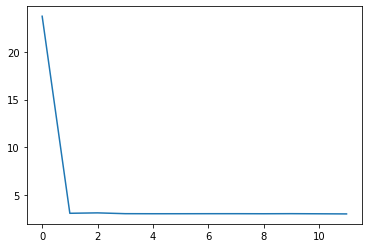

Epoch 1/15
11/11 - 28s - loss: 15.8942 - accuracy: 0.2920 - auc_157: 0.5535 - precision_157: 0.2804 - recall_157: 0.2242 - f1_score: 0.2157 - val_loss: 1.4524 - val_accuracy: 0.2235 - val_auc_157: 0.5631 - val_precision_157: 0.2353 - val_recall_157: 0.0941 - val_f1_score: 0.1584 - 28s/epoch - 3s/step
Epoch 2/15
11/11 - 1s - loss: 4.2482 - accuracy: 0.3894 - auc_157: 0.7171 - precision_157: 0.4407 - recall_157: 0.1534 - f1_score: 0.2632 - val_loss: 1.3544 - val_accuracy: 0.3059 - val_auc_157: 0.6804 - val_precision_157: 0.3717 - val_recall_157: 0.2471 - val_f1_score: 0.1793 - 1s/epoch - 101ms/step
Epoch 3/15
11/11 - 1s - loss: 2.9542 - accuracy: 0.3009 - auc_157: 0.6296 - precision_157: 0.2721 - recall_157: 0.1180 - f1_score: 0.2232 - val_loss: 1.3203 - val_accuracy: 0.1824 - val_auc_157: 0.5714 - val_precision_157: 0.4000 - val_recall_157: 0.0118 - val_f1_score: 0.1489 - 1s/epoch - 102ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4175 - accuracy: 0.3746 - auc_157: 0.7221 - precision_157: 0.5

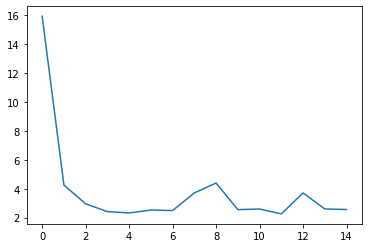

Epoch 1/15
11/11 - 26s - loss: 60.2137 - accuracy: 0.2882 - auc_158: 0.5207 - precision_158: 0.2936 - recall_158: 0.2824 - f1_score: 0.2178 - val_loss: 1.3367 - val_accuracy: 0.3254 - val_auc_158: 0.6807 - val_precision_158: 0.3462 - val_recall_158: 0.2130 - val_f1_score: 0.2189 - 26s/epoch - 2s/step
Epoch 2/15
11/11 - 1s - loss: 5.9621 - accuracy: 0.4059 - auc_158: 0.7013 - precision_158: 0.3908 - recall_158: 0.2735 - f1_score: 0.2670 - val_loss: 2.4304 - val_accuracy: 0.3905 - val_auc_158: 0.7001 - val_precision_158: 0.5849 - val_recall_158: 0.1834 - val_f1_score: 0.2461 - 1s/epoch - 108ms/step
Epoch 3/15
11/11 - 1s - loss: 3.5791 - accuracy: 0.1853 - auc_158: 0.5111 - precision_158: 0.6250 - recall_158: 0.0441 - f1_score: 0.1315 - val_loss: 1.3844 - val_accuracy: 0.2308 - val_auc_158: 0.6060 - val_precision_158: 0.3864 - val_recall_158: 0.1006 - val_f1_score: 0.1662 - 1s/epoch - 104ms/step
Epoch 4/15
11/11 - 1s - loss: 2.8113 - accuracy: 0.1618 - auc_158: 0.4771 - precision_158: 0.5

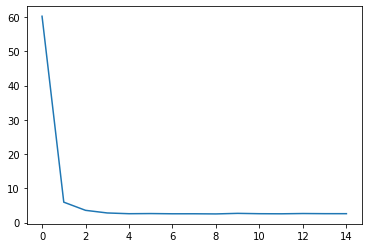

In [46]:
for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_convLSTM = build_convLSTM(early_features, n_length, early_outputs)
    history = train(early_convLSTM, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

### Train RCNN (with early fusion)

Epoch 1/15
11/11 - 8s - loss: 90.3355 - accuracy: 0.3717 - auc_159: 0.5984 - precision_159: 0.3818 - recall_159: 0.3717 - f1_score: 0.2475 - val_loss: 143.0861 - val_accuracy: 0.4294 - val_auc_159: 0.6196 - val_precision_159: 0.4294 - val_recall_159: 0.4294 - val_f1_score: 0.1502 - 8s/epoch - 714ms/step
Epoch 2/15
11/11 - 0s - loss: 30.4374 - accuracy: 0.3392 - auc_159: 0.5730 - precision_159: 0.3392 - recall_159: 0.3392 - f1_score: 0.2506 - val_loss: 22.3974 - val_accuracy: 0.3059 - val_auc_159: 0.5392 - val_precision_159: 0.3059 - val_recall_159: 0.3059 - val_f1_score: 0.1814 - 362ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 127.6798 - accuracy: 0.4336 - auc_159: 0.6725 - precision_159: 0.4320 - recall_159: 0.4307 - f1_score: 0.3138 - val_loss: 74.2321 - val_accuracy: 0.4294 - val_auc_159: 0.6196 - val_precision_159: 0.4294 - val_recall_159: 0.4294 - val_f1_score: 0.1502 - 371ms/epoch - 34ms/step
Epoch 4/15
11/11 - 0s - loss: 15.8716 - accuracy: 0.3333 - auc_159: 0.6095 - preci

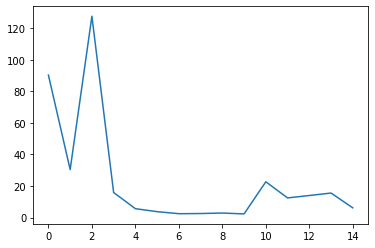

Epoch 1/15
11/11 - 8s - loss: 67.4304 - accuracy: 0.3451 - auc_160: 0.6046 - precision_160: 0.3503 - recall_160: 0.3451 - f1_score: 0.2428 - val_loss: 76.0042 - val_accuracy: 0.5588 - val_auc_160: 0.7059 - val_precision_160: 0.5588 - val_recall_160: 0.5588 - val_f1_score: 0.1792 - 8s/epoch - 715ms/step
Epoch 2/15
11/11 - 0s - loss: 20.6656 - accuracy: 0.3038 - auc_160: 0.5475 - precision_160: 0.3015 - recall_160: 0.2979 - f1_score: 0.2266 - val_loss: 128.3391 - val_accuracy: 0.5588 - val_auc_160: 0.7059 - val_precision_160: 0.5588 - val_recall_160: 0.5588 - val_f1_score: 0.1792 - 411ms/epoch - 37ms/step
Epoch 3/15
11/11 - 0s - loss: 17.3981 - accuracy: 0.3805 - auc_160: 0.6246 - precision_160: 0.3821 - recall_160: 0.3776 - f1_score: 0.2737 - val_loss: 23.3399 - val_accuracy: 0.3412 - val_auc_160: 0.5715 - val_precision_160: 0.3412 - val_recall_160: 0.3412 - val_f1_score: 0.1387 - 341ms/epoch - 31ms/step
Epoch 4/15
11/11 - 0s - loss: 7.3098 - accuracy: 0.4808 - auc_160: 0.7458 - precisi

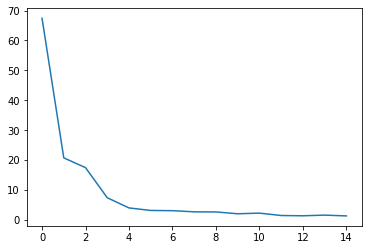

Epoch 1/15
11/11 - 8s - loss: 115.0993 - accuracy: 0.3265 - auc_161: 0.5572 - precision_161: 0.3242 - recall_161: 0.3118 - f1_score: 0.2309 - val_loss: 113.5000 - val_accuracy: 0.5503 - val_auc_161: 0.7002 - val_precision_161: 0.5503 - val_recall_161: 0.5503 - val_f1_score: 0.1775 - 8s/epoch - 689ms/step
Epoch 2/15
11/11 - 0s - loss: 11.2623 - accuracy: 0.4382 - auc_161: 0.6486 - precision_161: 0.4358 - recall_161: 0.4294 - f1_score: 0.3309 - val_loss: 17.2394 - val_accuracy: 0.4379 - val_auc_161: 0.6534 - val_precision_161: 0.4379 - val_recall_161: 0.4379 - val_f1_score: 0.2201 - 363ms/epoch - 33ms/step
Epoch 3/15
11/11 - 0s - loss: 26.9390 - accuracy: 0.5147 - auc_161: 0.7299 - precision_161: 0.5208 - recall_161: 0.5147 - f1_score: 0.3649 - val_loss: 40.4468 - val_accuracy: 0.3550 - val_auc_161: 0.5700 - val_precision_161: 0.3550 - val_recall_161: 0.3550 - val_f1_score: 0.1310 - 382ms/epoch - 35ms/step
Epoch 4/15
11/11 - 0s - loss: 9.8417 - accuracy: 0.4412 - auc_161: 0.6746 - precis

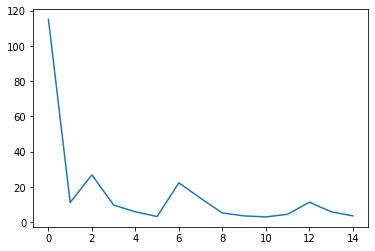

In [47]:
for train_index, val_index in kf.split(early_X):
    X_train, X_val = early_X[train_index], early_X[val_index]
    y_train, y_val = early_y[train_index], early_y[val_index]
    early_rcnn = build_RCNN(early_features, n_length, early_outputs)
    history = train(early_rcnn, X_train, y_train, X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

## 3. Late Fusion - Fusion is performed at decision level

In late fusion, I test two approaches, in both uni-modal classifiers are trained individually, and then either: 

- Their final dense (decision) layer is concatenated to produce the final prediction; or 

- Ensemble the uni-modal classifiers.

Just as with early fusion, we have the issue that the face modality is missing about half of the times and therefore, I can only use late fusion if both modalities are present.

In [48]:
body_X_train, body_X_test, y_train, y_test = load_latefusion_dataset('processed', 'skeleton')
body_X = body_X_train.copy()
y = y_train.copy()

print(body_X_train.shape, y_train.shape)
print(body_X_test.shape, y_test.shape)

n_length, body_features, body_outputs = body_X_train.shape[2], body_X_train.shape[-1], y_train.shape[1]

(509, 1, 350, 38) (509, 4)
(88, 1, 350, 38) (88, 4)


In [50]:
umild, lmoderate, lmild, umoderate = np.sum(y_train, axis=0)
total = umild + lmoderate + lmild + umoderate

weight_for_0 = (1 / umild) * (total / 2.0)
weight_for_1 = (1 / lmoderate) * (total / 2.0)
weight_for_2 = (1 / lmild) * (total / 2.0)
weight_for_3 = (1 / umoderate) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

### BiLSTM (concatenate decision layer)

Epoch 1/15
11/11 - 143s - loss: 9.3494 - accuracy: 0.3776 - auc_162: 0.6559 - precision_162: 0.3983 - recall_162: 0.2832 - f1_score: 0.2310 - val_loss: 1.1675 - val_accuracy: 0.4588 - val_auc_162: 0.7569 - val_precision_162: 0.5039 - val_recall_162: 0.3824 - val_f1_score: 0.2143 - 143s/epoch - 13s/step
Epoch 2/15
11/11 - 5s - loss: 5.7031 - accuracy: 0.2330 - auc_162: 0.5249 - precision_162: 0.2593 - recall_162: 0.1445 - f1_score: 0.1691 - val_loss: 1.3725 - val_accuracy: 0.2000 - val_auc_162: 0.5407 - val_precision_162: 0.4000 - val_recall_162: 0.0118 - val_f1_score: 0.1000 - 5s/epoch - 497ms/step
Epoch 3/15
11/11 - 6s - loss: 3.6580 - accuracy: 0.2183 - auc_162: 0.4776 - precision_162: 0.4500 - recall_162: 0.0531 - f1_score: 0.1657 - val_loss: 1.4211 - val_accuracy: 0.0059 - val_auc_162: 0.2342 - val_precision_162: 0.0000e+00 - val_recall_162: 0.0000e+00 - val_f1_score: 0.0062 - 6s/epoch - 507ms/step
Epoch 4/15
11/11 - 6s - loss: 4.1800 - accuracy: 0.2094 - auc_162: 0.5155 - precisio

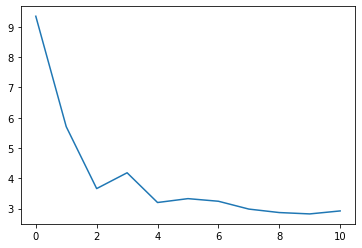

Epoch 1/15
11/11 - 137s - loss: 8.2488 - accuracy: 0.4336 - auc_163: 0.6502 - precision_163: 0.3767 - recall_163: 0.2478 - f1_score: 0.2527 - val_loss: 1.4103 - val_accuracy: 0.4000 - val_auc_163: 0.6521 - val_precision_163: 0.5455 - val_recall_163: 0.1412 - val_f1_score: 0.2660 - 137s/epoch - 12s/step
Epoch 2/15
11/11 - 5s - loss: 4.2125 - accuracy: 0.3156 - auc_163: 0.5962 - precision_163: 0.3234 - recall_163: 0.1593 - f1_score: 0.2230 - val_loss: 2.8031 - val_accuracy: 0.0941 - val_auc_163: 0.5500 - val_precision_163: 0.0970 - val_recall_163: 0.0941 - val_f1_score: 0.0432 - 5s/epoch - 497ms/step
Epoch 3/15
11/11 - 5s - loss: 5.0186 - accuracy: 0.2478 - auc_163: 0.5203 - precision_163: 0.2399 - recall_163: 0.2094 - f1_score: 0.1900 - val_loss: 1.3538 - val_accuracy: 0.4765 - val_auc_163: 0.6181 - val_precision_163: 1.0000 - val_recall_163: 0.0176 - val_f1_score: 0.2447 - 5s/epoch - 494ms/step
Epoch 4/15
11/11 - 6s - loss: 2.6864 - accuracy: 0.2625 - auc_163: 0.5344 - precision_163: 0

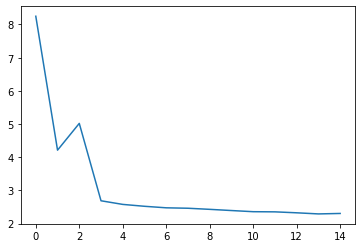

Epoch 1/15
11/11 - 147s - loss: 17.5319 - accuracy: 0.3176 - auc_164: 0.5991 - precision_164: 0.3146 - recall_164: 0.2794 - f1_score: 0.2250 - val_loss: 1.6453 - val_accuracy: 0.3905 - val_auc_164: 0.5959 - val_precision_164: 0.3788 - val_recall_164: 0.2959 - val_f1_score: 0.1726 - 147s/epoch - 13s/step
Epoch 2/15
11/11 - 5s - loss: 2.9233 - accuracy: 0.3324 - auc_164: 0.6313 - precision_164: 0.3243 - recall_164: 0.2118 - f1_score: 0.2304 - val_loss: 1.3432 - val_accuracy: 0.3787 - val_auc_164: 0.6569 - val_precision_164: 0.4247 - val_recall_164: 0.1834 - val_f1_score: 0.2164 - 5s/epoch - 492ms/step
Epoch 3/15
11/11 - 5s - loss: 3.5450 - accuracy: 0.2794 - auc_164: 0.6214 - precision_164: 0.2645 - recall_164: 0.1206 - f1_score: 0.1997 - val_loss: 1.7835 - val_accuracy: 0.0888 - val_auc_164: 0.5174 - val_precision_164: 0.1064 - val_recall_164: 0.0888 - val_f1_score: 0.0431 - 5s/epoch - 499ms/step
Epoch 4/15
11/11 - 5s - loss: 3.6533 - accuracy: 0.2882 - auc_164: 0.6089 - precision_164: 

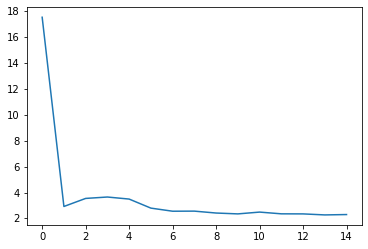

In [51]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    biLSTM = build_fusioned_biConvLSTM(body_features, face_features, n_length, body_outputs)
    history = train_fusioned(biLSTM, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

### CNN+LSTM (concatenate decision layer)

Epoch 1/15
11/11 - 48s - loss: 3.0473 - accuracy: 0.4631 - auc_165: 0.7221 - precision_165: 0.0000e+00 - recall_165: 0.0000e+00 - f1_score: 0.2059 - val_loss: 1.1717 - val_accuracy: 0.4706 - val_auc_165: 0.7710 - val_precision_165: 0.0000e+00 - val_recall_165: 0.0000e+00 - val_f1_score: 0.1600 - 48s/epoch - 4s/step
Epoch 2/15
11/11 - 1s - loss: 3.2784 - accuracy: 0.4602 - auc_165: 0.7269 - precision_165: 0.0000e+00 - recall_165: 0.0000e+00 - f1_score: 0.1810 - val_loss: 1.3166 - val_accuracy: 0.2588 - val_auc_165: 0.5635 - val_precision_165: 0.0000e+00 - val_recall_165: 0.0000e+00 - val_f1_score: 0.1310 - 544ms/epoch - 49ms/step
Epoch 3/15
11/11 - 1s - loss: 2.9625 - accuracy: 0.3658 - auc_165: 0.6317 - precision_165: 0.0000e+00 - recall_165: 0.0000e+00 - f1_score: 0.1898 - val_loss: 1.2921 - val_accuracy: 0.2647 - val_auc_165: 0.5667 - val_precision_165: 0.0000e+00 - val_recall_165: 0.0000e+00 - val_f1_score: 0.1324 - 618ms/epoch - 56ms/step
Epoch 4/15
11/11 - 1s - loss: 2.8686 - accu

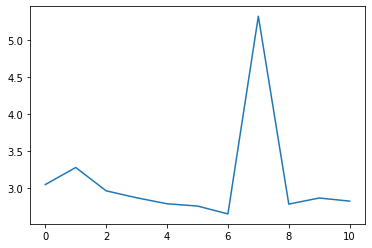

Epoch 1/15
11/11 - 34s - loss: 2.5802 - accuracy: 0.1003 - auc_166: 0.5526 - precision_166: 0.0000e+00 - recall_166: 0.0000e+00 - f1_score: 0.0590 - val_loss: 1.2821 - val_accuracy: 0.0941 - val_auc_166: 0.5246 - val_precision_166: 0.0000e+00 - val_recall_166: 0.0000e+00 - val_f1_score: 0.0430 - 34s/epoch - 3s/step
Epoch 2/15
11/11 - 1s - loss: 2.6582 - accuracy: 0.3245 - auc_166: 0.6614 - precision_166: 0.0000e+00 - recall_166: 0.0000e+00 - f1_score: 0.2026 - val_loss: 1.2511 - val_accuracy: 0.5059 - val_auc_166: 0.8002 - val_precision_166: 0.0000e+00 - val_recall_166: 0.0000e+00 - val_f1_score: 0.2590 - 605ms/epoch - 55ms/step
Epoch 3/15
11/11 - 1s - loss: 2.5845 - accuracy: 0.4779 - auc_166: 0.7184 - precision_166: 0.0000e+00 - recall_166: 0.0000e+00 - f1_score: 0.2547 - val_loss: 1.2887 - val_accuracy: 0.4706 - val_auc_166: 0.6734 - val_precision_166: 0.0000e+00 - val_recall_166: 0.0000e+00 - val_f1_score: 0.2851 - 622ms/epoch - 57ms/step
Epoch 4/15
11/11 - 1s - loss: 2.5451 - accu

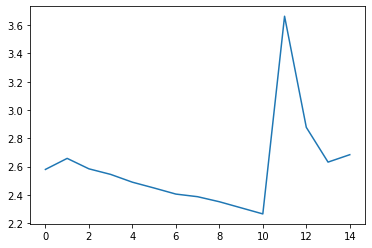

Epoch 1/15
11/11 - 34s - loss: 2.5801 - accuracy: 0.3647 - auc_167: 0.6876 - precision_167: 0.0000e+00 - recall_167: 0.0000e+00 - f1_score: 0.1962 - val_loss: 1.2131 - val_accuracy: 0.5503 - val_auc_167: 0.7778 - val_precision_167: 0.0000e+00 - val_recall_167: 0.0000e+00 - val_f1_score: 0.1775 - 34s/epoch - 3s/step
Epoch 2/15
11/11 - 1s - loss: 2.5632 - accuracy: 0.3794 - auc_167: 0.7201 - precision_167: 0.0000e+00 - recall_167: 0.0000e+00 - f1_score: 0.2047 - val_loss: 1.2222 - val_accuracy: 0.2485 - val_auc_167: 0.6845 - val_precision_167: 0.0000e+00 - val_recall_167: 0.0000e+00 - val_f1_score: 0.1597 - 546ms/epoch - 50ms/step
Epoch 3/15
11/11 - 1s - loss: 2.6510 - accuracy: 0.3735 - auc_167: 0.7046 - precision_167: 0.0000e+00 - recall_167: 0.0000e+00 - f1_score: 0.2149 - val_loss: 1.2332 - val_accuracy: 0.4320 - val_auc_167: 0.7052 - val_precision_167: 0.0000e+00 - val_recall_167: 0.0000e+00 - val_f1_score: 0.2698 - 595ms/epoch - 54ms/step
Epoch 4/15
11/11 - 1s - loss: 2.4836 - accu

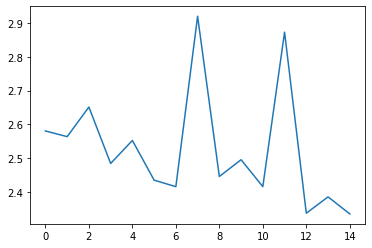

In [52]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    CNNLSTM = build_fusioned_CNN(body_features, face_features, n_length, body_outputs)
    history = train_fusioned(CNNLSTM, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

### ConvLSTM (concatenate decision layer)

Epoch 1/15
11/11 - 48s - loss: 15.8208 - accuracy: 0.3215 - auc_168: 0.6316 - precision_168: 0.3208 - recall_168: 0.3009 - f1_score: 0.2229 - val_loss: 1.1402 - val_accuracy: 0.4412 - val_auc_168: 0.7106 - val_precision_168: 0.4167 - val_recall_168: 0.2059 - val_f1_score: 0.1686 - 48s/epoch - 4s/step
Epoch 2/15
11/11 - 2s - loss: 4.7793 - accuracy: 0.3481 - auc_168: 0.6497 - precision_168: 0.3463 - recall_168: 0.2094 - f1_score: 0.2324 - val_loss: 1.6741 - val_accuracy: 0.1529 - val_auc_168: 0.4921 - val_precision_168: 0.3000 - val_recall_168: 0.0176 - val_f1_score: 0.0992 - 2s/epoch - 194ms/step
Epoch 3/15
11/11 - 2s - loss: 3.1821 - accuracy: 0.3835 - auc_168: 0.7140 - precision_168: 0.5333 - recall_168: 0.1180 - f1_score: 0.2640 - val_loss: 1.3077 - val_accuracy: 0.2588 - val_auc_168: 0.5767 - val_precision_168: 0.3333 - val_recall_168: 0.0235 - val_f1_score: 0.1778 - 2s/epoch - 188ms/step
Epoch 4/15
11/11 - 2s - loss: 2.9584 - accuracy: 0.3392 - auc_168: 0.6041 - precision_168: 0.5

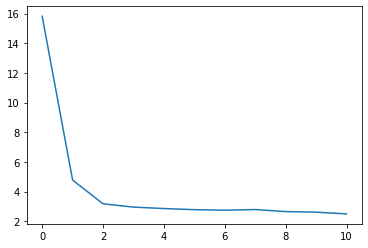

Epoch 1/15
11/11 - 56s - loss: 6.0979 - accuracy: 0.2684 - auc_169: 0.5815 - precision_169: 0.2181 - recall_169: 0.1563 - f1_score: 0.2170 - val_loss: 1.8915 - val_accuracy: 0.4412 - val_auc_169: 0.6544 - val_precision_169: 0.6316 - val_recall_169: 0.2118 - val_f1_score: 0.2322 - 56s/epoch - 5s/step
Epoch 2/15
11/11 - 2s - loss: 3.0811 - accuracy: 0.2507 - auc_169: 0.5805 - precision_169: 0.3889 - recall_169: 0.0413 - f1_score: 0.1754 - val_loss: 1.2573 - val_accuracy: 0.4176 - val_auc_169: 0.6656 - val_precision_169: 0.0000e+00 - val_recall_169: 0.0000e+00 - val_f1_score: 0.2280 - 2s/epoch - 186ms/step
Epoch 3/15
11/11 - 2s - loss: 2.5658 - accuracy: 0.4661 - auc_169: 0.7368 - precision_169: 0.8889 - recall_169: 0.0236 - f1_score: 0.2382 - val_loss: 1.1687 - val_accuracy: 0.5588 - val_auc_169: 0.7874 - val_precision_169: 0.2857 - val_recall_169: 0.0118 - val_f1_score: 0.2373 - 2s/epoch - 190ms/step
Epoch 4/15
11/11 - 2s - loss: 2.4538 - accuracy: 0.3097 - auc_169: 0.6814 - precision_1

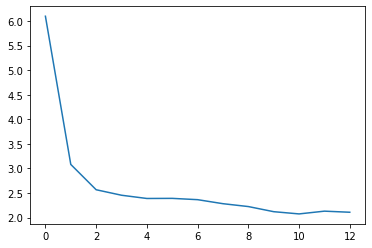

Epoch 1/15
11/11 - 49s - loss: 11.2686 - accuracy: 0.3382 - auc_170: 0.6382 - precision_170: 0.3708 - recall_170: 0.2912 - f1_score: 0.2270 - val_loss: 1.2353 - val_accuracy: 0.3846 - val_auc_170: 0.7176 - val_precision_170: 0.4250 - val_recall_170: 0.1006 - val_f1_score: 0.2068 - 49s/epoch - 4s/step
Epoch 2/15
11/11 - 2s - loss: 3.5286 - accuracy: 0.3324 - auc_170: 0.6572 - precision_170: 0.3818 - recall_170: 0.0618 - f1_score: 0.2275 - val_loss: 1.4031 - val_accuracy: 0.3136 - val_auc_170: 0.6052 - val_precision_170: 0.3077 - val_recall_170: 0.0947 - val_f1_score: 0.2300 - 2s/epoch - 189ms/step
Epoch 3/15
11/11 - 2s - loss: 3.3260 - accuracy: 0.3882 - auc_170: 0.6702 - precision_170: 0.4870 - recall_170: 0.2206 - f1_score: 0.2634 - val_loss: 1.5777 - val_accuracy: 0.3787 - val_auc_170: 0.7371 - val_precision_170: 0.3973 - val_recall_170: 0.3432 - val_f1_score: 0.1751 - 2s/epoch - 187ms/step
Epoch 4/15
11/11 - 2s - loss: 4.7671 - accuracy: 0.2265 - auc_170: 0.5320 - precision_170: 0.4

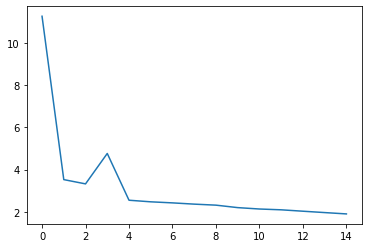

In [53]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    convLSTM = build_fusioned_convLSTM(body_features, face_features, n_length, body_outputs)
    history = train_fusioned(convLSTM, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

### RCNN (concatenate decision layer)

Epoch 1/15
11/11 - 11s - loss: 70.0580 - accuracy: 0.3422 - auc_171: 0.5699 - precision_171: 0.3434 - recall_171: 0.3363 - f1_score: 0.2438 - val_loss: 106.4755 - val_accuracy: 0.4706 - val_auc_171: 0.6471 - val_precision_171: 0.4706 - val_recall_171: 0.4706 - val_f1_score: 0.1600 - 11s/epoch - 988ms/step
Epoch 2/15
11/11 - 0s - loss: 72.5752 - accuracy: 0.4454 - auc_171: 0.6571 - precision_171: 0.4454 - recall_171: 0.4454 - f1_score: 0.2864 - val_loss: 40.3527 - val_accuracy: 0.4059 - val_auc_171: 0.6071 - val_precision_171: 0.4059 - val_recall_171: 0.4059 - val_f1_score: 0.1481 - 497ms/epoch - 45ms/step
Epoch 3/15
11/11 - 1s - loss: 27.5731 - accuracy: 0.2950 - auc_171: 0.5414 - precision_171: 0.2959 - recall_171: 0.2950 - f1_score: 0.2359 - val_loss: 47.3789 - val_accuracy: 0.4294 - val_auc_171: 0.6195 - val_precision_171: 0.4294 - val_recall_171: 0.4294 - val_f1_score: 0.1502 - 505ms/epoch - 46ms/step
Epoch 4/15
11/11 - 1s - loss: 15.0670 - accuracy: 0.4572 - auc_171: 0.6692 - prec

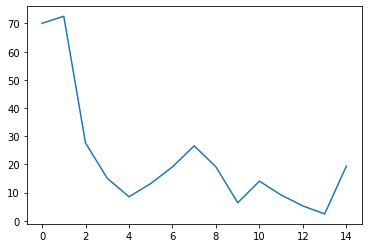

Epoch 1/15
11/11 - 11s - loss: 76.0884 - accuracy: 0.3540 - auc_172: 0.5780 - precision_172: 0.3494 - recall_172: 0.3422 - f1_score: 0.2451 - val_loss: 303.7135 - val_accuracy: 0.3412 - val_auc_172: 0.5608 - val_precision_172: 0.3412 - val_recall_172: 0.3412 - val_f1_score: 0.1272 - 11s/epoch - 996ms/step
Epoch 2/15
11/11 - 0s - loss: 51.7237 - accuracy: 0.2950 - auc_172: 0.5396 - precision_172: 0.2929 - recall_172: 0.2920 - f1_score: 0.2250 - val_loss: 67.5061 - val_accuracy: 0.5588 - val_auc_172: 0.7059 - val_precision_172: 0.5588 - val_recall_172: 0.5588 - val_f1_score: 0.1792 - 494ms/epoch - 45ms/step
Epoch 3/15
11/11 - 1s - loss: 22.0807 - accuracy: 0.3982 - auc_172: 0.6291 - precision_172: 0.3982 - recall_172: 0.3982 - f1_score: 0.2940 - val_loss: 37.9688 - val_accuracy: 0.5588 - val_auc_172: 0.7059 - val_precision_172: 0.5588 - val_recall_172: 0.5588 - val_f1_score: 0.1792 - 519ms/epoch - 47ms/step
Epoch 4/15
11/11 - 0s - loss: 8.9419 - accuracy: 0.4484 - auc_172: 0.6985 - preci

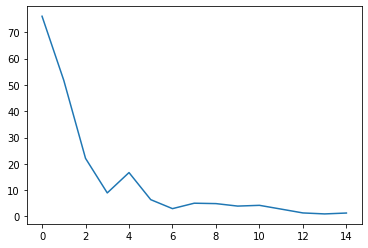

Epoch 1/15
11/11 - 11s - loss: 75.0866 - accuracy: 0.2912 - auc_173: 0.5390 - precision_173: 0.2934 - recall_173: 0.2882 - f1_score: 0.2006 - val_loss: 145.8048 - val_accuracy: 0.3550 - val_auc_173: 0.5700 - val_precision_173: 0.3550 - val_recall_173: 0.3550 - val_f1_score: 0.1310 - 11s/epoch - 997ms/step
Epoch 2/15
11/11 - 0s - loss: 27.6608 - accuracy: 0.4265 - auc_173: 0.6720 - precision_173: 0.4260 - recall_173: 0.4235 - f1_score: 0.3077 - val_loss: 29.6458 - val_accuracy: 0.5030 - val_auc_173: 0.6707 - val_precision_173: 0.5030 - val_recall_173: 0.5030 - val_f1_score: 0.1700 - 491ms/epoch - 45ms/step
Epoch 3/15
11/11 - 1s - loss: 7.2696 - accuracy: 0.4853 - auc_173: 0.7211 - precision_173: 0.4882 - recall_173: 0.4853 - f1_score: 0.3822 - val_loss: 14.2946 - val_accuracy: 0.4379 - val_auc_173: 0.6657 - val_precision_173: 0.4379 - val_recall_173: 0.4379 - val_f1_score: 0.2288 - 517ms/epoch - 47ms/step
Epoch 4/15
11/11 - 0s - loss: 2.8308 - accuracy: 0.6029 - auc_173: 0.8260 - precis

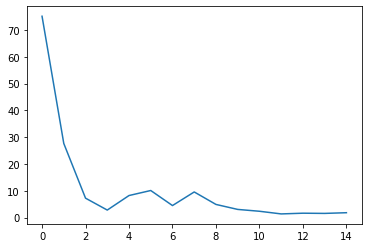

In [54]:
for train_index, val_index in kf.split(body_X):
    body_X_train, body_X_val = body_X[train_index], body_X[val_index]
    face_X_train, face_X_val = face_X[train_index], face_X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    RCNN = build_fusioned_RCNN(body_features, face_features, n_length, body_outputs)
    history = train_fusioned(RCNN, body_X_train, face_X_train, y_train, body_X_val, face_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)
    plt.plot(history.history['loss'])
    plt.show()

### Convert Uni-modal Approaches to Ensemble Members

In [55]:
biLSTM_body_model = build_biConvLSTM(body_features, n_length, body_outputs)
train(biLSTM_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/15
11/11 - 81s - loss: 26.8714 - accuracy: 0.3588 - auc_174: 0.6220 - precision_174: 0.3522 - recall_174: 0.3118 - f1_score: 0.2416 - val_loss: 2.4095 - val_accuracy: 0.0888 - val_auc_174: 0.4789 - val_precision_174: 0.0863 - val_recall_174: 0.0710 - val_f1_score: 0.0446 - 81s/epoch - 7s/step
Epoch 2/15
11/11 - 3s - loss: 9.4181 - accuracy: 0.2529 - auc_174: 0.5950 - precision_174: 0.2531 - recall_174: 0.1824 - f1_score: 0.1905 - val_loss: 3.2216 - val_accuracy: 0.5503 - val_auc_174: 0.7020 - val_precision_174: 0.5503 - val_recall_174: 0.5503 - val_f1_score: 0.1775 - 3s/epoch - 272ms/step
Epoch 3/15
11/11 - 3s - loss: 6.1918 - accuracy: 0.2971 - auc_174: 0.6899 - precision_174: 0.3856 - recall_174: 0.1735 - f1_score: 0.2201 - val_loss: 1.5029 - val_accuracy: 0.0888 - val_auc_174: 0.5814 - val_precision_174: 0.0888 - val_recall_174: 0.0888 - val_f1_score: 0.0408 - 3s/epoch - 271ms/step
Epoch 4/15
11/11 - 3s - loss: 5.4459 - accuracy: 0.0912 - auc_174: 0.5602 - precision_174: 0.1

In [56]:
biLSTM_body_member = KerasMember(name="Body Model", keras_model=biLSTM_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
biLSTM_face_member = KerasMember(name="Face Model", keras_model=face_biConvLSTM, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

NameError: name 'face_biConvLSTM' is not defined

In [ ]:
cnn_body_model = build_CNN(body_features, n_length, body_outputs)
train(cnn_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/50
1/1 - 5s - loss: 1.6530 - accuracy: 0.0775 - auc_49: 0.2763 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.0523 - val_loss: 1.1080 - val_accuracy: 0.0625 - val_auc_49: 0.3019 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.0392 - 5s/epoch - 5s/step
Epoch 2/50
1/1 - 0s - loss: 1.6544 - accuracy: 0.0775 - auc_49: 0.2986 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.0480 - val_loss: 1.1039 - val_accuracy: 0.1250 - val_auc_49: 0.4467 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.1088 - 275ms/epoch - 275ms/step
Epoch 3/50
1/1 - 0s - loss: 1.6536 - accuracy: 0.1395 - auc_49: 0.5328 - precision_49: 0.0000e+00 - recall_49: 0.0000e+00 - f1_score: 0.1105 - val_loss: 1.1086 - val_accuracy: 0.0625 - val_auc_49: 0.4336 - val_precision_49: 0.0000e+00 - val_recall_49: 0.0000e+00 - val_f1_score: 0.0392 - 211ms/epoch - 211ms/step
Epoch 4/50
1/1 - 0s - loss: 1.6502 - accuracy: 0.0775 - auc_49: 0.5

In [ ]:
cnn_body_member = KerasMember(name="Body Model", keras_model=cnn_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
cnn_face_member = KerasMember(name="Face Model", keras_model=face_cnn, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

In [ ]:
convLSTM_body_model = build_convLSTM(body_features, n_length, body_outputs)
train(convLSTM_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/50
1/1 - 6s - loss: 10.2354 - accuracy: 0.3256 - auc_50: 0.5287 - precision_50: 0.3281 - recall_50: 0.3256 - f1_score: 0.2355 - val_loss: 31.8970 - val_accuracy: 0.2969 - val_auc_50: 0.4515 - val_precision_50: 0.2969 - val_recall_50: 0.2969 - val_f1_score: 0.1957 - 6s/epoch - 6s/step
Epoch 2/50
1/1 - 1s - loss: 34.2097 - accuracy: 0.2248 - auc_50: 0.3856 - precision_50: 0.2248 - recall_50: 0.2248 - f1_score: 0.1853 - val_loss: 6.4864 - val_accuracy: 0.4844 - val_auc_50: 0.6185 - val_precision_50: 0.4844 - val_recall_50: 0.4844 - val_f1_score: 0.2271 - 714ms/epoch - 714ms/step
Epoch 3/50
1/1 - 1s - loss: 10.7796 - accuracy: 0.5969 - auc_50: 0.6958 - precision_50: 0.5969 - recall_50: 0.5969 - f1_score: 0.2891 - val_loss: 2.7605 - val_accuracy: 0.1250 - val_auc_50: 0.3309 - val_precision_50: 0.1148 - val_recall_50: 0.1094 - val_f1_score: 0.1238 - 625ms/epoch - 625ms/step
Epoch 4/50
1/1 - 1s - loss: 3.4214 - accuracy: 0.1163 - auc_50: 0.3075 - precision_50: 0.1148 - recall_50: 0.10

In [ ]:
convLSTM_body_member = KerasMember(name="Body Model", keras_model=convLSTM_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
convLSTM_face_member = KerasMember(name="Face Model", keras_model=face_convLSTM, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

In [ ]:
rcnn_body_model = build_RCNN(body_features, n_length, body_outputs)
train(rcnn_body_model, body_X_train, y_train, body_X_val, y_val, epochs=epochs, batch_size=batch_size, class_weight=class_weight)

Epoch 1/50
1/1 - 2s - loss: 3.3719 - accuracy: 0.3953 - auc_51: 0.5203 - precision_51: 0.3871 - recall_51: 0.3721 - f1_score: 0.3668 - val_loss: 1949.0488 - val_accuracy: 0.4219 - val_auc_51: 0.5664 - val_precision_51: 0.4219 - val_recall_51: 0.4219 - val_f1_score: 0.1978 - 2s/epoch - 2s/step
Epoch 2/50
1/1 - 0s - loss: 32.4957 - accuracy: 0.4109 - auc_51: 0.5797 - precision_51: 0.4109 - recall_51: 0.4109 - f1_score: 0.3758 - val_loss: 789.1389 - val_accuracy: 0.0625 - val_auc_51: 0.2969 - val_precision_51: 0.0625 - val_recall_51: 0.0625 - val_f1_score: 0.0392 - 219ms/epoch - 219ms/step
Epoch 3/50
1/1 - 0s - loss: 21.3562 - accuracy: 0.4496 - auc_51: 0.5975 - precision_51: 0.4496 - recall_51: 0.4496 - f1_score: 0.3815 - val_loss: 185.4648 - val_accuracy: 0.5156 - val_auc_51: 0.6367 - val_precision_51: 0.5156 - val_recall_51: 0.5156 - val_f1_score: 0.2268 - 285ms/epoch - 285ms/step
Epoch 4/50
1/1 - 0s - loss: 8.8097 - accuracy: 0.5814 - auc_51: 0.7163 - precision_51: 0.5814 - recall_51:

In [ ]:
rcnn_body_member = KerasMember(name="Body Model", keras_model=rcnn_body_model, train_batches=(body_X_train, y_train), val_batches=(body_X_test, y_test))
rcnn_face_member = KerasMember(name="Face Model", keras_model=face_rcnn, train_batches=(face_X_train, y_train), val_batches=(face_X_test, y_test))

### Dirichlet Markov Ensemble with weighted soft voting

In [ ]:
biLSTM_dirichletEnsemble = DirichletEnsemble()
biLSTM_dirichletEnsemble.add_member(biLSTM_body_member)
biLSTM_dirichletEnsemble.add_member(biLSTM_face_member)
biLSTM_dirichletEnsemble.fit()

In [ ]:
cnn_dirichletEnsemble = DirichletEnsemble()
cnn_dirichletEnsemble.add_member(cnn_body_member)
cnn_dirichletEnsemble.add_member(cnn_face_member)
cnn_dirichletEnsemble.fit()

In [ ]:
convLSTM_dirichletEnsemble = DirichletEnsemble()
convLSTM_dirichletEnsemble.add_member(convLSTM_body_member)
convLSTM_dirichletEnsemble.add_member(convLSTM_face_member)
convLSTM_dirichletEnsemble.fit()

In [ ]:
rcnn_dirichletEnsemble = DirichletEnsemble()
rcnn_dirichletEnsemble.add_member(rcnn_body_member)
rcnn_dirichletEnsemble.add_member(rcnn_face_member)
rcnn_dirichletEnsemble.fit()

## Performance Evaluation on Test set

### Uni-Modal (only Body/Skeleton data)

In [57]:
_, acc, auc, precision, recall, f1 = body_biConvLSTM.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

ValueError: in user code:

    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1525, in test_function  *
        return step_function(self, iterator)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1514, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1507, in run_step  **
        outputs = model.test_step(data)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\training.py", line 1471, in test_step
        y_pred = self(x, training=False)
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\angel\.virtualenvs\masters-thesis-47ATZEh-\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_140" is incompatible with the layer: expected shape=(None, 1, 350, 10), found shape=(None, 1, 350, 38)


In [ ]:
_, acc, auc, precision, recall, f1 = body_cnn.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 14.44% - ROC/AUC: 0.41 - Precision: 0.00 - Recall: 0.00, F1 score: 0.06


In [ ]:
_, acc, auc, precision, recall, f1 = body_convLSTM.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 15.56% - ROC/AUC: 0.36 - Precision: 0.14 - Recall: 0.10, F1 score: 0.14


In [ ]:
_, acc, auc, precision, recall, f1 = body_rcnn.evaluate(full_body_X_test, full_body_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 16.67% - ROC/AUC: 0.46 - Precision: 0.17 - Recall: 0.17, F1 score: 0.10


### Uni-Modal (only Facial Expression/Action Units)

In [ ]:
_, acc, auc, precision, recall, f1 = face_biConvLSTM.evaluate(face_X_test, face_y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Bidirectional LSTM:
Accuracy: 23.81% - ROC/AUC: 0.49 - Precision: 0.19 - Recall: 0.21, F1 score: 0.25


In [ ]:
_, acc, auc, precision, recall, f1 = face_cnn.evaluate(face_X_test, face_y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 33.33% - ROC/AUC: 0.48 - Precision: 0.17 - Recall: 0.21, F1 score: 0.16


In [ ]:
_, acc, auc, precision, recall, f1 = face_convLSTM.evaluate(face_X_test, face_y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 23.81% - ROC/AUC: 0.48 - Precision: 0.24 - Recall: 0.21, F1 score: 0.22


In [ ]:
_, acc, auc, precision, recall, f1 = face_rcnn.evaluate(face_X_test, face_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 33.33% - ROC/AUC: 0.46 - Precision: 0.23 - Recall: 0.28, F1 score: 0.24


### Early Fusion (Feature Level)

In [ ]:
_, acc, auc, precision, recall, f1 = early_biConvLSTM.evaluate(early_X_test, early_y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Bidirectional LSTM:
Accuracy: 45.24% - ROC/AUC: 0.49 - Precision: 0.00 - Recall: 0.00, F1 score: 0.17


In [ ]:
_, acc, auc, precision, recall, f1 = early_cnn.evaluate(early_X_test, early_y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 11.90% - ROC/AUC: 0.40 - Precision: 0.00 - Recall: 0.00, F1 score: 0.07


In [ ]:
_, acc, auc, precision, recall, f1 = early_convLSTM.evaluate(early_X_test, early_y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 42.86% - ROC/AUC: 0.48 - Precision: 0.22 - Recall: 0.31, F1 score: 0.16


In [ ]:
_, acc, auc, precision, recall, f1 = early_rcnn.evaluate(early_X_test, early_y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 59.52% - ROC/AUC: 0.55 - Precision: 0.29 - Recall: 0.41, F1 score: 0.15


### Late Fusion (Decision Level)

In [ ]:
_, acc, auc, precision, recall, f1 = biLSTM.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('Bidirectional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Bidirectional LSTM:
Accuracy: 26.19% - ROC/AUC: 0.54 - Precision: 0.18 - Recall: 0.14, F1 score: 0.16


In [ ]:
_, acc, auc, precision, recall, f1 = CNNLSTM.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('CNN+LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

CNN+LSTM:
Accuracy: 33.33% - ROC/AUC: 0.57 - Precision: 0.22 - Recall: 0.28, F1 score: 0.19


In [ ]:
_, acc, auc, precision, recall, f1 = convLSTM.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('Convolutional LSTM:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

Convolutional LSTM:
Accuracy: 38.10% - ROC/AUC: 0.46 - Precision: 0.17 - Recall: 0.24, F1 score: 0.19


In [ ]:
_, acc, auc, precision, recall, f1 = RCNN.evaluate([body_X_test, face_X_test], y_test, verbose=0)
print('RCNN:')
print('Accuracy: {:.2f}% - ROC/AUC: {:.2f} - Precision: {:.2f} - Recall: {:.2f}, F1 score: {:.2f}'.format(acc * 100, auc, precision, recall, f1))

RCNN:
Accuracy: 57.14% - ROC/AUC: 0.51 - Precision: 0.26 - Recall: 0.38, F1 score: 0.20


In [ ]:
print('BiLSTM Dirichlet Markov Ensemble:')
d = biLSTM_dirichletEnsemble.describe()

BiLSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.0038)
Face Model (weight: 0.9962)
Accuracy: 50.00% - ROC/AUC: 0.52 - Precision: 0.43 - Recall: 0.46 - F1 score: 0.36


In [ ]:
print('CNN+LSTM Dirichlet Markov Ensemble:')
d = cnn_dirichletEnsemble.describe()

CNN+LSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.9998)
Face Model (weight: 0.0002)
Accuracy: 50.00% - ROC/AUC: 0.45 - Precision: 0.25 - Recall: 0.40 - F1 score: 0.28


In [ ]:
print('ConvLSTM Dirichlet Markov Ensemble:')
d = convLSTM_dirichletEnsemble.describe()

ConvLSTM Dirichlet Markov Ensemble:
Body Model (weight: 0.0081)
Face Model (weight: 0.9919)
Accuracy: 28.57% - ROC/AUC: 0.49 - Precision: 0.33 - Recall: 0.35 - F1 score: 0.27


In [ ]:
print('RCNN Dirichlet Markov Ensemble:')
d = rcnn_dirichletEnsemble.describe()

RCNN Dirichlet Markov Ensemble:
Body Model (weight: 0.6381)
Face Model (weight: 0.3619)
Accuracy: 59.52% - ROC/AUC: 0.50 - Precision: 0.29 - Recall: 0.43 - F1 score: 0.33
